## Automating Regional Briefings
Author: Smitha Mahesh, Eric Englin, Sophie Son

Purpose: To complete the analyses and visualizations required for the region-level briefings. 

In [43]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import docx

In [44]:
myworkingdirectory = r"C:\Users\Sophie.Kaye\DOT OST\volpe-proj-VU16A100 - Transportation Safety Program\Region Briefing"
os.chdir(myworkingdirectory)

In [45]:
analysis_2022 = pd.read_csv(".//Data//Output Data//analysis_database_2022.csv")

In [46]:
park_info = pd.read_csv(".//Data//Reference Data/Park_Info_Table.csv")
park_info = park_info.rename(columns={'UNIT_CODE':'Park','REGION':'RGN'})

In [47]:
analysis_2022.columns

Index(['INCID_NO', 'NUM_OCC', '5_mph', '10_mph', '15_mph', '20_mph', '25_mph',
       '30_mph', '35_mph', '40_mph', '45_mph', '50_mph', '55_mph', '60_mph',
       '65_mph', '70_mph', '75_mph', 'no_posted_speed', 'Crosswalk',
       'Outside a Crosswalk', 'No Injury', 'Possible Injury',
       'Non-incapacitating Injury', 'Incapacitating Injury', 'Fatality',
       'Unknown Injury', 'Num_Fatalities', 'Num_Injuries', 'Injury or Fatal',
       'Pedestrian', 'Bicycle', 'Pedacycle', 'VRU', 'HorseLlama', 'Cow',
       'Deer', 'Elk', 'Moose', 'Buffalo', 'Bear', 'Antelope', 'SheepGoats',
       'OtherWild', 'OtherDomestic', 'Involving Animal', 'LATITUDE',
       'LONGITUDE', 'Park', 'RGN', 'CRASH_DATE', 'CRASH_TIME', 'CRASH_YEAR',
       'database'],
      dtype='object')

## Available Data Fields

In [48]:
safety_studies = pd.read_excel(".//Safety Studies//NPS_TSP_Safety_Study_Catalog_2010-2020.xlsx",  "Safety Studies 2010-2020 ")
safety_studies['RGN'] = safety_studies['Legacy Region Abbreviation']
safety_studies['INCID_NO']=1

In [49]:
safety_analyst_parks = pd.read_excel(".//Data//Safety Analyst//Safety Analyst Parks.xlsx")
safety_analyst_parks['Safety Analyst Park']=1

In [50]:
analysis_2022_merge = analysis_2022.merge(safety_analyst_parks, on="Park", how = "left")

In [51]:
analysis_2022_merge.shape, analysis_2022.shape

((206111, 55), (206111, 53))

### Table 1: Overview of Data Sources

In [52]:
def pull_source_table_data(df, region, field, filter_value):
    df = df.loc[df['RGN']==region]
    df = df.loc[df[field]==filter_value]
    parks, crashes = df.groupby("Park").agg({
        'INCID_NO':'count',
    }).reset_index().agg({
        "Park":"count",
        'INCID_NO':sum,
    })
    
    parks = str(parks) + " Park Units"
    crashes = "{:,}".format(crashes) + " Crash Reports"
    
    return parks, crashes

def make_source_table(region):
    CDS_parks, CDS_crash_reports = pull_source_table_data(analysis_2022_merge, region, 'database', 'CDS')
    IMARS_parks, IMARS_crash_reports = pull_source_table_data(analysis_2022_merge, region, 'database', 'IMARS')
    SA_parks, SA_crash_reports = pull_source_table_data(analysis_2022_merge, region, 'Safety Analyst Park', 1)
    SS_parks, SS_crash_reports = pull_source_table_data(safety_studies, region, 'INCID_NO', 1)
    source_list = []
    parks_list = [CDS_parks, IMARS_parks, SA_parks, SS_parks]
    crash_reports_list = [CDS_crash_reports, IMARS_crash_reports, SA_crash_reports, SS_crash_reports]

    final_df = pd.DataFrame({
        "Source":["Crash Data System (CDS)", 
                  "Incident Management Analysis and Reporting System (IMARS)",
                  'Safety Analyst', "Safety Studies"],
        "Locations": parks_list,
        'Years': ["1989-2013", "2012-present", "2005-2014", "2010-present"],
        "Quantity of Data": crash_reports_list
    })
    
    return final_df

## Data Quality Tables

### Table 2: CDS Data Completeness, Regional and National

In [53]:
# load database created to include all crash IDs from CDS that can be attributed to a region
cds_all = pd.read_csv(".//Data//Output Data//CDS_slim_clean_forChris.csv") 

In [54]:
def create_data_quality_table_cds(region):
    cds_all_region = cds_all.loc[cds_all['RGN']==region]
    cds_total_crashes = cds_all.shape[0]
    cds_region_crashes = cds_all_region.shape[0]
    cds_total_unlinked = round(cds_all.loc[cds_all['5_mph'].isnull()==True].shape[0]/cds_total_crashes*100,1)
    cds_region_unlinked = round(cds_all_region.loc[cds_all_region['5_mph'].isnull()==True].shape[0]/cds_region_crashes*100,1)
    cds_total_missingcords = round(cds_all.loc[cds_all['LATITUDE'].isnull()==True].shape[0]/cds_total_crashes*100,1)
    cds_region_missingcords = round(cds_all_region.loc[cds_all_region['LATITUDE'].isnull()==True].shape[0]/cds_region_crashes*100,1)
    
    final_df = pd.DataFrame({
        "Area":["National", region],
        'Total Number of Crashes': [cds_total_crashes, cds_region_crashes], 
        "Unlinked Percentage": [str(cds_total_unlinked) + "%", str(cds_region_unlinked) + "%"],
        "Missing Coordinates Percentage": [str(cds_total_missingcords) + "%", str(cds_region_missingcords) + "%"]
    })
    
    return final_df

In [55]:
def make_data_quality_table_cds(region):
    df = create_data_quality_table_cds(region)
    doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - blank.docx' # start wtih blank Volpe template
    doc = docx.Document(doc_name)
    doc.add_heading("CDS Data Quality, Regional and National")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1") # blue alternating

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
            
    doc_name_new = './22-23\Drafted Deliverables\Figures/Data Quality Tables\CDS-' + region + ".docx"
    doc.save(doc_name_new)

In [56]:
# test table; once satisfied, run all seven to save separately from companion document
make_data_quality_table_cds("NCR")

### Table 3: IMARS Data Completeness, Regional and National

In [57]:
# load database created to include all crash IDs from IMARS that can be attributed to a region
imars_all = pd.read_csv(".//Data//Output Data//IMARS_slim_clean_forChris.csv") 

In [58]:
def create_data_quality_table_imars(region):
    imars_all_region = imars_all.loc[imars_all['RGN']==region]
    imars_total_crashes = imars_all.shape[0]
    imars_region_crashes = imars_all_region.shape[0]
    imars_total_unlinked = round(imars_all.loc[imars_all['5_mph'].isnull()==True].shape[0]/imars_total_crashes*100,1)
    imars_region_unlinked = round(imars_all_region.loc[imars_all_region['5_mph'].isnull()==True].shape[0]/imars_region_crashes*100,1)
    imars_total_missingcords = round(imars_all.loc[imars_all['LATITUDE'].isnull()==True].shape[0]/imars_total_crashes*100,1)
    imars_region_missingcords = round(imars_all_region.loc[imars_all_region['LATITUDE'].isnull()==True].shape[0]/imars_region_crashes*100,1)
    
    final_df = pd.DataFrame({
        "Area":["National", region],
        'Total Number of Crashes': [imars_total_crashes, imars_region_crashes], 
        "Unlinked Percentage": [str(imars_total_unlinked) + "%", str(imars_region_unlinked) + "%"],
        "Missing Coordinates Percentage": [str(imars_total_missingcords) + "%", str(imars_region_missingcords) + "%"]
    })
    
    return final_df

In [59]:
def make_data_quality_table_imars(region):
    df = create_data_quality_table_imars(region)
    doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - blank.docx' # start wtih blank Volpe template
    doc = docx.Document(doc_name)
    doc.add_heading("IMARS Data Quality, Regional and National")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6") # green alternating

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
            
    doc_name_new = './22-23\Drafted Deliverables\Figures/Data Quality Tables\IMARS-' + region + ".docx"
    doc.save(doc_name_new)

In [60]:
# test table; once satisfied, run all seven to save separately from companion document
make_data_quality_table_imars("NCR")

## Yearly count of crashes by database

### Figures 1 and 2. Annual Regional Serious Injuries/Fatalities by Data System and Georeference Quality

In [61]:
def make_yearly_crash_fig(region):
    df = analysis_2022.loc[analysis_2022['RGN']==region]
    df['ones'] = 1
    df_year_origin=df.groupby(['database', "CRASH_YEAR"]).sum()
    df_year_origin=df_year_origin.reset_index()
    df_year_origin = df_year_origin.loc[df_year_origin['CRASH_YEAR']<2022]
    df_year_origin = df_year_origin.loc[df_year_origin['CRASH_YEAR']>1988]

    df_year_origin_coords = df.loc[df['LATITUDE'].notnull()]
    df_year_origin_coords = df_year_origin_coords.groupby(['database', "CRASH_YEAR"]).sum()
    df_year_origin_coords=df_year_origin_coords.reset_index()
    df_year_origin_coords = df_year_origin_coords.loc[df_year_origin_coords['CRASH_YEAR']<2022]
    df_year_origin_coords = df_year_origin_coords.loc[df_year_origin_coords['CRASH_YEAR']>1988]
    
    cds_year = df_year_origin.loc[df_year_origin['database']=='CDS']
    imars_year = df_year_origin.loc[df_year_origin['database']=='IMARS']
    cds_year_coords = df_year_origin_coords.loc[df_year_origin_coords['database']=='CDS']
    imars_year_coords = df_year_origin_coords.loc[df_year_origin_coords['database']=='IMARS']
    
    plt.style.use('seaborn')
    tick_spacing = 2 
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig,ax = plt.subplots(1,1, figsize=(14, 7))

    ax.set_title('Annual Regional Serious Injuries by Data System and Georeference Quality', fontsize=20)
    ax.fill_between(cds_year["CRASH_YEAR"], cds_year['Incapacitating Injury'], label = 'CDS', 
       hatch = ".", facecolor = "steelblue")
    ax.fill_between(cds_year_coords["CRASH_YEAR"], cds_year_coords['Incapacitating Injury'], label = 'CDS with lat/long coordinates', 
       hatch = 'x', facecolor = "skyblue")
    ax.fill_between(imars_year["CRASH_YEAR"], imars_year['Incapacitating Injury'], label = 'IMARS', 
       hatch = "/", facecolor = "orangered")
    ax.fill_between(imars_year_coords["CRASH_YEAR"], imars_year_coords['Incapacitating Injury'], label = 'IMARS with lat/long coordinates', 
        hatch = "+", facecolor = "darksalmon")
    
    legend = plt.legend(frameon = 2,fontsize=20)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    plt.xlim([1990,2021])
    #ymax = round(max(cds_year['Incapacitating Injury']),-3)
    #plt.ylim([0,ymax])
    #ax.set_yticks([0,100,200,300,400,500,600,700])
    ax.grid('off')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='x', which='major', labelsize=23, rotation=45)
    ax.tick_params(axis='y', which='major', labelsize=23)
    ax.tick_params(axis='both', which='minor', labelsize=23)
    ax.hlines(0, xmin = 1990, xmax = 2021, linewidth = 1, color = "grey")
    ax.set_xlabel("Year", fontsize=26)
    ax.set_ylabel("Number of Serious Injuries", fontsize=26)
    
    doc_name = './22-23\Drafted Deliverables\Figures/Yearly injury/' + region + ".png"
    
    plt.savefig(doc_name)

    plt.style.use('seaborn')
    tick_spacing = 2 
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig,ax = plt.subplots(1,1, figsize=(14, 7))

    ax.set_title('Annual Regional Fatalities by Data System and Georeference Quality', fontsize=20)
    ax.fill_between(cds_year["CRASH_YEAR"], cds_year['Num_Fatalities'], label = 'CDS', 
       hatch = ".", facecolor = "steelblue")
    ax.fill_between(cds_year_coords["CRASH_YEAR"], cds_year_coords['Num_Fatalities'], label = 'CDS with lat/long coordinates', 
       hatch = 'x', facecolor = "skyblue")
    ax.fill_between(imars_year["CRASH_YEAR"], imars_year['Num_Fatalities'], label = 'IMARS', 
       hatch = "/", facecolor = "orangered")
    ax.fill_between(imars_year_coords["CRASH_YEAR"], imars_year_coords['Num_Fatalities'], label = 'IMARS with lat/long coordinates', 
        hatch = "+", facecolor = "darksalmon")

    legend = plt.legend(frameon = 2,fontsize=20)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    plt.xlim([1990,2021])
    #ymax = round(max(cds_year['Num_Fatalities']),-1)
    #plt.ylim([0,ymax])
    #ax.set_yticks([0,10,20,30,40,50,60,70,80])
    ax.grid('off')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='x', which='major', labelsize=23, rotation=45)
    ax.tick_params(axis='y', which='major', labelsize=23)
    ax.tick_params(axis='both', which='minor', labelsize=23)
    ax.hlines(0, xmin = 1990, xmax = 2021, linewidth = 1, color = "grey")
    ax.set_xlabel("Year", fontsize=26)
    ax.set_ylabel("Number of Fatalities", fontsize=26)
    
    doc_name = './22-23\Drafted Deliverables\Figures/Yearly fatality/' + region + ".png"
    plt.savefig(doc_name)
    

<ipython-input-61-c77326561c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1


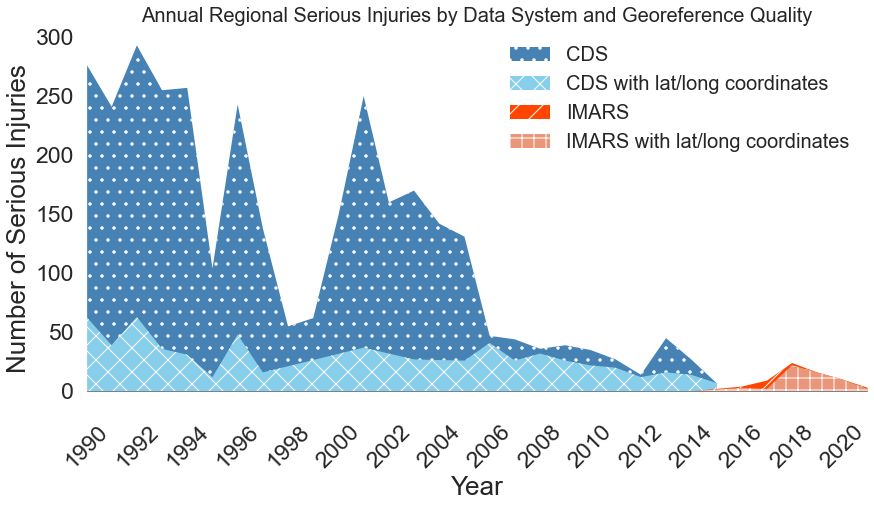

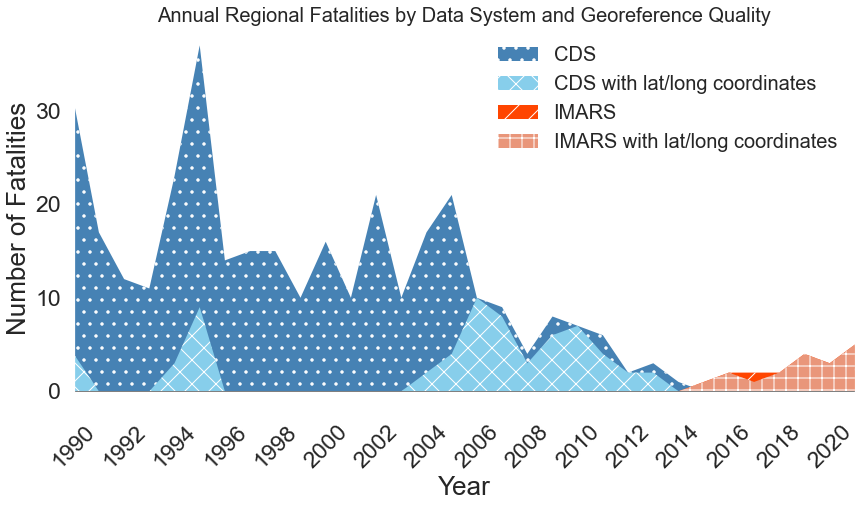

In [62]:
make_yearly_crash_fig("NCR")

## Regional Trends

### Injury & Fatality at all Parks
the following cells are to test out table creation for a single region 

In [63]:
# number of crashes that resulted in an injury or fatality by park
df = analysis_2022.loc[analysis_2022['RGN']=="AKR"]
df_inj_or_fatal = df.loc[df['Injury or Fatal']==1]
inj_or_fatal_crashes = df_inj_or_fatal.groupby("Park", as_index=False).agg({'INCID_NO':'count'})
inj_or_fatal_crashes

Park  INCID_NO
0  DENA        38
1  KEFJ         1
2  KLGO         1
3  SITK         1

In [64]:
# number of serious injuries and fatalities by park
injuries_and_fatals = df.groupby("Park", as_index=False).agg({'Num_Fatalities':'sum', 'Incapacitating Injury':'sum'})
injuries_and_fatals['Number of Fatalities'] = injuries_and_fatals['Num_Fatalities'].astype(int)
injuries_and_fatals['Number of Serious Injuries'] = injuries_and_fatals['Incapacitating Injury'].astype(int)
injuries_and_fatals = injuries_and_fatals.drop(columns=['Incapacitating Injury','Num_Fatalities'])
injuries_and_fatals

Park  Number of Fatalities  Number of Serious Injuries
0  DENA                     4                           8
1  GLBA                     0                           0
2  KATM                     0                           0
3  KEFJ                     0                           0
4  KLGO                     0                           0
5  SITK                     0                           2
6  WRST                     0                           0

In [65]:
full_table = injuries_and_fatals.merge(inj_or_fatal_crashes, how='left', on='Park')
full_table

Park  Number of Fatalities  Number of Serious Injuries  INCID_NO
0  DENA                     4                           8      38.0
1  GLBA                     0                           0       NaN
2  KATM                     0                           0       NaN
3  KEFJ                     0                           0       1.0
4  KLGO                     0                           0       1.0
5  SITK                     0                           2       1.0
6  WRST                     0                           0       NaN

In [66]:
full_table.fillna(0, inplace=True)
full_table['INCID_NO'] = full_table['INCID_NO'].astype(int)
full_table = full_table.rename(columns={'INCID_NO':'Number of Crashes Resulting in an Injury or Fatality'})
full_table

Park  Number of Fatalities  Number of Serious Injuries  \
0  DENA                     4                           8   
1  GLBA                     0                           0   
2  KATM                     0                           0   
3  KEFJ                     0                           0   
4  KLGO                     0                           0   
5  SITK                     0                           2   
6  WRST                     0                           0   

   Number of Crashes Resulting in an Injury or Fatality  
0                                                 38     
1                                                  0     
2                                                  0     
3                                                  1     
4                                                  1     
5                                                  1     
6                                                  0

### Table 4: Crash Outcomes by Park

In [67]:
def create_park_table(region):
    # create dataframe for number of serious injuries, number of fatalities, number of crashes that resulted in an injury or fatality by park   
    df = analysis_2022.loc[analysis_2022['RGN']==region]
    df_inj_or_fatal = df.loc[df['Injury or Fatal']==1]
    inj_or_fatal_crashes = df_inj_or_fatal.groupby("Park").agg({'INCID_NO':'count'})
    injuries_and_fatals = df.groupby("Park", as_index=False).agg({'Num_Fatalities':'sum', 'Incapacitating Injury':'sum'})
    injuries_and_fatals['Number of Fatalities'] = injuries_and_fatals['Num_Fatalities'].astype(int)
    injuries_and_fatals['Number of Serious Injuries'] = injuries_and_fatals['Incapacitating Injury'].astype(int)
    injuries_and_fatals = injuries_and_fatals.drop(columns=['Incapacitating Injury','Num_Fatalities'])
    full_table = injuries_and_fatals.merge(inj_or_fatal_crashes, how='left', on='Park')
    full_table.fillna(0, inplace=True)
    full_table['INCID_NO'] = full_table['INCID_NO'].astype(int)
    df_final = full_table.rename(columns={'INCID_NO':'Number of Crashes Resulting in an Injury or Fatality'})
   
    return df_final

In [68]:
def make_park_table(region):
    df = create_park_table(region)
    doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - blank.docx' # start wtih blank Volpe template
    doc = docx.Document(doc_name)
    doc.add_heading("Injury & fatality, at All Region Park Units")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1") # blue alternating

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc_name_new = './22-23\Drafted Deliverables\Figures/Park level tables/' + region + ".docx"
    doc.save(doc_name_new)

In [69]:
# test table; once satisfied, run all seven to save separately from companion document
make_park_table("IMR")

### All Crashes

### Figure 3: All Crashes by Speed Limit

In [70]:
def create_posted_speed_fig(region):
    from matplotlib.ticker import MaxNLocator
    df = analysis_2022.loc[analysis_2022['RGN']==region]
    speed_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
    speed_columns = ['5_mph', '10_mph', '15_mph', '20_mph', '25_mph','30_mph', '35_mph', '40_mph', '45_mph', '50_mph', '55_mph', '60_mph','65_mph', '70_mph', '75_mph']
    fatalities = []
    serious_injuries = []
    crashes = []
    
    for i in speed_columns:
        num_fatalities = df.loc[df[i]==1]['Num_Fatalities'].sum()
        fatalities.append(num_fatalities)
        num_serious_injuries = df.loc[df[i]==1]['Incapacitating Injury'].sum()
        serious_injuries.append(num_serious_injuries)    
        num_crashes = df.loc[df[i]==1].shape[0]
        crashes.append(num_crashes)
    
    # set up main figure with three subplots
    plt.style.use('seaborn')
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig, ax = plt.subplots(3,1,figsize=(20,15))
    tick_spacing = 5
    fig.suptitle('All Crashes by Speed Limit', fontsize=30)

    # subplot data
    ax[0].bar(speed_list, fatalities, width = 5, hatch = "\\", edgecolor = "black", linewidth=2)
    ax[1].bar(speed_list, serious_injuries, width = 5, hatch = "/", edgecolor = "black", linewidth=2)
    ax[2].bar(speed_list, crashes, width = 5, hatch = "x", edgecolor = "black", linewidth=2)

    # annotate all plots with bar totals
    rects = ax[0].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[1].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[2].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[2].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    # format each subplot
    ax[0].set_title("Fatalities",fontsize= 22, pad = 20)
    #ax[0].set_ylim([0, 300])
    ax[0].set_xlim([2, 78])
    ax[0].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_ylabel("# of Fatalities", fontsize = 22)#ylabel
    ax[0].tick_params(axis='x', which='major', labelsize=16)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='both', which='minor', labelsize=8)

    ax[1].set_title("Serious Injuries",fontsize= 22, pad = 20)
    #ax[1].set_ylim([0, 3000])
    ax[1].set_xlim([2, 78])
    ax[1].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_ylabel("# of Serious Injuries", fontsize = 19)#ylabel
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='both', which='minor', labelsize=8)

    ax[2].set_title("Crash Reports",fontsize= 22, pad = 20)
    #ax[2].set_ylim([0, 40000])
    ax[2].set_xlim([2, 78])
    ax[2].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[2].set_xlabel('Speed Limit',fontsize = 26) #xlabel
    ax[2].set_ylabel("# of Crash Reports", fontsize = 20)#ylabel
    ax[2].tick_params(axis='x', which='major', labelsize=16)
    ax[2].tick_params(axis='y', which='major', labelsize=16)
    ax[2].tick_params(axis='both', which='minor', labelsize=8)

    # set the spacing between subplots
    plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    
    doc_name = './22-23\Drafted Deliverables\Figures/Posted Speed Figures/' + region + ".png"
    
    plt.savefig(doc_name)


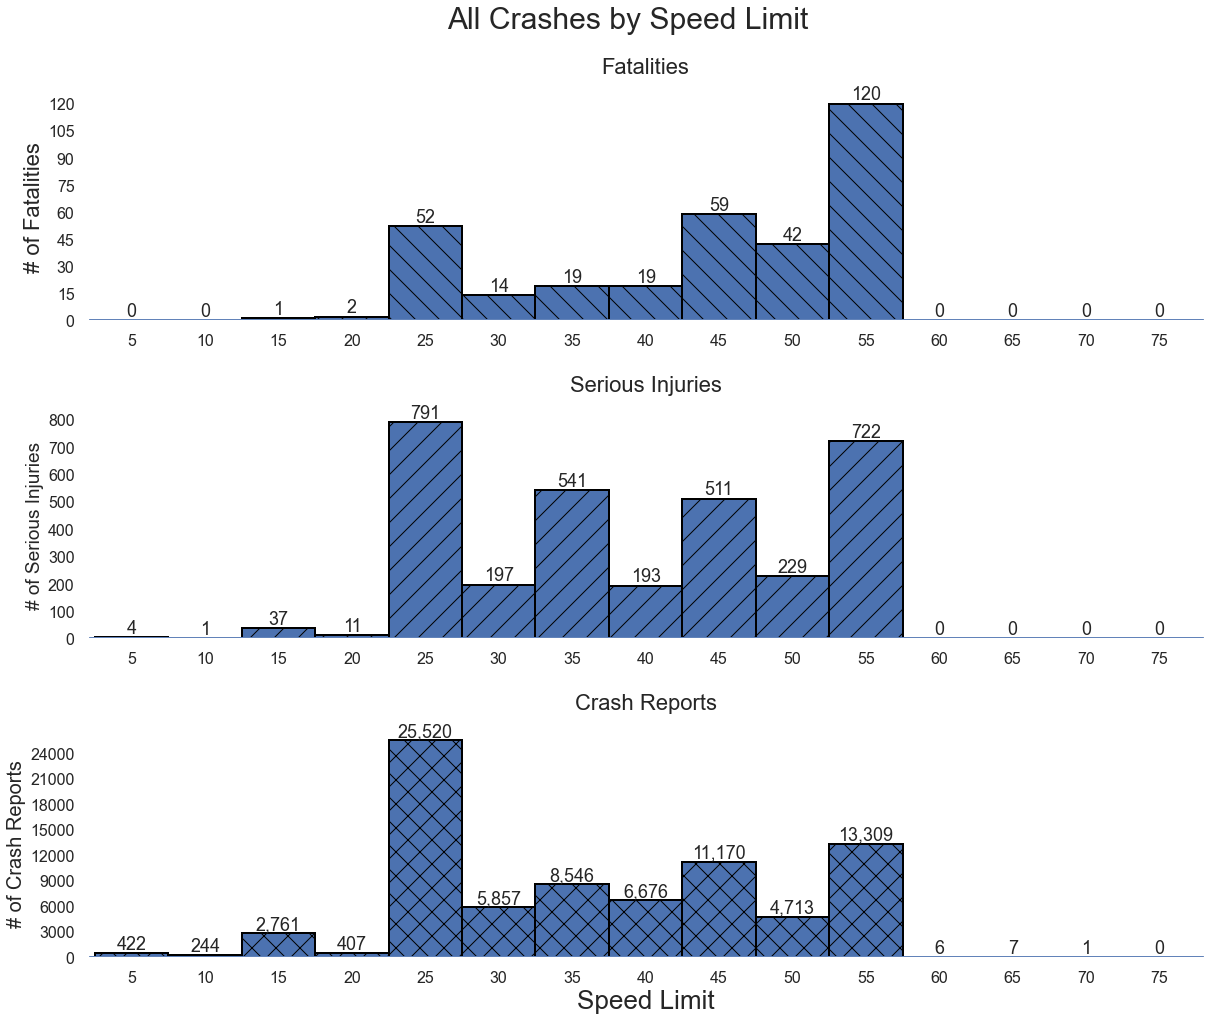

In [71]:
create_posted_speed_fig("NCR")

### Figure 4: All Crashes Resulting in an Injury or Fatality

In [72]:
def create_inj_or_fatal_fig(region):
    from matplotlib.ticker import MaxNLocator
    df = analysis_2022.loc[analysis_2022['RGN']==region]
    speed_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
    speed_columns = ['5_mph', '10_mph', '15_mph', '20_mph', '25_mph','30_mph', '35_mph', '40_mph', '45_mph', '50_mph', '55_mph', '60_mph','65_mph', '70_mph', '75_mph']
    inj_or_fatal = df.loc[df['Injury or Fatal']==1]
    vru_inj_or_fatal = inj_or_fatal.loc[inj_or_fatal['VRU']==1]
    animal_inj_or_fatal = inj_or_fatal.loc[inj_or_fatal['Involving Animal']==1]
    VRU_crashes = []
    wildlife_crashes = []
    all_crashes = []

    for i in speed_columns:
        num_VRU_crashes = vru_inj_or_fatal.loc[vru_inj_or_fatal[i]==1].shape[0]
        VRU_crashes.append(num_VRU_crashes)
        num_wildlife_crashes = animal_inj_or_fatal.loc[animal_inj_or_fatal[i]==1].shape[0]
        wildlife_crashes.append(num_wildlife_crashes)    
        num_all_crashes = inj_or_fatal.loc[inj_or_fatal[i]==1].shape[0]
        all_crashes.append(num_all_crashes)
    
   # set up main figure with three subplots
    plt.style.use('seaborn')
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig, ax = plt.subplots(3,1,figsize=(20,15))
    tick_spacing = 5
    fig.suptitle('Crashes Resulting in an Injury or Fatality', fontsize=30)

    # subplot data
    ax[0].bar(speed_list, VRU_crashes, width = 5, hatch = "\\", color = 'sienna', edgecolor = "black", linewidth=2)
    ax[1].bar(speed_list, wildlife_crashes, width = 5, hatch = "/", color = 'darkolivegreen', edgecolor = "black", linewidth=2)
    ax[2].bar(speed_list, all_crashes, width = 5, hatch = "x", edgecolor = "black", linewidth=2)

    # annotate all plots with bar totals
    rects = ax[0].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[1].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[2].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[2].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    # format each subplot
    ax[0].set_title("Crashes Involving VRUs",fontsize= 22, pad = 20)
    #ax[0].set_ylim([0, 500])
    ax[0].set_xlim([2, 78])
    ax[0].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_ylabel("# of Crash Reports", fontsize = 22)#ylabel
    ax[0].tick_params(axis='x', which='major', labelsize=16)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='both', which='minor', labelsize=8)

    ax[1].set_title("Crashes Involving Wildlife",fontsize= 22, pad = 20)
    #ax[1].set_ylim([0, 800])
    ax[1].set_xlim([2, 78])
    ax[1].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_ylabel("# of Crash Reports", fontsize = 22)#ylabel
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='both', which='minor', labelsize=8)

    ax[2].set_title("All Crashes",fontsize= 22, pad = 20)
    #ax[2].set_ylim([0, 10000])
    ax[2].set_xlim([2, 78])
    ax[2].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[2].set_xlabel('Speed Limit',fontsize = 26) #xlabel
    ax[2].set_ylabel("# of Crash Reports", fontsize = 22)#ylabel
    ax[2].tick_params(axis='x', which='major', labelsize=16)
    ax[2].tick_params(axis='y', which='major', labelsize=16)
    ax[2].tick_params(axis='both', which='minor', labelsize=8)

    # set the spacing between subplots
    plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    
    doc_name = './22-23\Drafted Deliverables\Figures/Injury or Fatal Figures/' + region + ".png"
    
    plt.savefig(doc_name)


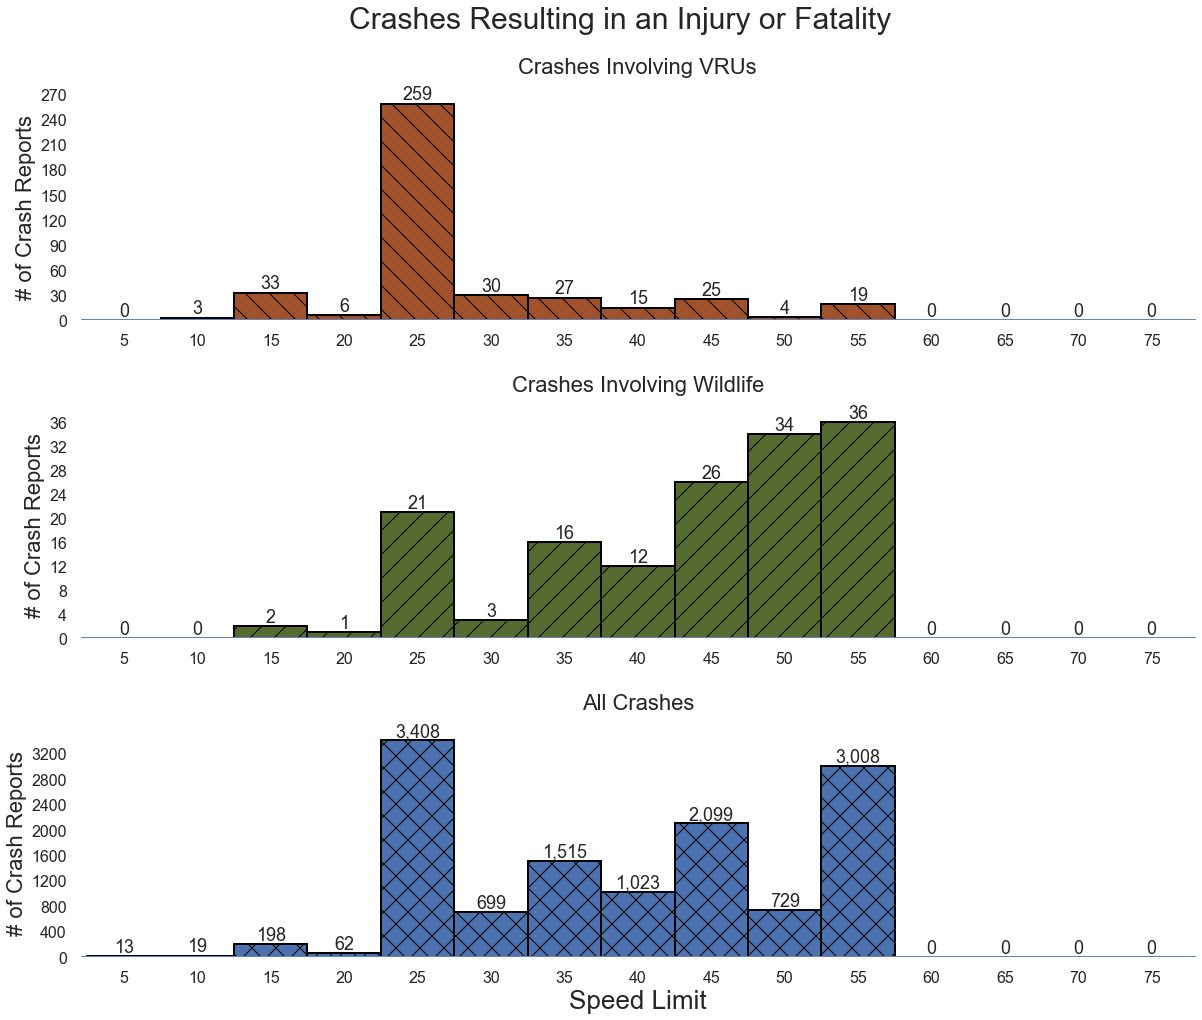

In [73]:
create_inj_or_fatal_fig("NCR")

### Wildlife crashes

### Table 5: Crashes Involving Wildlife, Regional and National 

In [74]:
def create_wildlife_crashes_table(region):
    # create dataframe for % of total crashes involving wildlife, % of wildlife crashes resulting in an injury or fatality, serious injuries and fatalities in wildlife crashes   

    rgn = analysis_2022.loc[analysis_2022['RGN']==region]
    animal = analysis_2022.loc[analysis_2022['Involving Animal']==1]
    animal_inj_or_fatal = animal.loc[animal['Injury or Fatal']==1]
    animal_region = animal.loc[animal['RGN']==region]
    animal_inj_or_fatal_region = animal_region.loc[animal_region['Injury or Fatal']==1]
    #animal_total_crashes_region = animal_inj_or_fatal_region.shape[0]
    animal_percent_region = round(animal_region.shape[0]/rgn.shape[0]*100,2)
    animal_inj_or_fatal_percent_region = round(animal_inj_or_fatal_region.shape[0]/animal_region.shape[0]*100,2)
    #animal_injury_region = int(animal_region['Num_Injuries'].sum())
    animal_serious_injury_region = int(animal_region['Incapacitating Injury'].sum())
    animal_fatals_region = int(animal_region['Num_Fatalities'].sum())
        
    #animal_total_crashes = animal_inj_or_fatal.shape[0]
    animal_percent = round(animal.shape[0]/analysis_2022.shape[0]*100,2)
    animal_inj_or_fatal_percent = round(animal_inj_or_fatal.shape[0]/animal.shape[0]*100,2)
    #animal_injury = int(animal['Num_Injuries'].sum())
    animal_serious_injury = int(animal['Incapacitating Injury'].sum())
    animal_fatals = int(animal['Num_Fatalities'].sum())
    
    df_final = pd.DataFrame({
    "Fields": ["Percent of Total Crashes", "Percent of Wildlife Crashes that Resulted in an Injury/Fatality", "Number of Serious Injuries", "Number of Fatalities"],
    "Region": [str(animal_percent_region) + "%", str(animal_inj_or_fatal_percent_region) + "%", animal_serious_injury_region, animal_fatals_region], 
    "National": [str(animal_percent) + "%", str(animal_inj_or_fatal_percent) + "%", animal_serious_injury, animal_fatals]
     })
    
    return df_final

In [75]:
def make_wildlife_crashes_table(region):
    df = create_wildlife_crashes_table(region)
    doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - blank.docx' # start with blank Volpe template
    doc = docx.Document(doc_name)
    doc.add_heading("Crashes Involving Wildlife, Regional and National")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6") # green alternating

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc_name_new = './22-23\Drafted Deliverables\Figures/Wildlife Tables/' + region + ".docx"
    doc.save(doc_name_new)

In [76]:
# test table; once satisfied, run all seven to save separately from companion document
make_wildlife_crashes_table("NCR")

### Figure 5: Wildlife Crashes by Speed Limit

In [80]:
def create_posted_speed_fig_animals(region):
    from matplotlib.ticker import MaxNLocator
    df = analysis_2022.loc[analysis_2022['RGN']==region]   
    speed_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
    speed_columns = ['5_mph', '10_mph', '15_mph', '20_mph', '25_mph','30_mph', '35_mph', '40_mph', '45_mph', '50_mph', '55_mph', '60_mph','65_mph', '70_mph', '75_mph']
    animal = df.loc[df['Involving Animal']==1]
    animal_inj_or_fatal = animal.loc[animal['Injury or Fatal']==1]
    animal_fatalities = []
    animal_serious_injuries = []
    animal_crashes = []

    for i in speed_columns:
        num_animal_fatalities = animal.loc[animal[i]==1]['Num_Fatalities'].sum()
        animal_fatalities.append(num_animal_fatalities)
        num_animal_serious_injuries = animal.loc[animal[i]==1]['Incapacitating Injury'].sum()
        animal_serious_injuries.append(num_animal_serious_injuries)    
        num_animal_crashes = animal.loc[animal[i]==1].shape[0]
        #num_animal_crashes = animal_inj_or_fatal.loc[animal_inj_or_fatal[i]==1].shape[0]
        animal_crashes.append(num_animal_crashes)
        
    # set up main figure with three subplots
    plt.style.use('seaborn')
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig, ax = plt.subplots(3,1,figsize=(20,15))
    tick_spacing = 5
    fig.suptitle('Wildlife Crashes by Speed Limit', fontsize=30)

    # subplot data
    ax[0].bar(speed_list, animal_fatalities, width = 5, hatch = "\\", color = 'darkolivegreen', edgecolor = "black", linewidth=2)
    ax[1].bar(speed_list, animal_serious_injuries, width = 5, hatch = "/", color = 'darkolivegreen', edgecolor = "black", linewidth=2)
    ax[2].bar(speed_list, animal_crashes, width = 5, hatch = "x", color = 'darkolivegreen', edgecolor = "black", linewidth=2)

    # annotate all plots with bar totals
    rects = ax[0].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[1].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[2].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[2].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    # format each subplot
    ax[0].set_title("Fatalities",fontsize= 22, pad = 20)
    #ax[0].set_ylim([0, 20])
    ax[0].set_xlim([2, 78])
    ax[0].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_ylabel("# of Fatalities", fontsize = 22)#ylabel
    ax[0].tick_params(axis='x', which='major', labelsize=16)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='both', which='minor', labelsize=8)

    ax[1].set_title("Serious Injuries",fontsize= 22, pad = 20)
    #ax[1].set_ylim([0, 200])
    ax[1].set_xlim([2, 78])
    ax[1].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_ylabel("# of Serious Injuries", fontsize = 19)#ylabel
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='both', which='minor', labelsize=8)

    ax[2].set_title("Crash Reports",fontsize= 22, pad = 20)
    #ax[2].set_ylim([0, 800])
    ax[2].set_xlim([2, 78])
    ax[2].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[2].set_xlabel('Speed Limit',fontsize = 26) #xlabel
    ax[2].set_ylabel("# of Crash Reports", fontsize = 20)#ylabel
    ax[2].tick_params(axis='x', which='major', labelsize=16)
    ax[2].tick_params(axis='y', which='major', labelsize=16)
    ax[2].tick_params(axis='both', which='minor', labelsize=8)

    # set the spacing between subplots
    plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    doc_name = './22-23\Drafted Deliverables\Figures/Wildlife Figures/' + region + ".png"
    
    plt.savefig(doc_name)

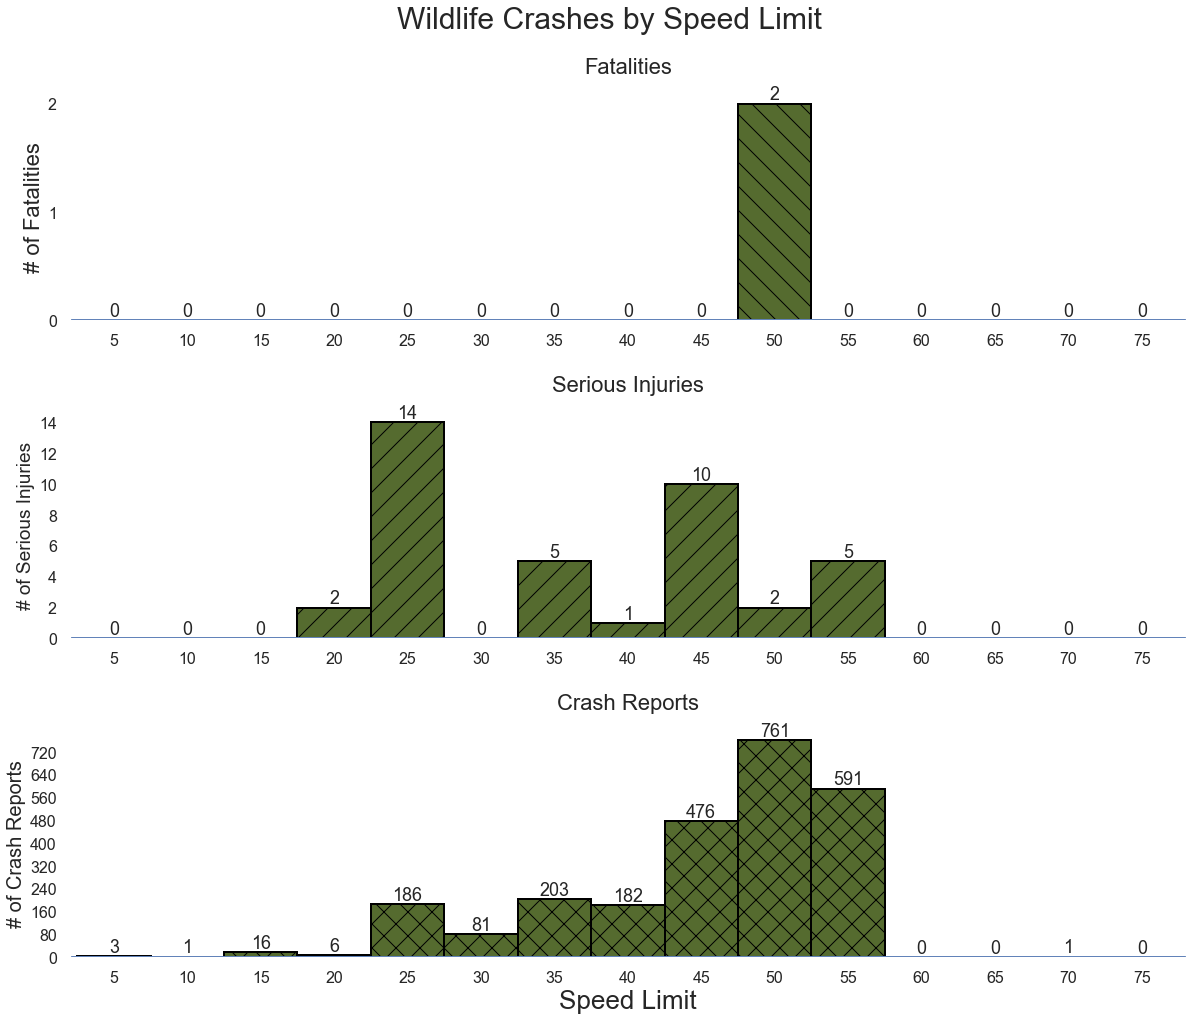

In [81]:
create_posted_speed_fig_animals("NCR")

### Table 6: Wildlife Crash Outcomes by Park

In [82]:
def create_wildlife_crashes_table_park(region):
    # create dataframe for number of serious injuries and fatalities in wildlife crashes, number of wildlife crashes that resulted in an injury or fatality by park   
    df = analysis_2022.loc[analysis_2022['RGN']==region]
    df_animal = df.loc[df['Involving Animal']==1]
    df_animal_inj_or_fatal = df_animal.loc[df_animal['Injury or Fatal']==1]
    animal_inj_or_fatal_crashes = df_animal_inj_or_fatal.groupby("Park").agg({'INCID_NO':'count'})
    animal_injuries_and_fatals = df_animal.groupby("Park", as_index=False).agg({'Num_Fatalities':'sum', 'Incapacitating Injury':'sum'})
    animal_injuries_and_fatals['Number of Fatalities'] = animal_injuries_and_fatals['Num_Fatalities'].astype(int)
    animal_injuries_and_fatals['Number of Serious Injuries'] = animal_injuries_and_fatals['Incapacitating Injury'].astype(int)
    animal_injuries_and_fatals = animal_injuries_and_fatals.drop(columns=['Incapacitating Injury','Num_Fatalities'])
    full_table_animal = animal_injuries_and_fatals.merge(animal_inj_or_fatal_crashes, how='left', on='Park')
    full_table_animal.fillna(0, inplace=True)
    full_table_animal['INCID_NO'] = full_table_animal['INCID_NO'].astype(int)
    df_final = full_table_animal.rename(columns={'INCID_NO':'Number of Crashes Resulting in an Injury or Fatality'})

    return df_final

In [83]:
def make_wildlife_crashes_table_park(region):
    df = create_wildlife_crashes_table_park(region)
    doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - blank.docx' # start with blank Volpe template
    doc = docx.Document(doc_name)
    doc.add_heading("Park-Level Wildlife Crashes and Outcomes")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1") # blue alternating

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc_name_new = './22-23\Drafted Deliverables\Figures/Wildlife Tables/' 'Park-Level-' + region + ".docx"
    doc.save(doc_name_new)

In [84]:
# test table; once satisfied, run all seven to save separately from companion document
make_wildlife_crashes_table_park("NCR")

### Table 7: Wildlife Crash Outcomes by Type of Animal

In [85]:
def create_wildlife_crashes_table_species(region):
    # create dataframe for number of serious injuries and fatalities in wildlife crashes, number of wildlife crashes that resulted in an injury or fatality by animal type
    animal = analysis_2022.loc[analysis_2022['Involving Animal']==1]
    animal_region = animal.loc[animal['RGN']==region]
    animal_region_inj_or_fatal = animal_region.loc[animal_region['Injury or Fatal']==1]
    animal_list = ['HorseLlama', 'Cow', 'Deer', 'Elk', 'Moose', 'Buffalo', 'Bear', 'Antelope', 'SheepGoats', 'OtherWild', 'OtherDomestic']
    df_final = pd.DataFrame(columns={"Type of Animal", "Number of Fatalities", "Number of Serious Injuries", 'Number of Crashes Resulting in an Injury or Fatality'})
    animal_fatalities = []
    animal_serious_injuries = []
    animal_inj_or_fatal_crashes = []

    for i in animal_list:
        num_animal_fatalities = int(animal_region.loc[animal_region[i]==1]['Num_Fatalities'].sum())
        animal_fatalities.append(num_animal_fatalities)
        num_animal_serious_injuries = int(animal_region.loc[animal_region[i]==1]['Incapacitating Injury'].sum())
        animal_serious_injuries.append(num_animal_serious_injuries)    
        animal_inj_or_fatal_num_crashes = int(animal_region_inj_or_fatal.loc[animal_region_inj_or_fatal[i]==1].shape[0])
        animal_inj_or_fatal_crashes.append(animal_inj_or_fatal_num_crashes)

    df_final["Number of Fatalities"] = animal_fatalities
    df_final["Number of Serious Injuries"] = animal_serious_injuries
    df_final["Number of Crashes Resulting in an Injury or Fatality"] = animal_inj_or_fatal_crashes
    df_final["Type of Animal"] = ['Horse/Llama', 'Cow', 'Deer', 'Elk', 'Moose', 'Buffalo', 'Bear', 'Antelope', 'Sheep/Goat', 'Other Wild Animal', 'Other Domestic Animal']
    df_final = df_final[["Type of Animal","Number of Fatalities","Number of Serious Injuries","Number of Crashes Resulting in an Injury or Fatality"]]
    
    return df_final

In [86]:
def make_wildlife_crashes_table_species(region):
    df = create_wildlife_crashes_table_species(region)
    doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - blank.docx' # start with blank Volpe template
    doc = docx.Document(doc_name)
    doc.add_heading("Species-Level Wildlife Crashes and Outcomes")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6") # green alternating

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc_name_new = './22-23\Drafted Deliverables\Figures/Wildlife Tables/' 'Species-Level-' + region + ".docx"
    doc.save(doc_name_new)

In [87]:
# test table; once satisfied, run all seven to save separately from companion document
make_wildlife_crashes_table_species("NER")

### VRU crashes

### Table 8: Crashes Involving VRUs, Regional and National 

In [88]:
def create_vru_crashes_table(region):
    # create dataframe for % of total crashes involving VRUs, % of VRU crashes resulting in an injury or fatality, serious injuries and fatalities in VRU crashes   

    rgn = analysis_2022.loc[analysis_2022['RGN']==region]
    vru = analysis_2022.loc[analysis_2022['VRU']==1]
    vru_inj_or_fatal = vru.loc[vru['Injury or Fatal']==1]
    vru_region = vru.loc[vru['RGN']==region]
    vru_inj_or_fatal_region = vru_region.loc[vru_region['Injury or Fatal']==1]
    #vru_total_crashes_region = vru_inj_or_fatal_region.shape[0]
    vru_percent_region = round(vru_region.shape[0]/rgn.shape[0]*100,2)
    vru_inj_or_fatal_percent_region = round(vru_inj_or_fatal_region.shape[0]/vru_region.shape[0]*100,2)
    #vru_injury_region = int(vru_region['Num_Injuries'].sum())
    vru_serious_injury_region = int(vru_region['Incapacitating Injury'].sum())
    vru_fatals_region = int(vru_region['Num_Fatalities'].sum())
        
    #vru_total_crashes = vru_inj_or_fatal.shape[0]
    vru_percent = round(vru.shape[0]/analysis_2022.shape[0]*100,2)
    vru_inj_or_fatal_percent = round(vru_inj_or_fatal.shape[0]/vru.shape[0]*100,2)
    #vru_injury = int(vru['Num_Injuries'].sum())
    vru_serious_injury = int(vru['Incapacitating Injury'].sum())
    vru_fatals = int(vru['Num_Fatalities'].sum())
    
    df_final = pd.DataFrame({
    "Fields": ["Percent of Total Crashes", "Percent of VRU Crashes that Resulted in an Injury/Fatality", "Number of Serious Injuries", "Number of Fatalities"],
    "Region": [str(vru_percent_region) + "%", str(vru_inj_or_fatal_percent_region) + "%", vru_serious_injury_region, vru_fatals_region], 
    "National": [str(vru_percent) + "%", str(vru_inj_or_fatal_percent) + "%", vru_serious_injury, vru_fatals]
     })
    
    return df_final

In [89]:
def make_vru_crashes_table(region):
    df = create_vru_crashes_table(region)
    doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - blank.docx' # start with blank Volpe template
    doc = docx.Document(doc_name)
    doc.add_heading("Crashes Involving VRUs, Regional and National")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1") # blue alternating

    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc_name_new = './22-23\Drafted Deliverables\Figures/VRU tables/' + region + ".docx"
    doc.save(doc_name_new)

In [90]:
# test table; once satisfied, run all seven to save separately from companion document
make_vru_crashes_table("NCR")

### Figure 6: VRU crashes by Speed Limit

In [91]:
def create_posted_speed_fig_vrus(region):
    from matplotlib.ticker import MaxNLocator
    df = analysis_2022.loc[analysis_2022['RGN']==region]   
    speed_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
    speed_columns = ['5_mph', '10_mph', '15_mph', '20_mph', '25_mph','30_mph', '35_mph', '40_mph', '45_mph', '50_mph', '55_mph', '60_mph','65_mph', '70_mph', '75_mph']
    vru = df.loc[df['VRU']==1]
    vru_inj_or_fatal = vru.loc[vru['Injury or Fatal']==1]
    vru_fatalities = []
    vru_serious_injuries = []
    vru_crashes = []

    for i in speed_columns:
        num_vru_fatalities = vru.loc[vru[i]==1]['Num_Fatalities'].sum()
        vru_fatalities.append(num_vru_fatalities)
        num_vru_serious_injuries = vru.loc[vru[i]==1]['Incapacitating Injury'].sum()
        vru_serious_injuries.append(num_vru_serious_injuries)    
        num_vru_crashes = vru.loc[vru[i]==1].shape[0]
        #num_vru_crashes = vru_inj_or_fatal.loc[vru_inj_or_fatal[i]==1].shape[0]
        vru_crashes.append(num_vru_crashes)
        
    plt.style.use('seaborn')
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig, ax = plt.subplots(3,1,figsize=(20,15))
    tick_spacing = 5
    fig.suptitle('VRU Crashes by Speed Limit', fontsize=30)

    # subplot data
    ax[0].bar(speed_list, vru_fatalities, width = 5, hatch = "\\", color = 'sienna', edgecolor = "black", linewidth=2)
    ax[1].bar(speed_list, vru_serious_injuries, width = 5, hatch = "/", color = 'sienna', edgecolor = "black", linewidth=2)
    ax[2].bar(speed_list, vru_crashes, width = 5, hatch = "x", color = 'sienna', edgecolor = "black", linewidth=2)

    # annotate all plots with bar totals
    rects = ax[0].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[1].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[2].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[2].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    # format each subplot
    ax[0].set_title("Fatalities",fontsize= 22, pad = 20)
    #ax[0].set_ylim([0, 20])
    ax[0].set_xlim([2, 78])
    ax[0].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[0].set_ylabel("# of Fatalities", fontsize = 22)#ylabel
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].tick_params(axis='x', which='major', labelsize=16)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='both', which='minor', labelsize=8)

    ax[1].set_title("Serious Injuries",fontsize= 22, pad = 20)
    #ax[1].set_ylim([0, 200])
    ax[1].set_xlim([2, 78])
    ax[1].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_ylabel("# of Serious Injuries", fontsize = 19)#ylabel
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='both', which='minor', labelsize=8)

    ax[2].set_title("Crash Reports",fontsize= 22, pad = 20)
    #ax[2].set_ylim([0, 500])
    ax[2].set_xlim([2, 78])
    ax[2].hlines(0, xmin = 0, xmax = 78, linewidth = 3)
    ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[2].set_xlabel('Speed Limit',fontsize = 26) #xlabel
    ax[2].set_ylabel("# of Crash Reports", fontsize = 20)#ylabel
    ax[2].tick_params(axis='x', which='major', labelsize=16)
    ax[2].tick_params(axis='y', which='major', labelsize=16)
    ax[2].tick_params(axis='both', which='minor', labelsize=8)

    # set the spacing between subplots
    plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    doc_name = './22-23\Drafted Deliverables\Figures/VRU Figures/' + region + ".png"
    
    plt.savefig(doc_name)


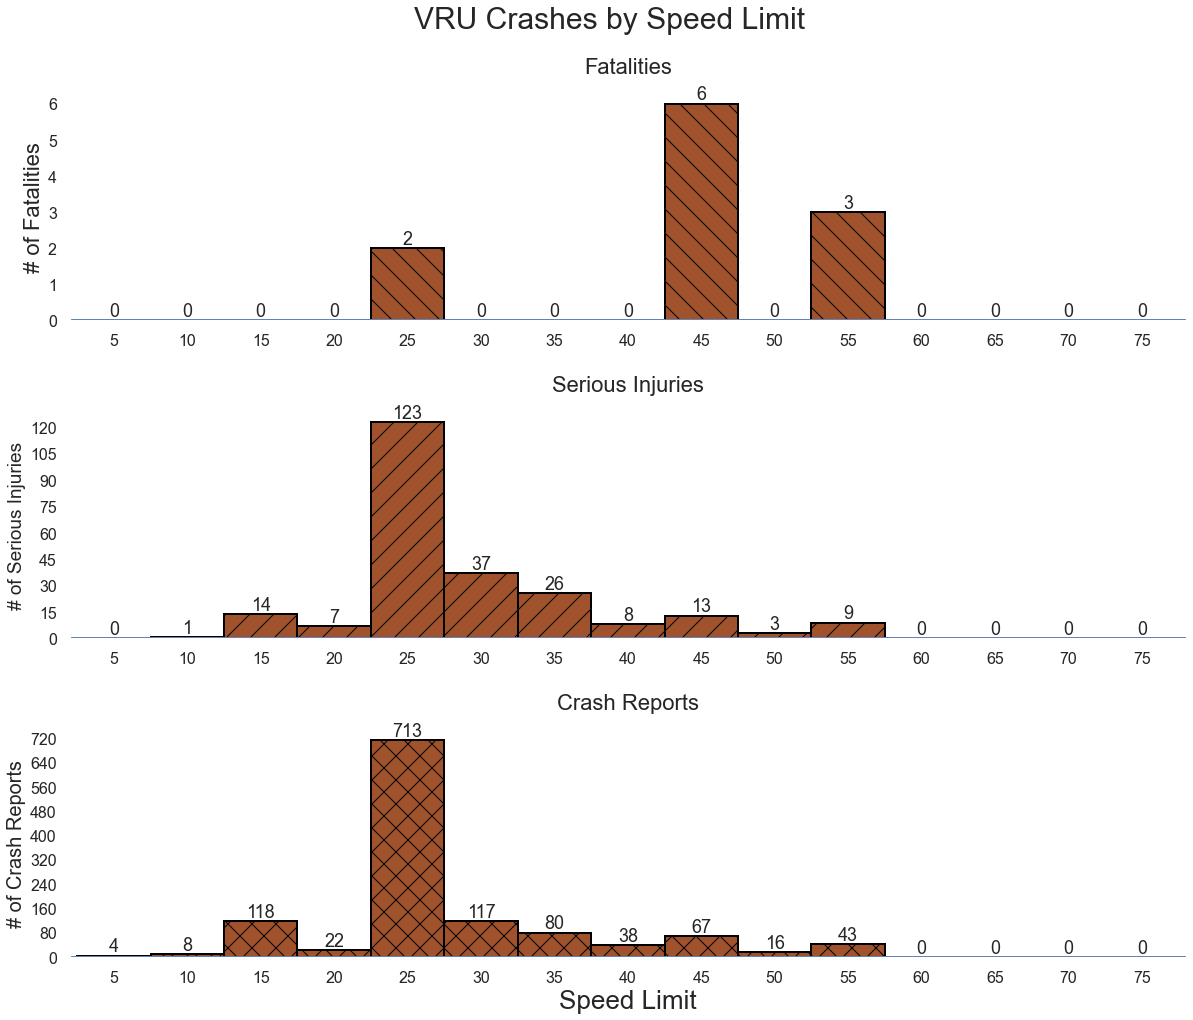

In [92]:
create_posted_speed_fig_vrus("NCR")

### Figure 7: VRU crashes by Location

In [93]:
def create_location_fig_vrus(region):
    from matplotlib.ticker import MaxNLocator
    df = analysis_2022.loc[analysis_2022['RGN']==region]   
    crosswalks = ['Crosswalk','Outside a Crosswalk']
    vru = df.loc[df['VRU']==1]
    vru_inj_or_fatal = vru.loc[vru['Injury or Fatal']==1]
    vru_crosswalk_fatalities = []
    vru_crosswalk_serious_injuries = []
    vru_crosswalk_crashes = []

    for i in crosswalks:
        num_vru_crosswalk_fatalities = vru.loc[vru[i]==1]['Num_Fatalities'].sum()
        vru_crosswalk_fatalities.append(num_vru_crosswalk_fatalities)
        num_vru_crosswalk_serious_injuries = vru.loc[vru[i]==1]['Incapacitating Injury'].sum()
        vru_crosswalk_serious_injuries.append(num_vru_crosswalk_serious_injuries)    
        num_vru_crosswalk_crashes = vru_inj_or_fatal.loc[vru_inj_or_fatal[i]==1].shape[0]
        vru_crosswalk_crashes.append(num_vru_crosswalk_crashes)

    # set up main figure with three subplots
    plt.style.use('seaborn')
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig, ax = plt.subplots(3,1,figsize=(20,15))
    fig.suptitle('VRU Crashes by Crash Location', fontsize=30)

    # subplot data
    ax[0].bar(crosswalks, vru_crosswalk_fatalities, hatch = "\\", color = 'sienna', edgecolor = "black", linewidth=2)
    ax[1].bar(crosswalks, vru_crosswalk_serious_injuries, hatch = "/", color = 'sienna', edgecolor = "black", linewidth=2)
    ax[2].bar(crosswalks, vru_crosswalk_crashes, hatch = "x", color = 'sienna', edgecolor = "black", linewidth=2)

    # annotate all plots with bar totals
    rects = ax[0].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[1].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[2].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[2].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    # format each subplot
    ax[0].set_title("Fatalities",fontsize= 22, pad = 20)
    #ax[0].set_ylim([0, 10])
    ax[0].hlines(0, xmin = 0, xmax = 1, linewidth = 3)
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_ylabel("# of Fatalities", fontsize = 22)#ylabel
    ax[0].tick_params(axis='x', which='major', labelsize=22)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='both', which='minor', labelsize=8)

    ax[1].set_title("Serious Injuries",fontsize= 22, pad = 20)
    #ax[1].set_ylim([0, 100])
    ax[1].hlines(0, xmin = 0, xmax = 1, linewidth = 3)
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_ylabel("# of Serious Injuries", fontsize = 19)#ylabel
    ax[1].tick_params(axis='x', which='major', labelsize=22)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='both', which='minor', labelsize=8)

    ax[2].set_title("Crash Reports Resulting in an Injury/Fatality",fontsize= 22, pad = 20)
    #ax[2].set_ylim([0, 250])
    ax[2].hlines(0, xmin = 0, xmax = 1, linewidth = 3)
    ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[2].set_xlabel('Crash Location',fontsize = 26) #xlabel
    ax[2].set_ylabel("# of Crash Reports", fontsize = 20)#ylabel
    ax[2].tick_params(axis='x', which='major', labelsize=22)
    ax[2].tick_params(axis='y', which='major', labelsize=16)
    ax[2].tick_params(axis='both', which='minor', labelsize=8)

    # set the spacing between subplots
    plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    doc_name = './22-23\Drafted Deliverables\Figures/Crosswalk Figures/' + region + ".png"
    
    plt.savefig(doc_name)


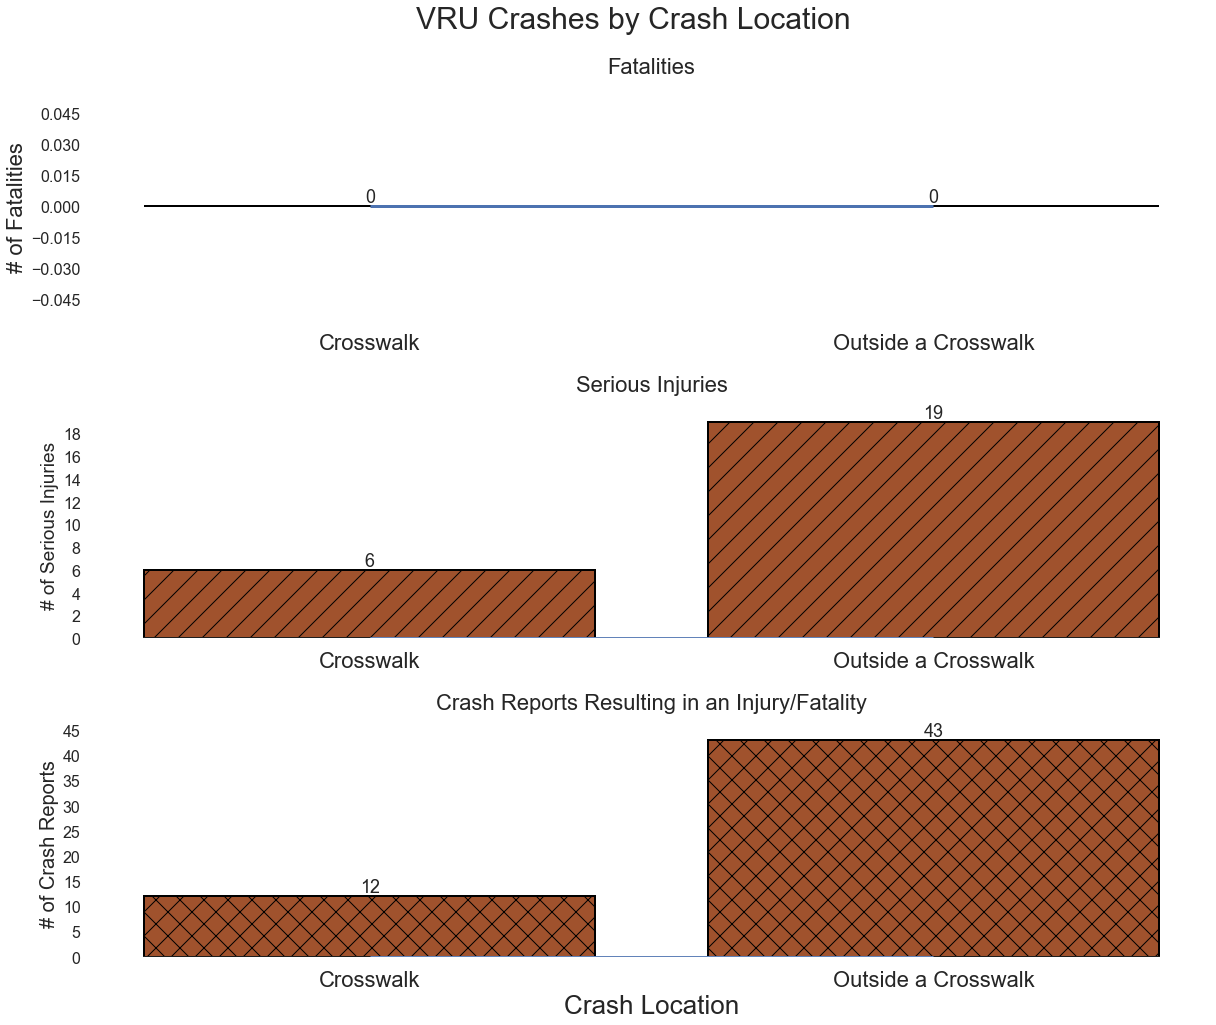

In [94]:
create_location_fig_vrus("NCR")

### Figure 8: VRU crashes by VRU Type

In [95]:
def create_type_fig_vrus(region):
    from matplotlib.ticker import MaxNLocator
    df = analysis_2022.loc[analysis_2022['RGN']==region]   
    vru_type = ['Pedestrian', 'Bicycle'] # pedacycle removed because all data were zero
    vru = df.loc[df['VRU']==1]
    vru_inj_or_fatal = vru.loc[vru['Injury or Fatal']==1]
    vru_type_fatalities = []
    vru_type_serious_injuries = []
    vru_type_crashes = []

    for i in vru_type:
        num_vru_type_fatalities = vru.loc[vru[i]==1]['Num_Fatalities'].sum()
        vru_type_fatalities.append(num_vru_type_fatalities)
        num_vru_type_serious_injuries = vru.loc[vru[i]==1]['Incapacitating Injury'].sum()
        vru_type_serious_injuries.append(num_vru_type_serious_injuries)    
        num_vru_type_crashes = vru_inj_or_fatal.loc[vru_inj_or_fatal[i]==1].shape[0]
        vru_type_crashes.append(num_vru_type_crashes)

    # set up main figure with three subplots
    plt.style.use('seaborn')
    sns.set(rc={'axes.facecolor':'1', 'figure.facecolor':'white', 'patch.linewidth': 0.0})
    fig, ax = plt.subplots(3,1,figsize=(20,15))
    fig.suptitle('VRU Crashes by VRU Type', fontsize=30)

    # subplot data
    ax[0].bar(vru_type, vru_type_fatalities, hatch = "\\", color = 'sienna', edgecolor = "black", linewidth=2)
    ax[1].bar(vru_type, vru_type_serious_injuries, hatch = "/", color = 'sienna', edgecolor = "black", linewidth=2)
    ax[2].bar(vru_type, vru_type_crashes, hatch = "x", color = 'sienna', edgecolor = "black", linewidth=2)

    # annotate all plots with bar totals
    rects = ax[0].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[1].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    rects = ax[2].patches
    labels = [f"label{i}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        label = '{:,}'.format(int(height))
        ax[2].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom",fontsize=18)

    # format each subplot
    ax[0].set_title("Fatalities",fontsize= 22, pad = 20)
    #ax[0].set_ylim([0, 10])
    ax[0].hlines(0, xmin = 0, xmax = 1, linewidth = 3)
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_ylabel("# of Fatalities", fontsize = 22)#ylabel
    ax[0].tick_params(axis='x', which='major', labelsize=22)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='both', which='minor', labelsize=8)

    ax[1].set_title("Serious Injuries",fontsize= 22, pad = 20)
    #ax[1].set_ylim([0, 100])
    ax[1].hlines(0, xmin = 0, xmax = 1, linewidth = 3)
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_ylabel("# of Serious Injuries", fontsize = 19)#ylabel
    ax[1].tick_params(axis='x', which='major', labelsize=22)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='both', which='minor', labelsize=8)

    ax[2].set_title("Crash Reports Resulting in an Injury/Fatality",fontsize= 22, pad = 20)
    #ax[2].set_ylim([0, 250])
    ax[2].hlines(0, xmin = 0, xmax = 1, linewidth = 3)
    ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[2].set_xlabel('VRU Type',fontsize = 26) #xlabel
    ax[2].set_ylabel("# of Crash Reports", fontsize = 20)#ylabel
    ax[2].tick_params(axis='x', which='major', labelsize=22)
    ax[2].tick_params(axis='y', which='major', labelsize=16)
    ax[2].tick_params(axis='both', which='minor', labelsize=8)

    # set the spacing between subplots
    plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    doc_name = './22-23\Drafted Deliverables\Figures/VRU Figures/' 'VRU-types-'+ region + ".png"
    
    plt.savefig(doc_name)


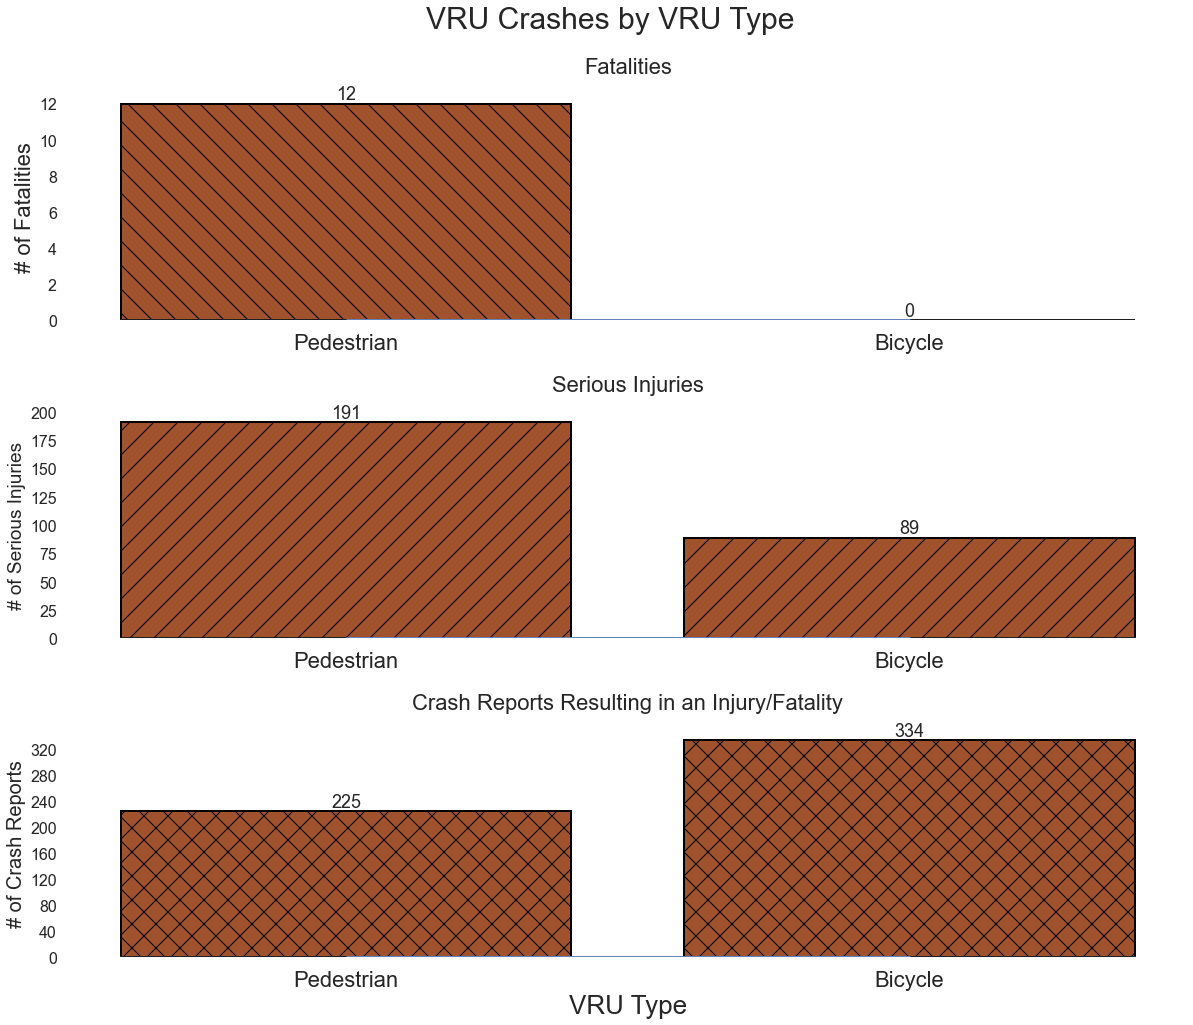

In [96]:
create_type_fig_vrus("NCR")

# Create final document

In [97]:
doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - Testing.docx'
doc = docx.Document(doc_name)
styles = doc.styles
for s in styles:
    print(s)
print(styles)

_ParagraphStyle('Normal') id: 2799566817696
_ParagraphStyle('Heading 1') id: 2799566818512
_ParagraphStyle('Heading 2') id: 2799566816688
_ParagraphStyle('Heading 3') id: 2799566818848
_ParagraphStyle('Heading 6') id: 2799566815872
_ParagraphStyle('Heading 7') id: 2799566818560
_ParagraphStyle('Heading 8') id: 2799566815824
_ParagraphStyle('Heading 9') id: 2799566815440
_TableStyle('Normal Table') id: 2799566816352
_ParagraphStyle('toc 1') id: 2799586006160
_ParagraphStyle('toc 2') id: 2799586006448
_ParagraphStyle('toc 3') id: 2799586006736
_ParagraphStyle('Header') id: 2799586007696
_ParagraphStyle('Footer') id: 2799586006544
_TableStyle('Table Grid1') id: 2799586007792
_TableStyle('Table Grid') id: 2799586008512
_ParagraphStyle('List Paragraph') id: 2799586007840
_ParagraphStyle('annotation text') id: 2799570719312
_ParagraphStyle('annotation subject') id: 2799570722672
_ParagraphStyle('footnote text') id: 2799570721424
_ParagraphStyle('Normal (Web)') id: 2799570722624
_TableStyle('

In [102]:
def add_regional_information(region):
    df = make_source_table(region)
    doc_name = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - blank.docx'
    doc = docx.Document(doc_name)
    doc.add_heading("Overview of Region")
    
    doc.add_heading("Available Data", 2)
    #doc.add_paragraph(" ")
    doc.add_paragraph("Table 1. Overview of Data Sources", style="Caption")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6")
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
            
    doc.add_heading("Data Quality", 2)
    
    doc.add_heading("Crash Report Completeness by Field", 3)
    #doc.add_paragraph("Below is a table of CDS and IMARS crash report completeness, broken down by region. Reports are labeled as incomplete if they only contain a crash table with core crash elements (e.g. coordinates, crash classification, etc.). For CDS crashes, this means vehicle and passenger data tables are not populated. The NCR was an outlier as compared to other regions, with around 8% of reports failing to include vehicle or passenger data tables. For IMARS crashes, this means crash details, vehicle, and passenger data tables are not populated. IMARS reports have generally been less complete across each region. ")
    doc.add_paragraph("Table 2. CDS Crash Report Completeness, Regional and National (1989-2015)", style="Caption")
    df = create_data_quality_table_cds(region)
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1")
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc.add_paragraph(" ")
    doc.add_paragraph("Table 3. IMARS Crash Report Completeness, Regional and National (2013-2021)", style="Caption")
    df = create_data_quality_table_imars(region)
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6")
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j]) 
    #doc.add_paragraph(" ")
    
    doc.add_heading("Crash Report Completeness by Year", 3)
    #doc.add_paragraph(" ")
    make_yearly_crash_fig(region)
    doc.add_paragraph("Figure 1. Annual Regional Serious Injuries by Data System and Georeference Quality", style="Caption")
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Yearly injury/' + region + ".png", width = 5943600, height = 3447288)
    doc.add_paragraph(" ")
    doc.add_paragraph("Figure 2. Annual Regional Fatalities by Data System and Georeference Quality", style="Caption")
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Yearly fatality/' + region + ".png", width = 5943600, height = 3447288)
    doc.add_paragraph(" ")
    
    #doc.add_heading("Completeness of crash report by park", 3)
    #doc.add_paragraph(" ")
    #doc.add_paragraph("Add figure showing trends over time across CDS and IMARS. Repeat for all crashes, crashes with injuries, and crashes with fatalities")
    #doc.add_paragraph(" ")

    doc.add_heading("Regional Trends", 2)
    
    doc.add_heading("Park-Level Crashes", 3)
    #doc.add_paragraph(" ")
    df = create_park_table(region)
    doc.add_paragraph("Table 4. Crash Outcomes by Park (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1")
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc.add_paragraph(" ")
    
    doc.add_heading("Crashes by Speed Limit", 3)
    doc.add_paragraph("Figure 3. All Crashes by Speed Limit (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    create_posted_speed_fig(region)
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Posted Speed Figures/' + region + ".png", width = 5943600, height = 4828270)
    doc.add_paragraph(" ")
    doc.add_paragraph("Figure 4. Crashes Resulting in an Injury or Fatality by Speed Limit (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    create_inj_or_fatal_fig(region)
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Injury or Fatal Figures/' + region + ".png", width = 5943600, height = 4828270)
    doc.add_paragraph(" ")
    
    doc.add_heading("Crashes Involving Wildlife", 3)
    #doc.add_paragraph(" ")
    df = create_wildlife_crashes_table(region)
    doc.add_paragraph("Table 5. Crashes Involving Wildlife, Regional and National (1990-2021, data from STARS, CDS, IMARS) ", style="Caption")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6")
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc.add_paragraph(" ")
    doc.add_paragraph("Figure 5. Wildlife Crashes by Speed Limit (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    create_posted_speed_fig_animals(region)
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Wildlife Figures/' + region + ".png", width = 5943600, height = 4828270)
    doc.add_paragraph(" ")
    doc.add_paragraph("Table 6. Wildlife Crash Outcomes by Park (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    df = create_wildlife_crashes_table_park(region)
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1")
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc.add_paragraph(" ")
    doc.add_paragraph("Table 7. Wildlife Crash Outcomes by Type of Animal (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    df = create_wildlife_crashes_table_species(region)
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 6")
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc.add_paragraph(" ")
    
    doc.add_heading("Wish List Items")
    doc.add_heading("Crashes Involving Vulnerable Road Users", 2)
    doc.add_paragraph("NOTE: REMOVE THIS SECTION FOR REGIONS WHO DID NOT ASK FOR IT")
    
    df = create_vru_crashes_table(region)
    doc.add_paragraph("Table 8. Crashes Involving VRUs, Regional and National (1990-2021, data from STARS, CDS, IMARS) ", style="Caption")
    t = doc.add_table(df.shape[0]+1, df.shape[1], style="Grid Table 5 Dark Accent 1")
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    doc.add_paragraph(" ")
    doc.add_paragraph("Figure 6. Vulnerable Road User Crashes by Speed Limit (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    create_posted_speed_fig_vrus(region)
    doc.add_picture('./22-23\Drafted Deliverables\Figures/VRU Figures/' + region + ".png", width = 5943600, height = 4828270)
    doc.add_paragraph(" ")
    doc.add_paragraph("Figure 7. Vulnerable Road User Crashes by Location (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    create_location_fig_vrus(region)
    doc.add_picture('./22-23\Drafted Deliverables\Figures/Crosswalk Figures/' + region + ".png", width = 5943600, height = 4828270)
    doc.add_paragraph(" ")
    doc.add_paragraph("Figure 8. Vulnerable Road User Crashes by User Type (1990-2021, data from STARS, CDS, IMARS)", style="Caption")
    create_type_fig_vrus(region)
    doc.add_picture('./22-23\Drafted Deliverables\Figures/VRU Figures/' 'VRU-types-' + region + ".png", width = 5943600, height = 4828270)
    doc.add_paragraph(" ")

    doc_name_new = './22-23/Drafted Deliverables/NPS TSP Regional Briefing Draft 22-23 - ' + region + ".docx"

    doc.save(doc_name_new)

<ipython-input-61-c77326561c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1


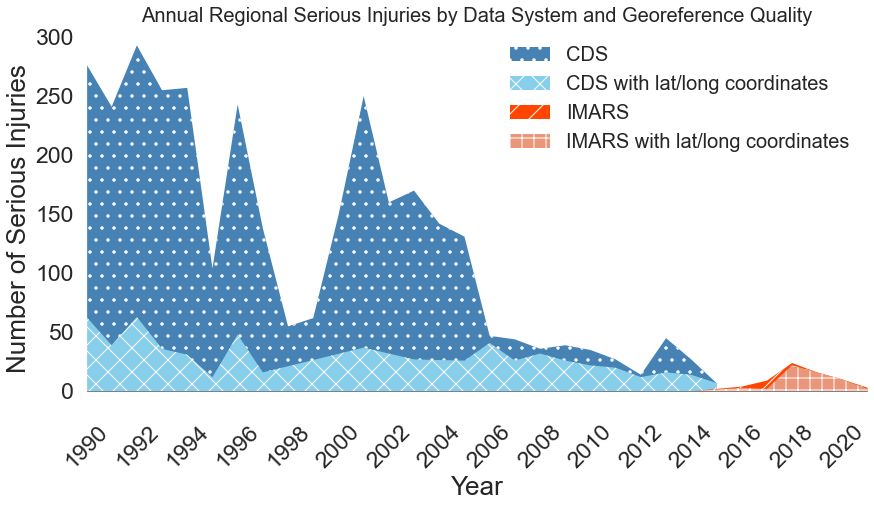

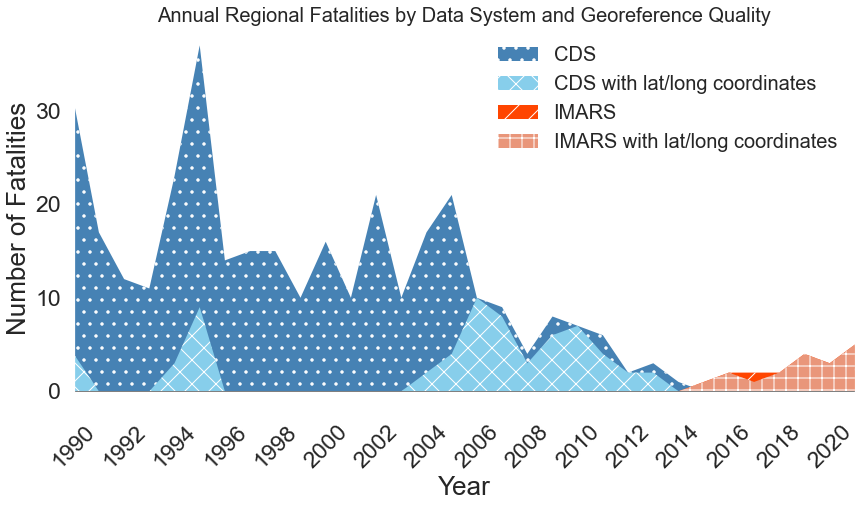

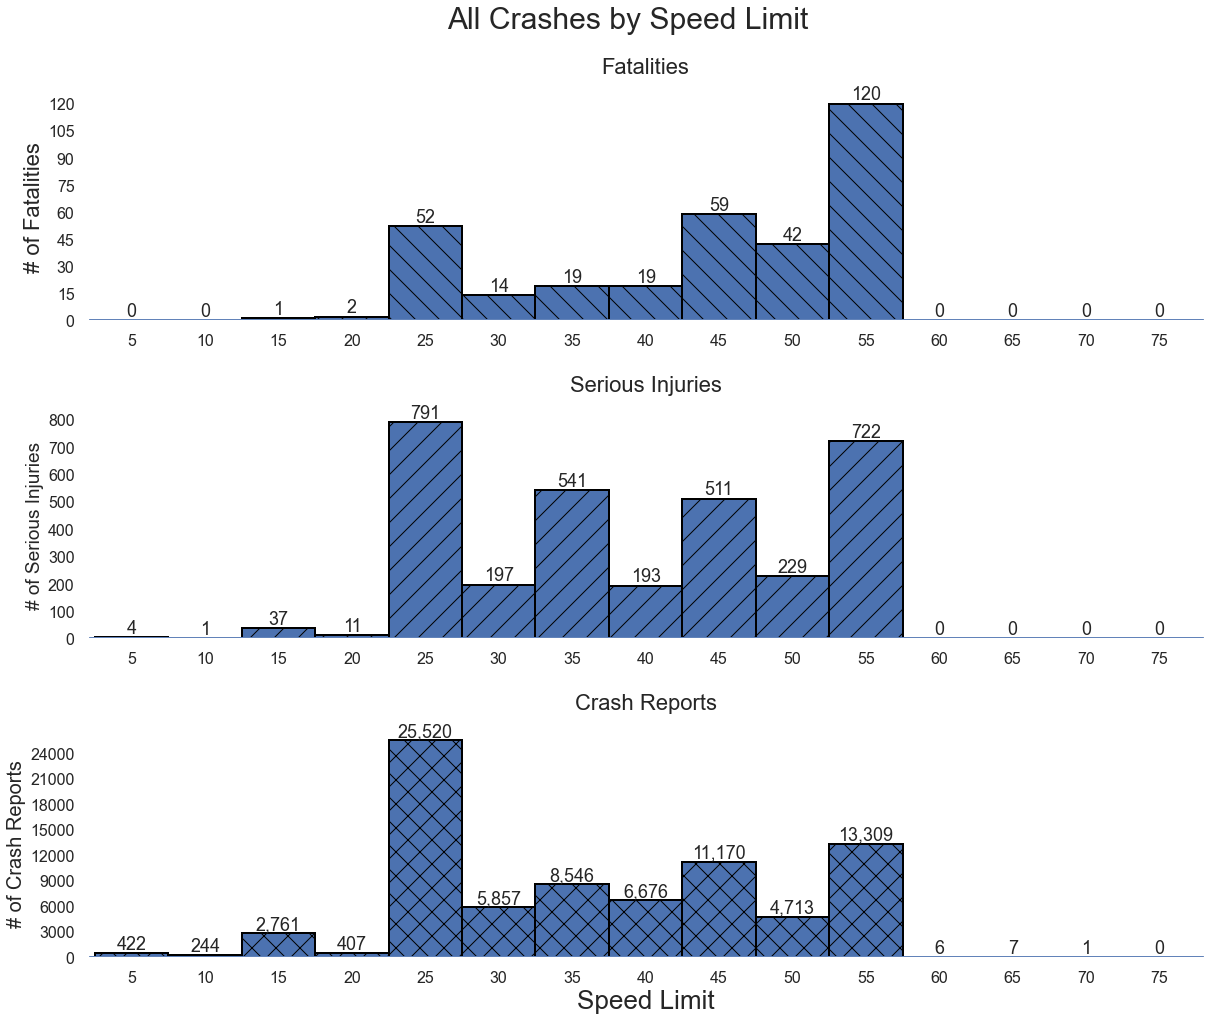

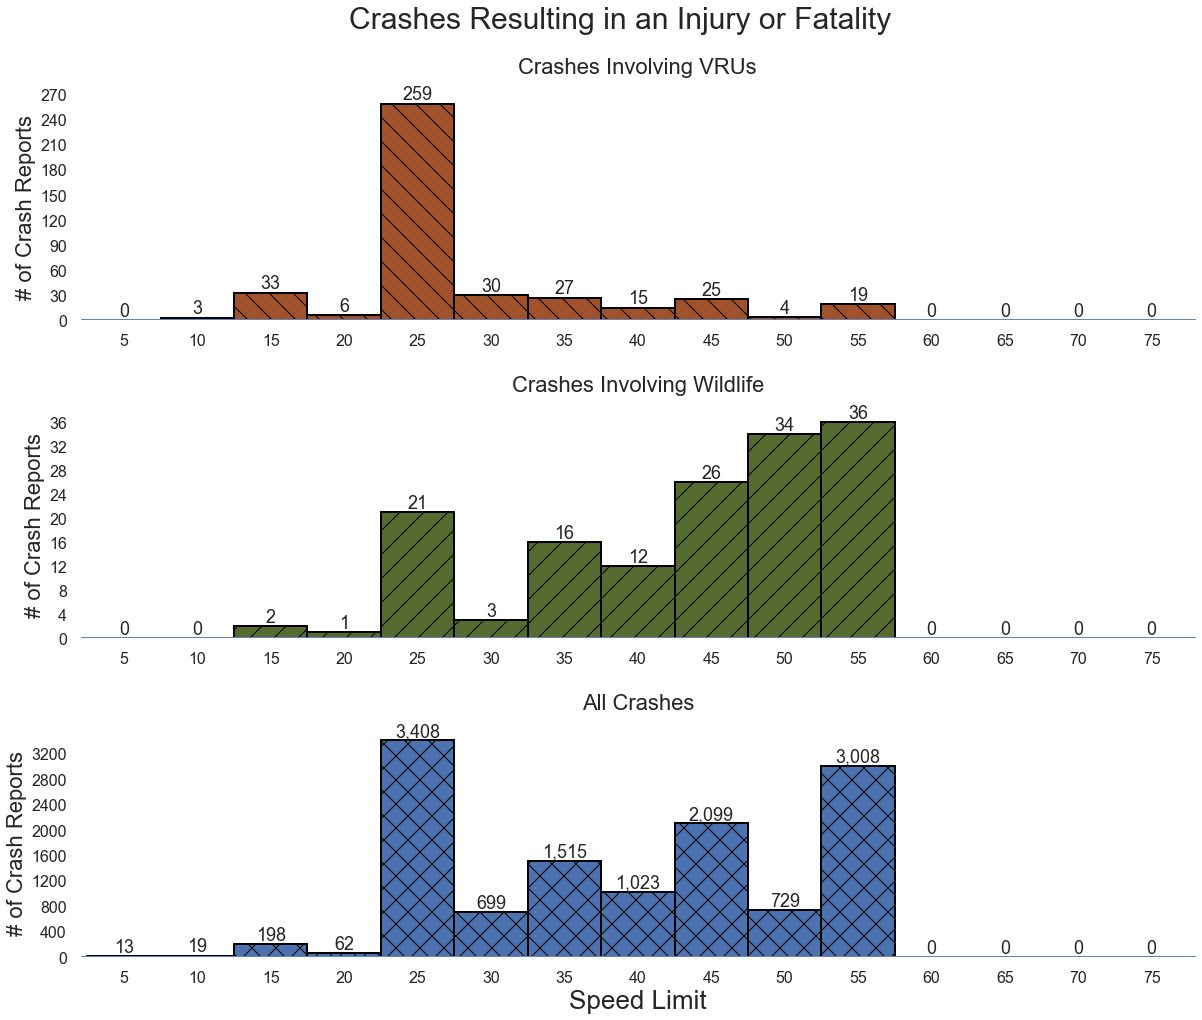

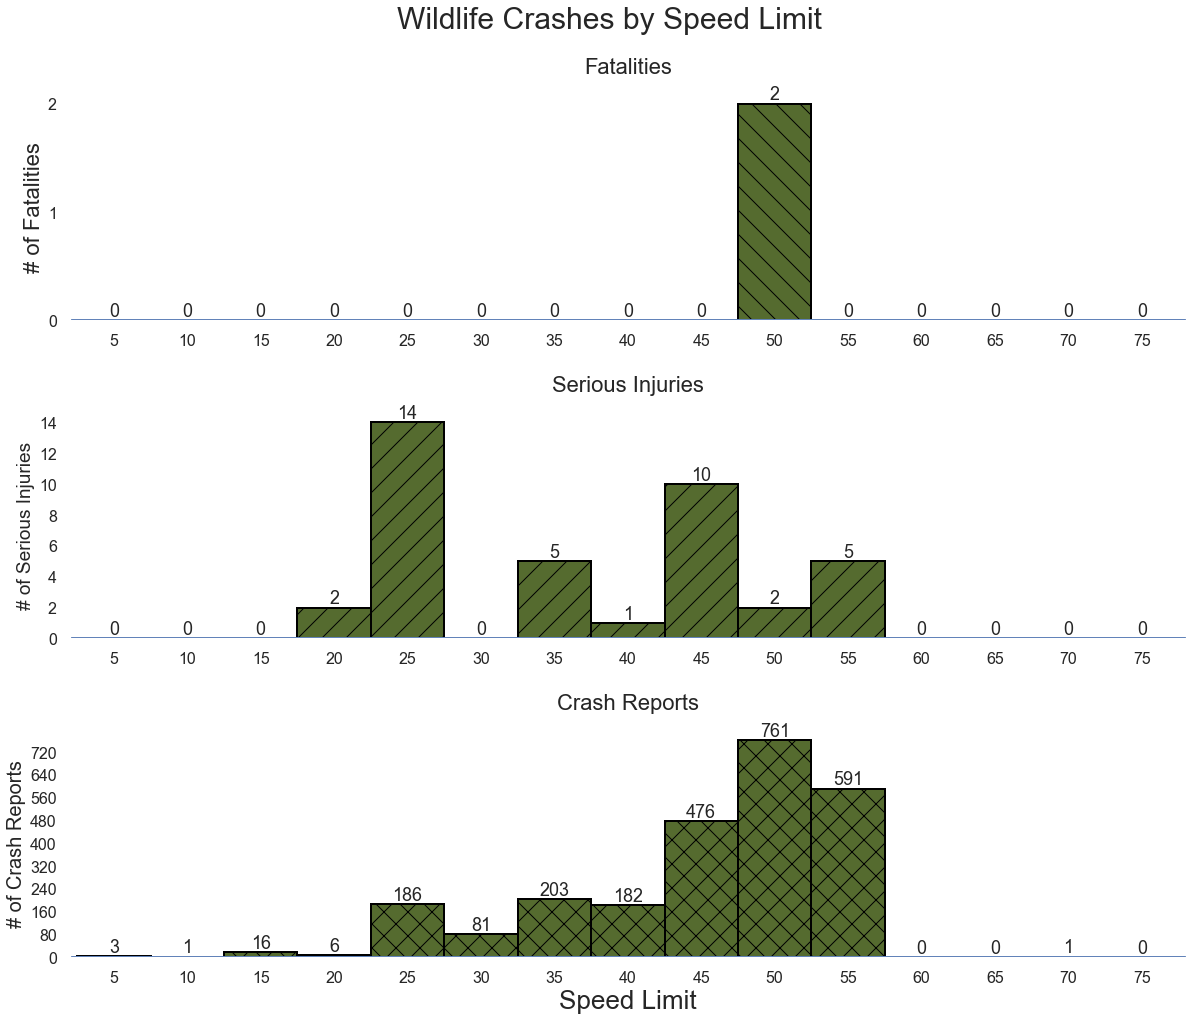

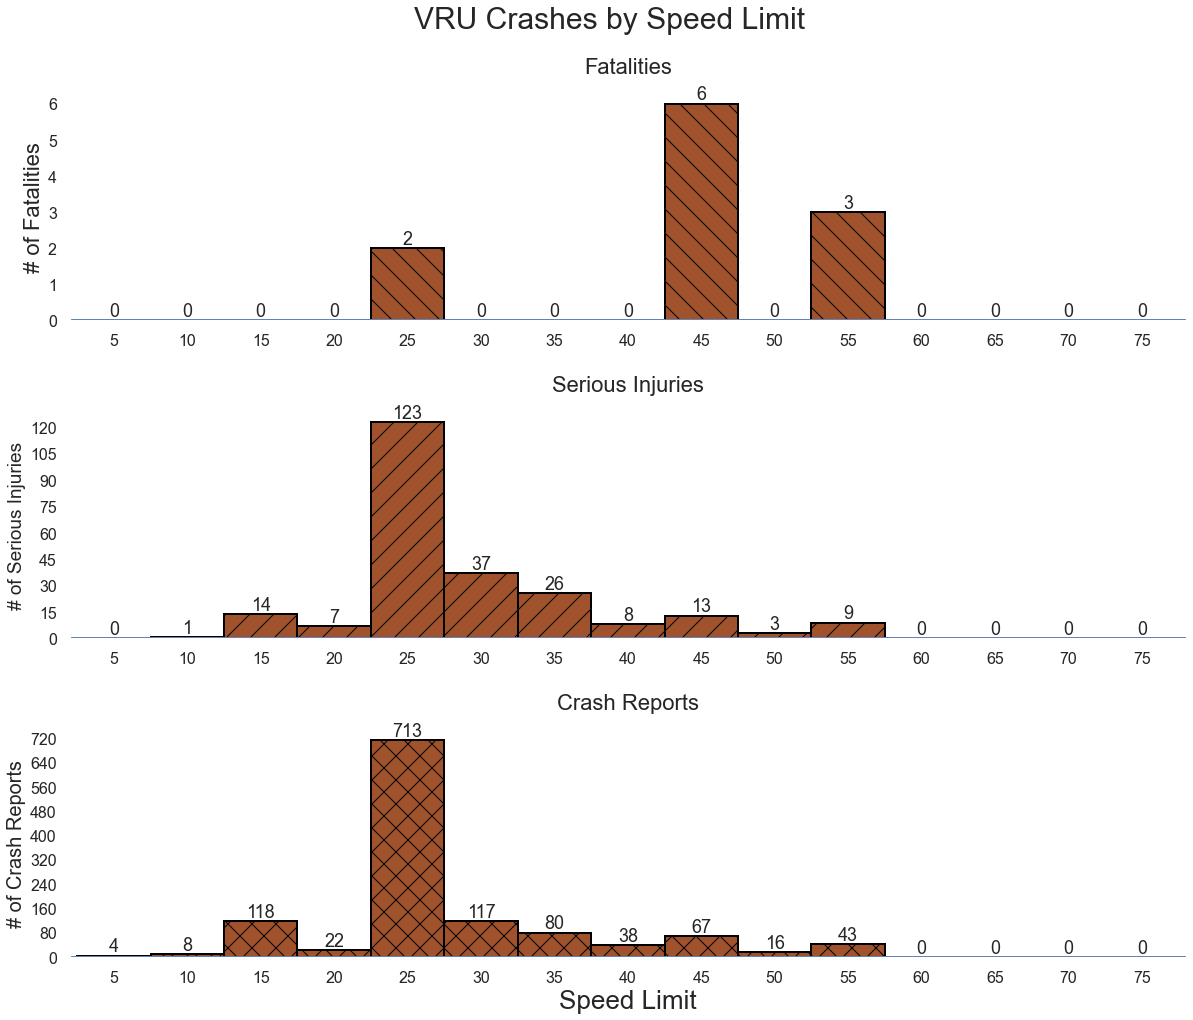

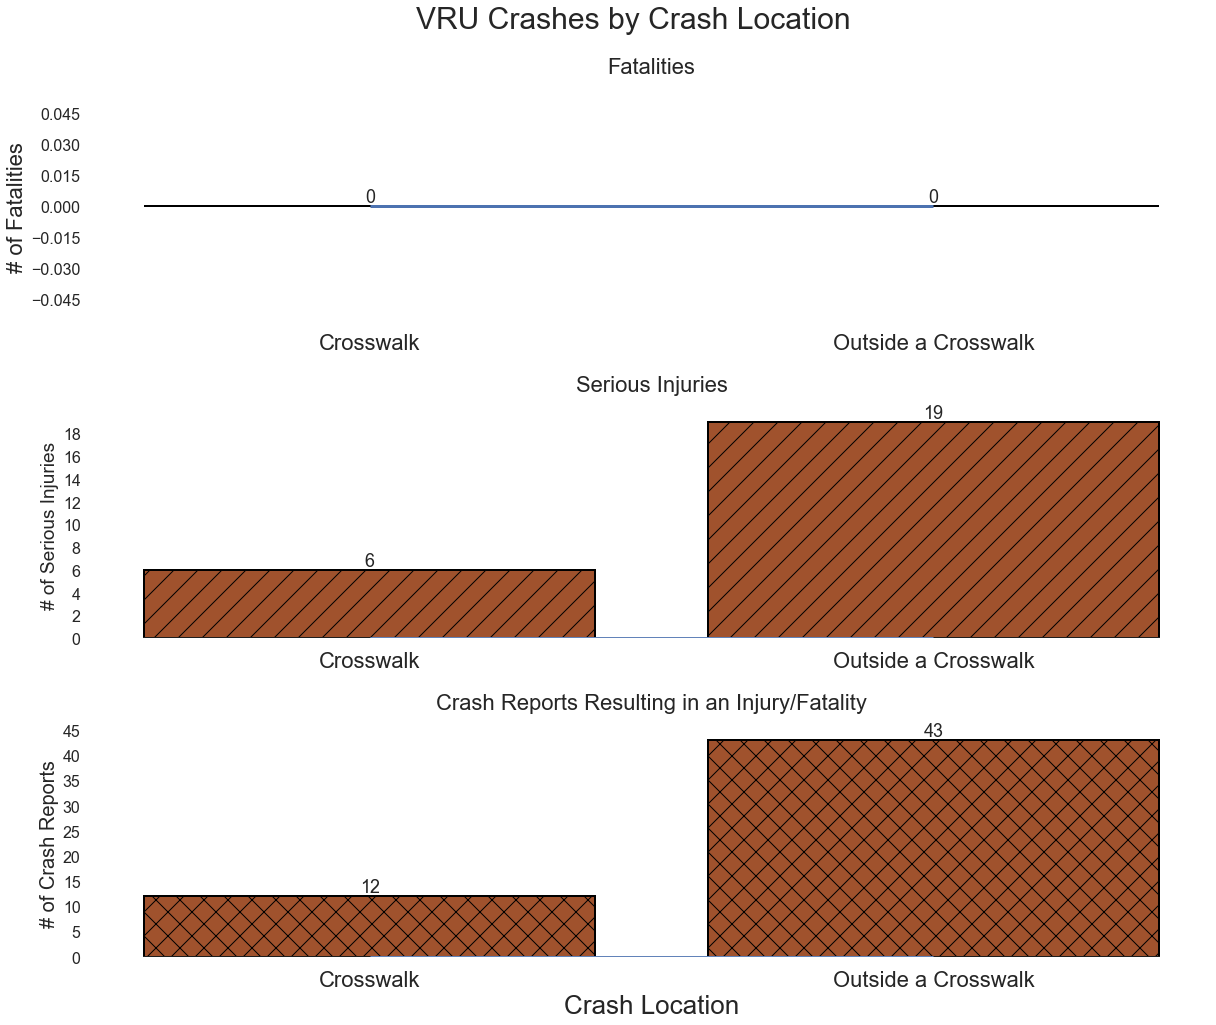

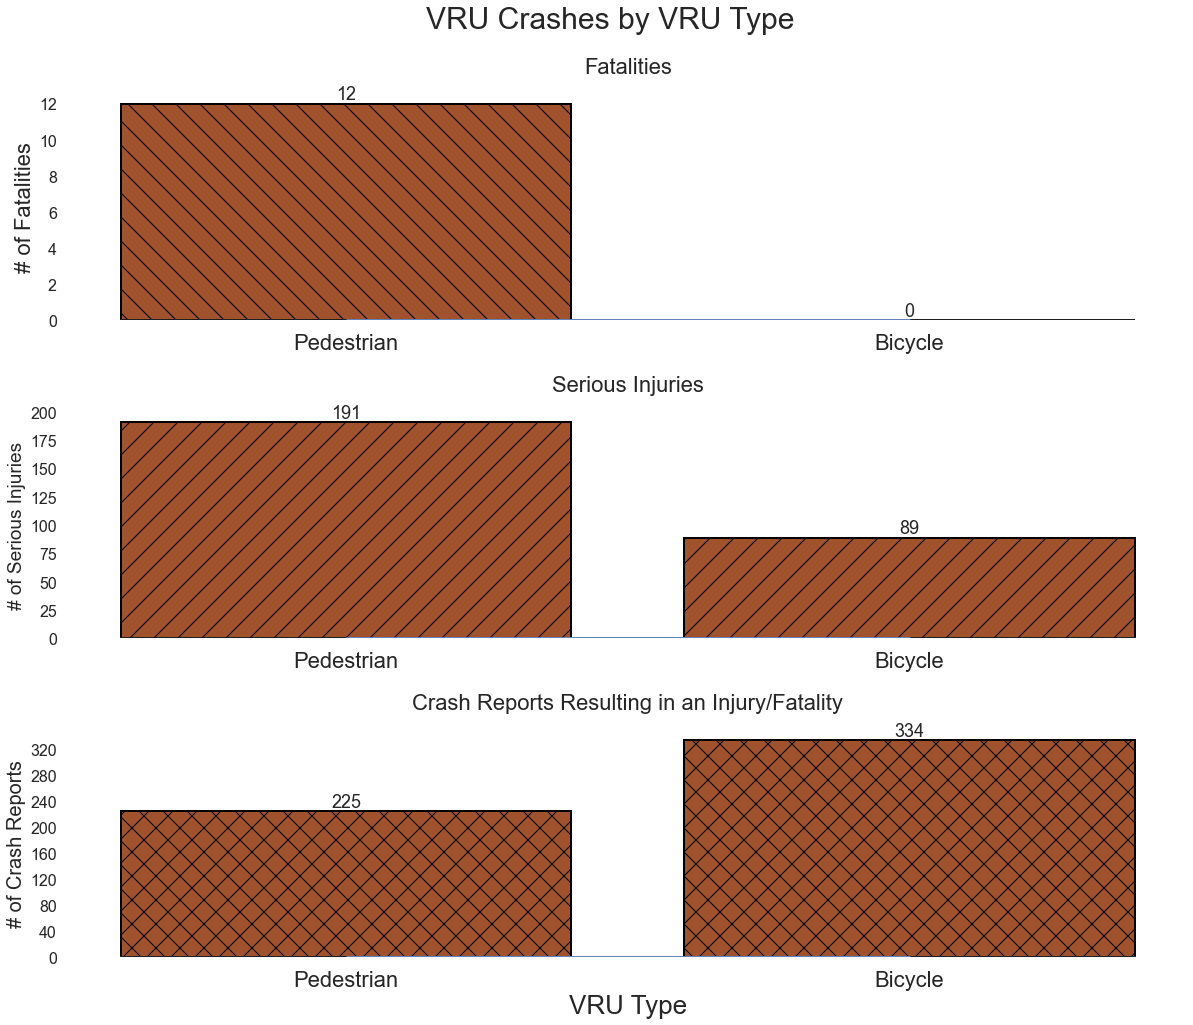

In [103]:
add_regional_information("NCR")

SER


<ipython-input-61-c77326561c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1


NER


<ipython-input-61-c77326561c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1


MWR


<ipython-input-61-c77326561c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1
<ipython-input-80-9842ae15d63d>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(3,1,figsize=(20,15))


IMR


<ipython-input-61-c77326561c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1


NCR


<ipython-input-61-c77326561c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1


PWR


<ipython-input-61-c77326561c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1


AKR


<ipython-input-61-c77326561c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ones'] = 1


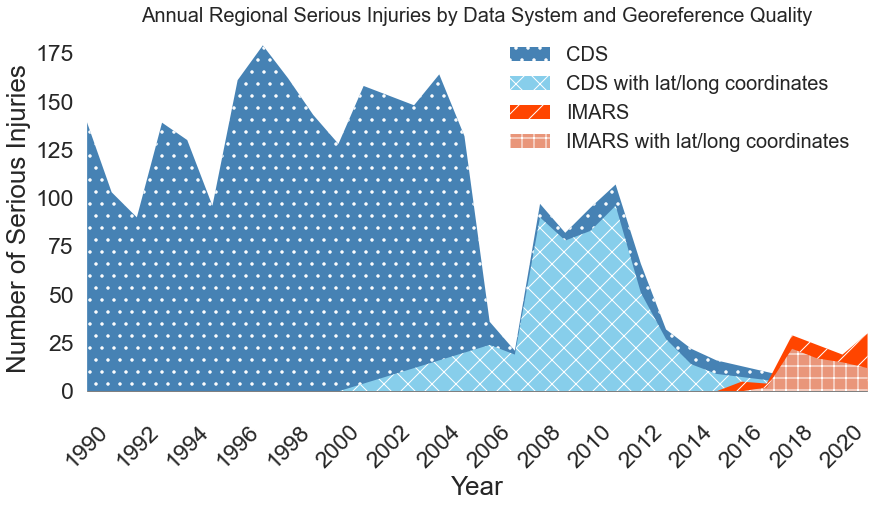

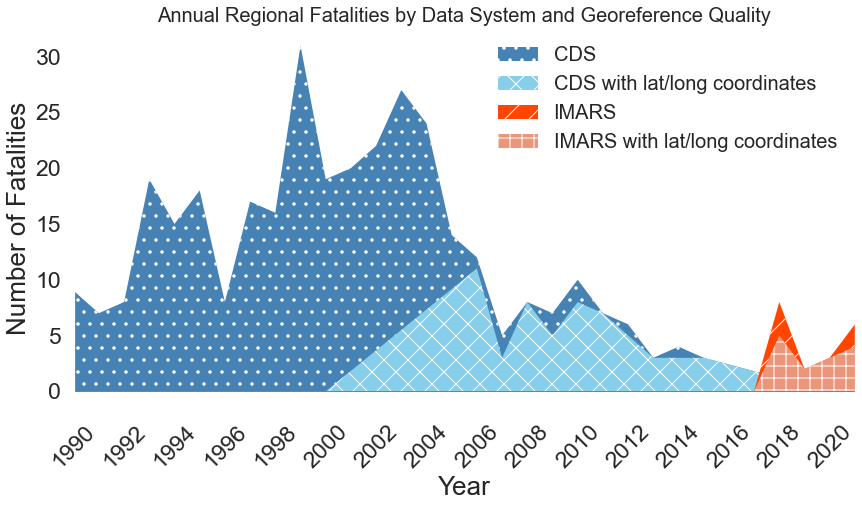

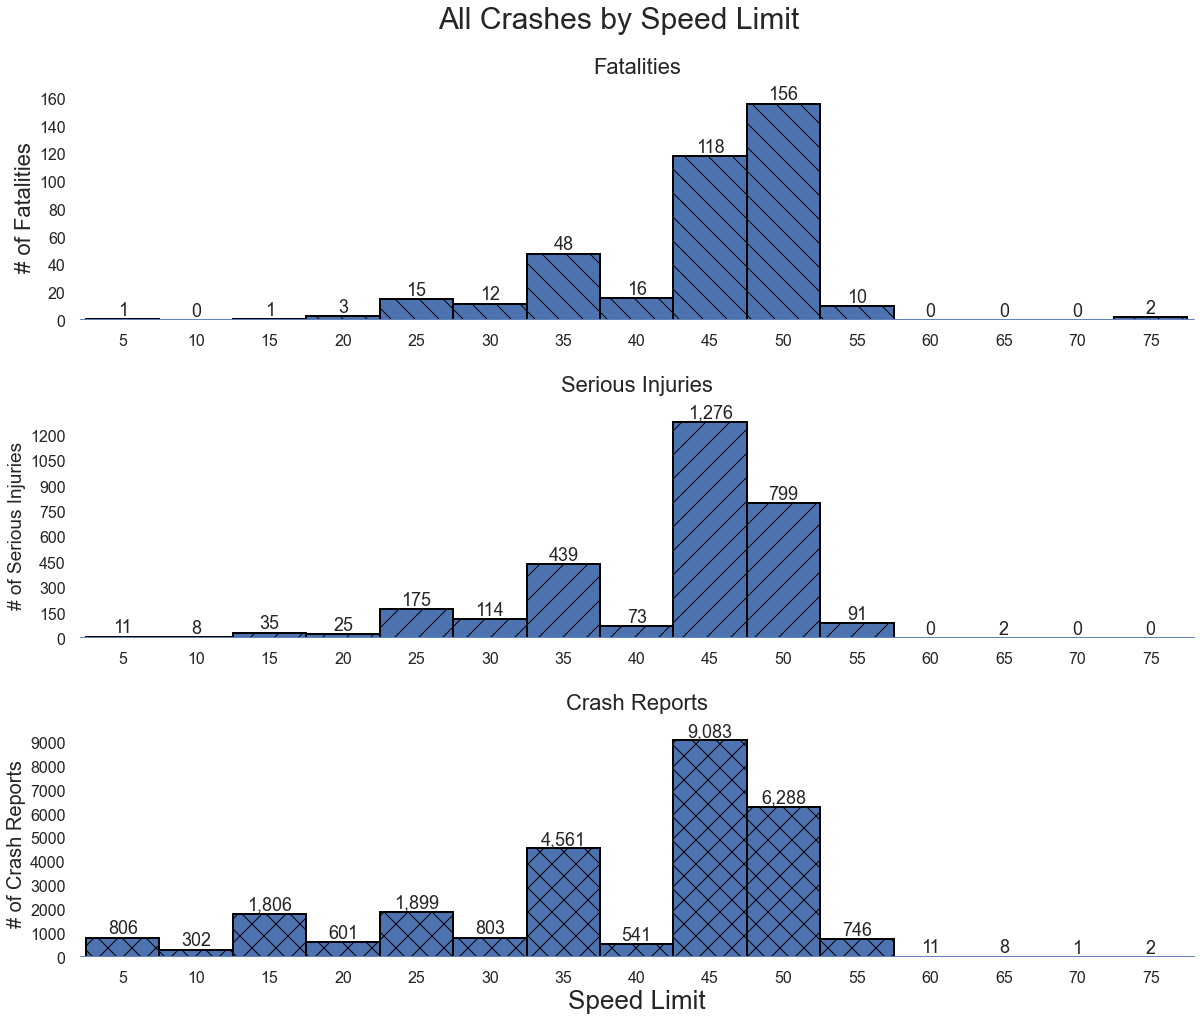

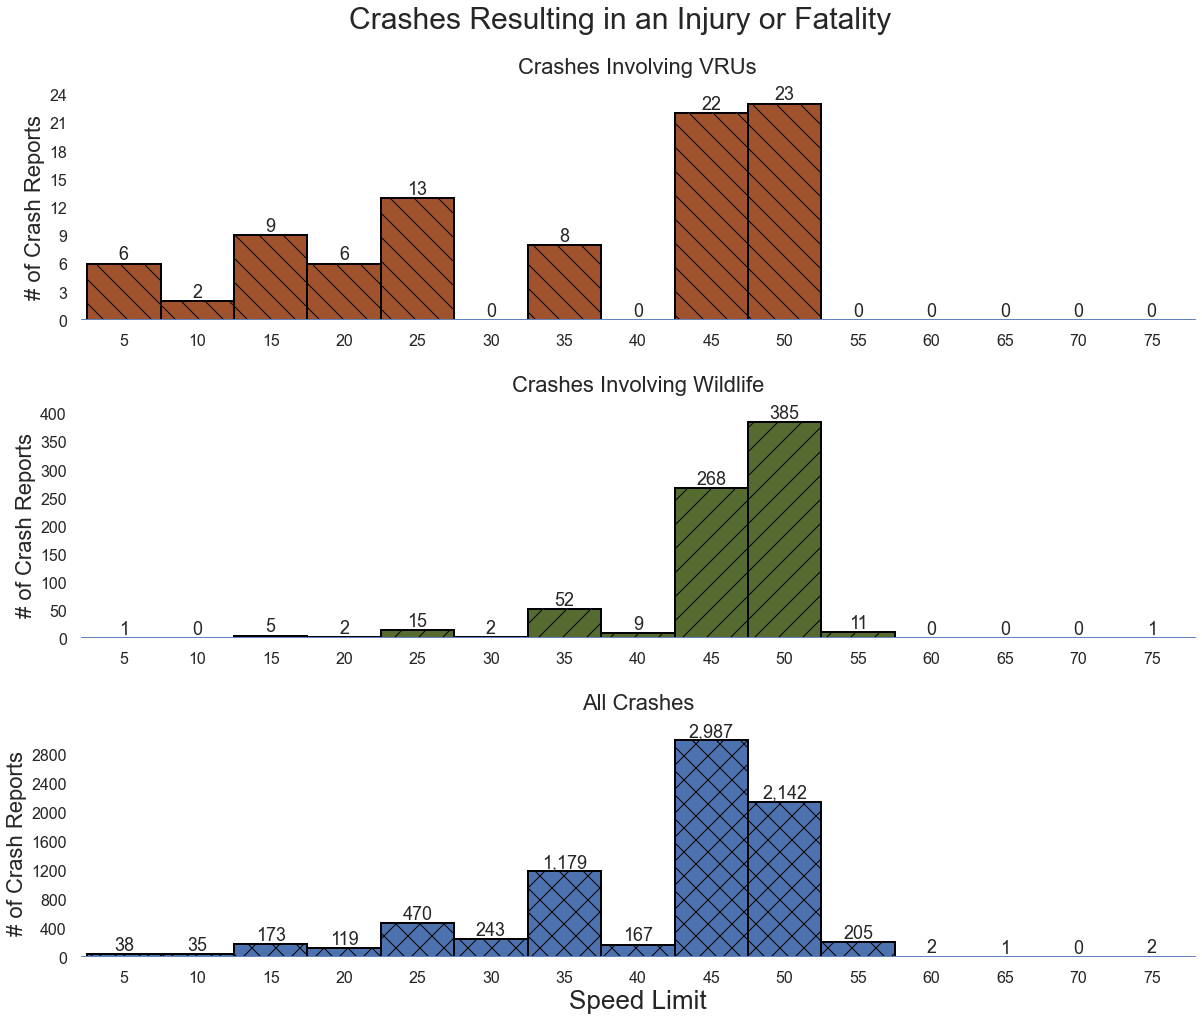

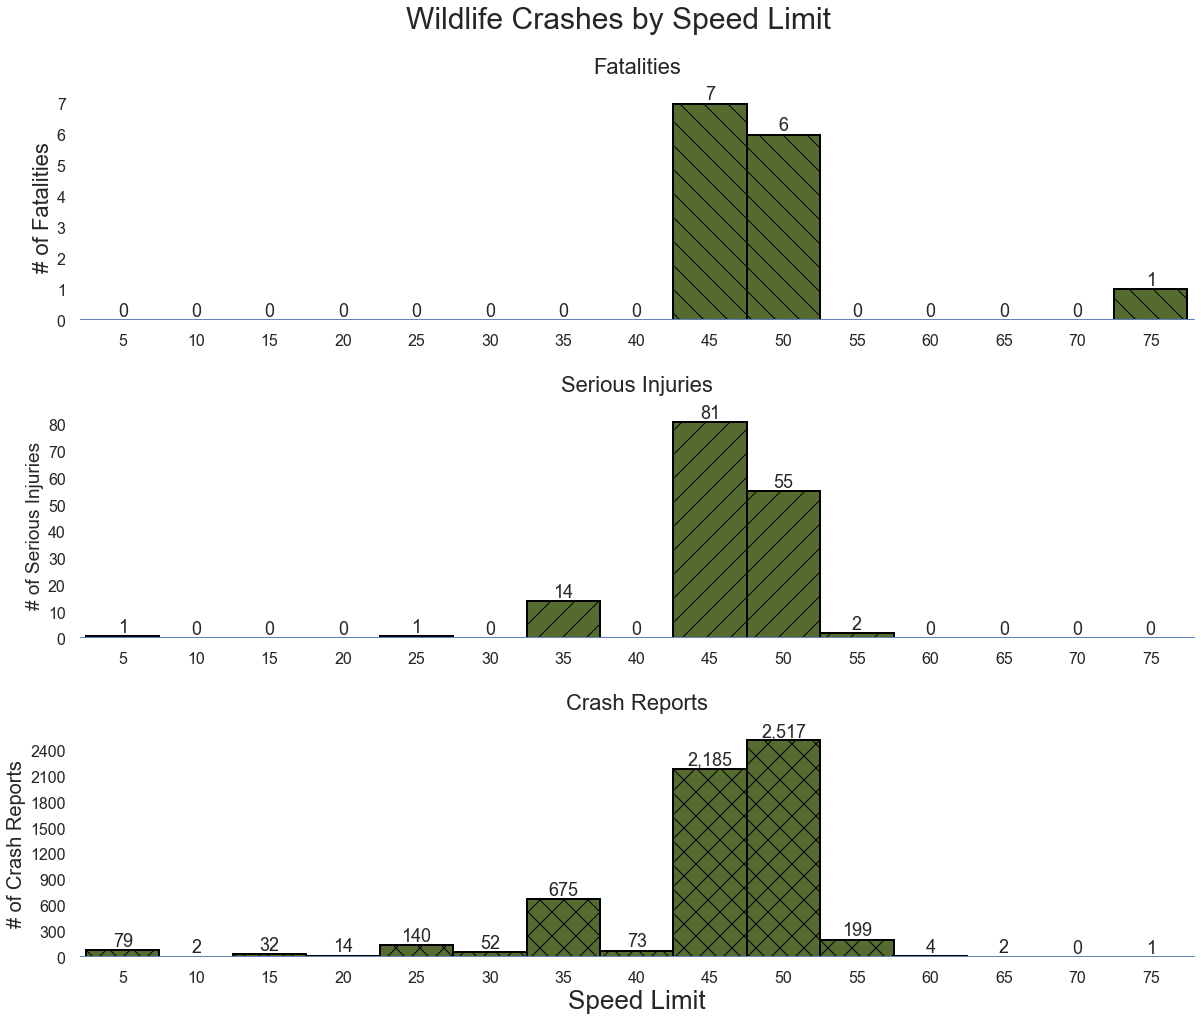

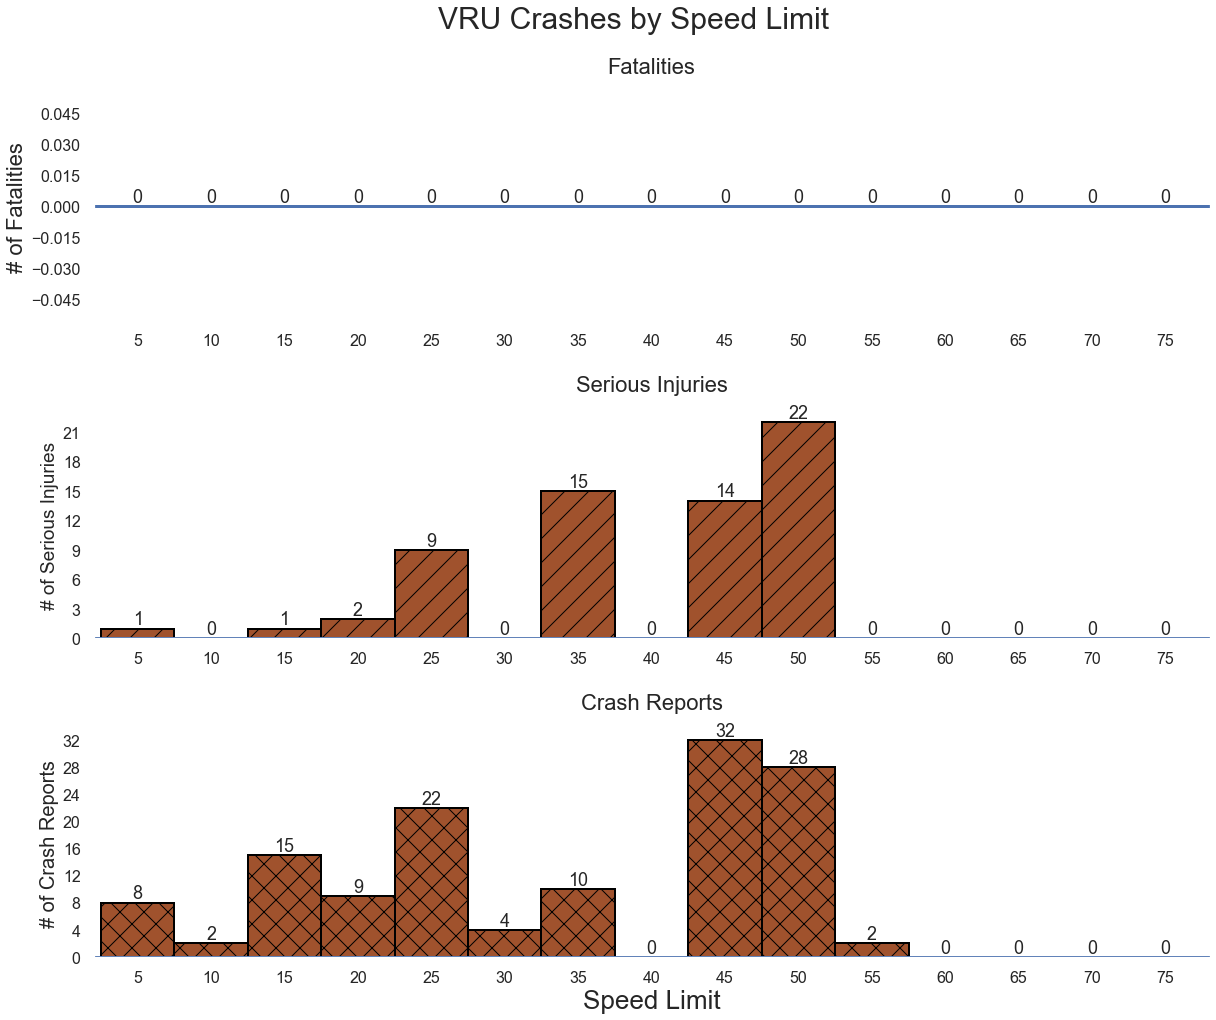

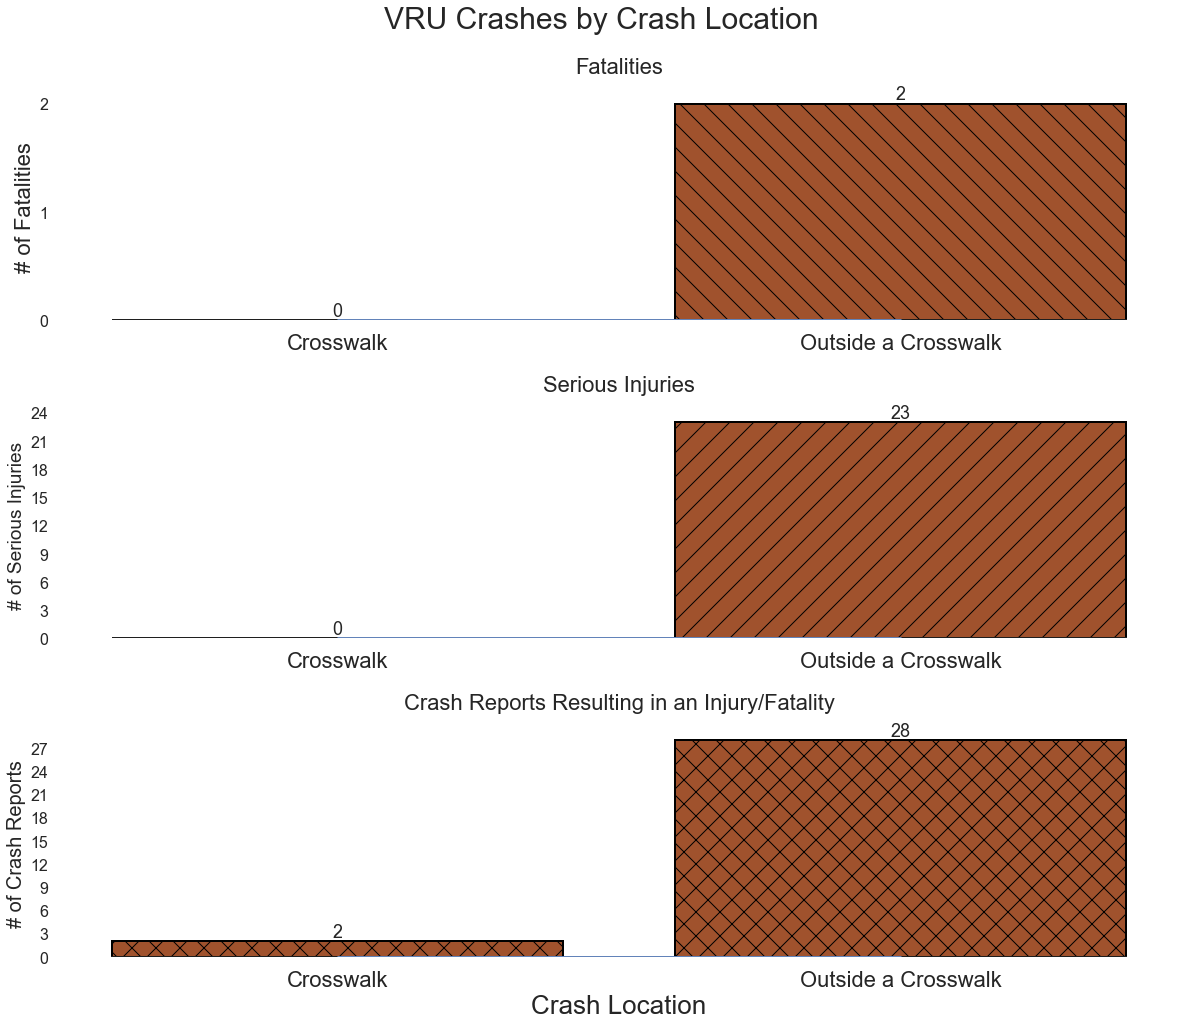

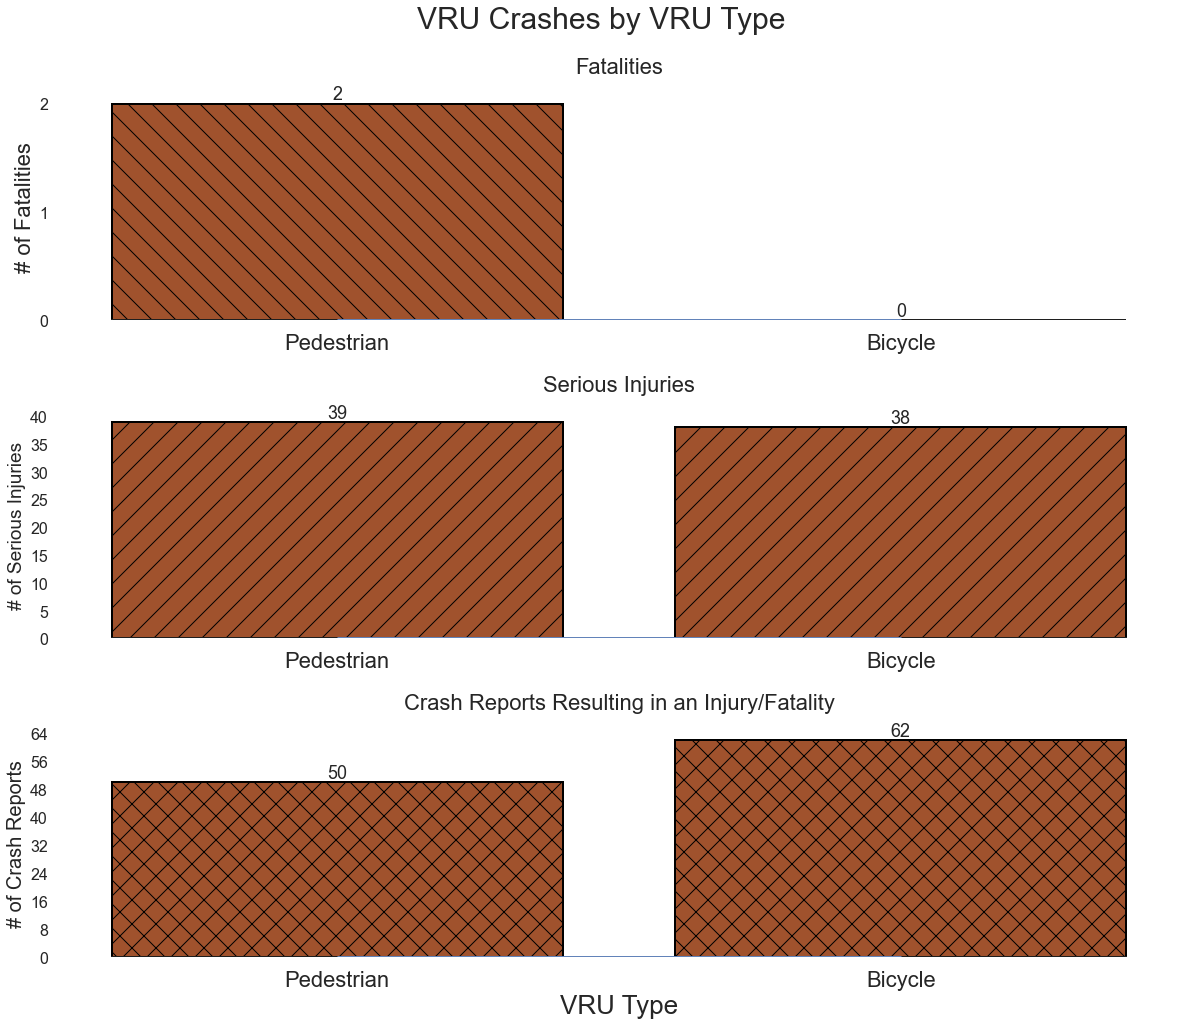

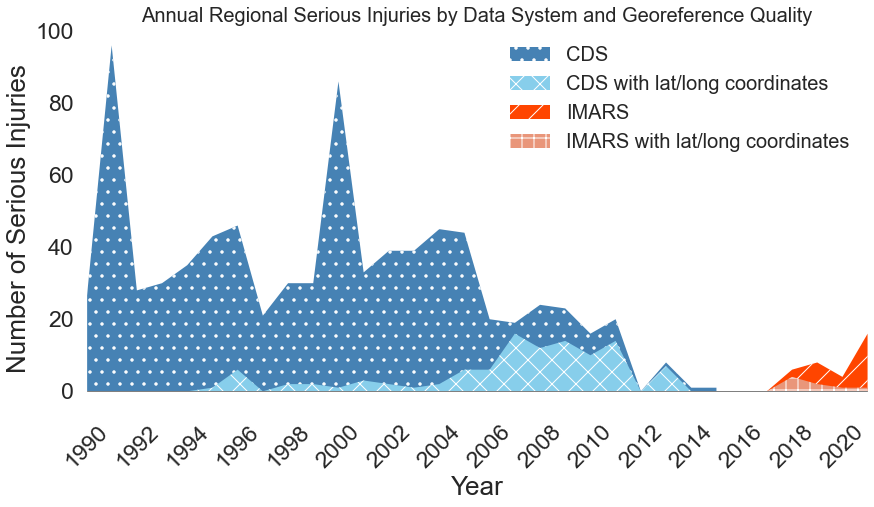

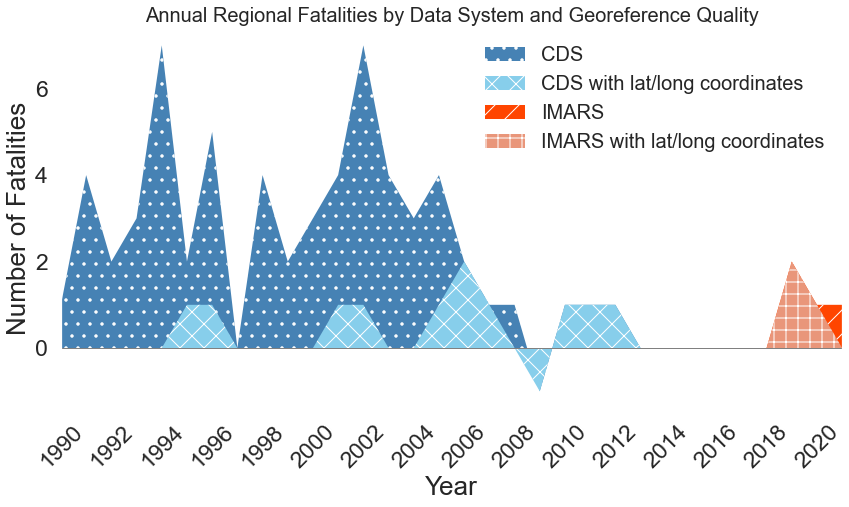

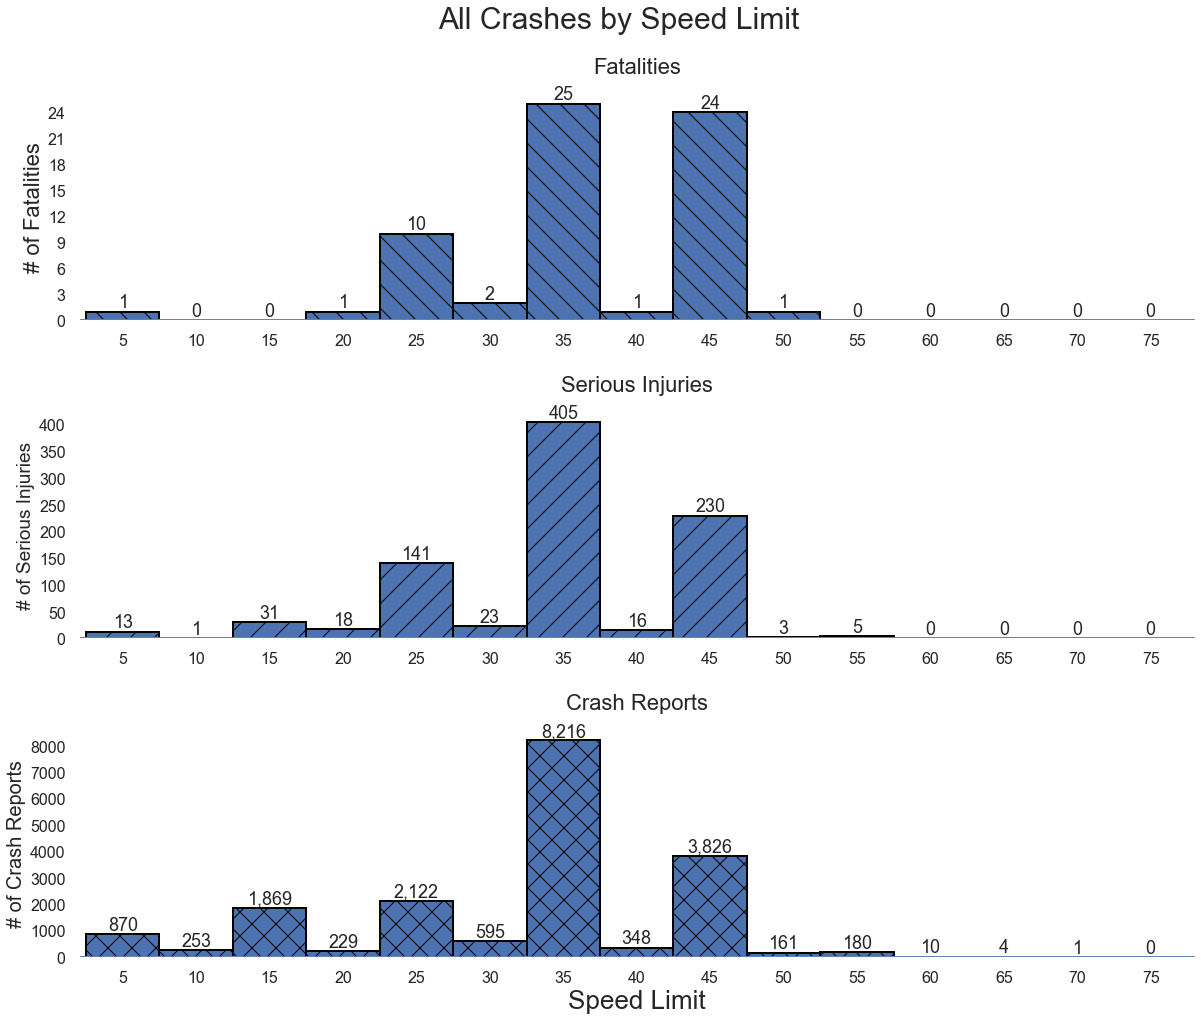

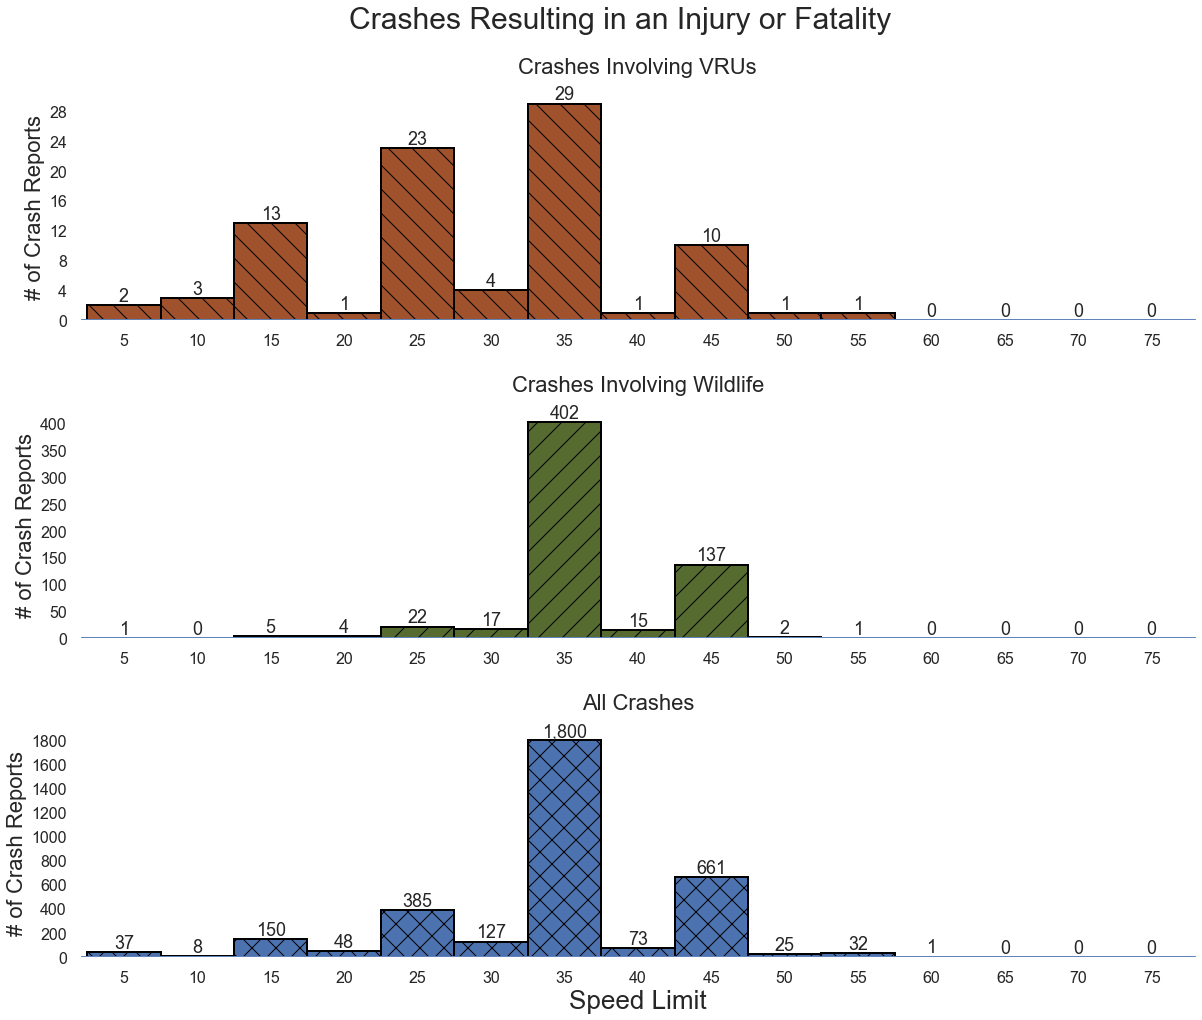

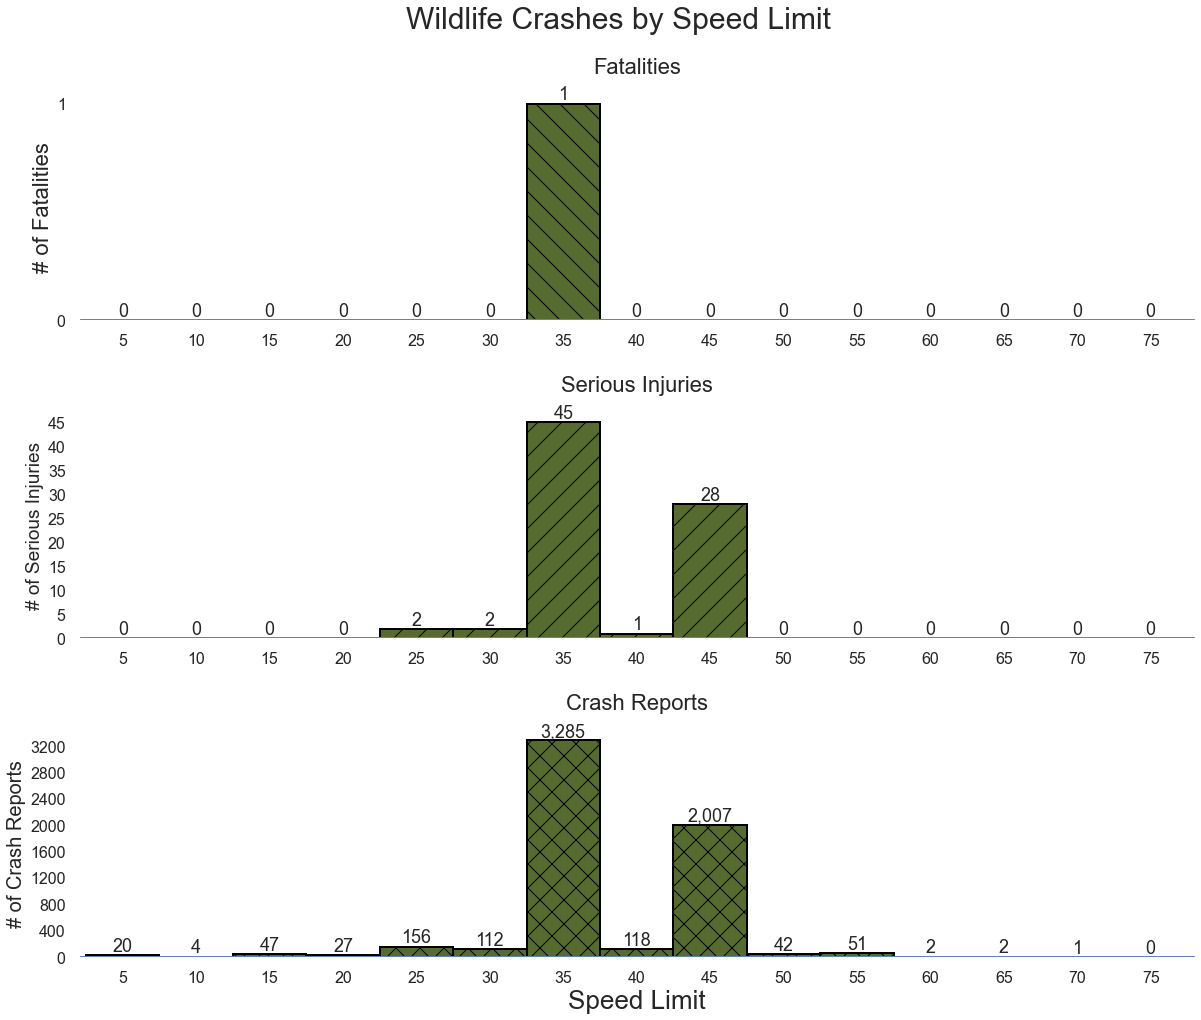

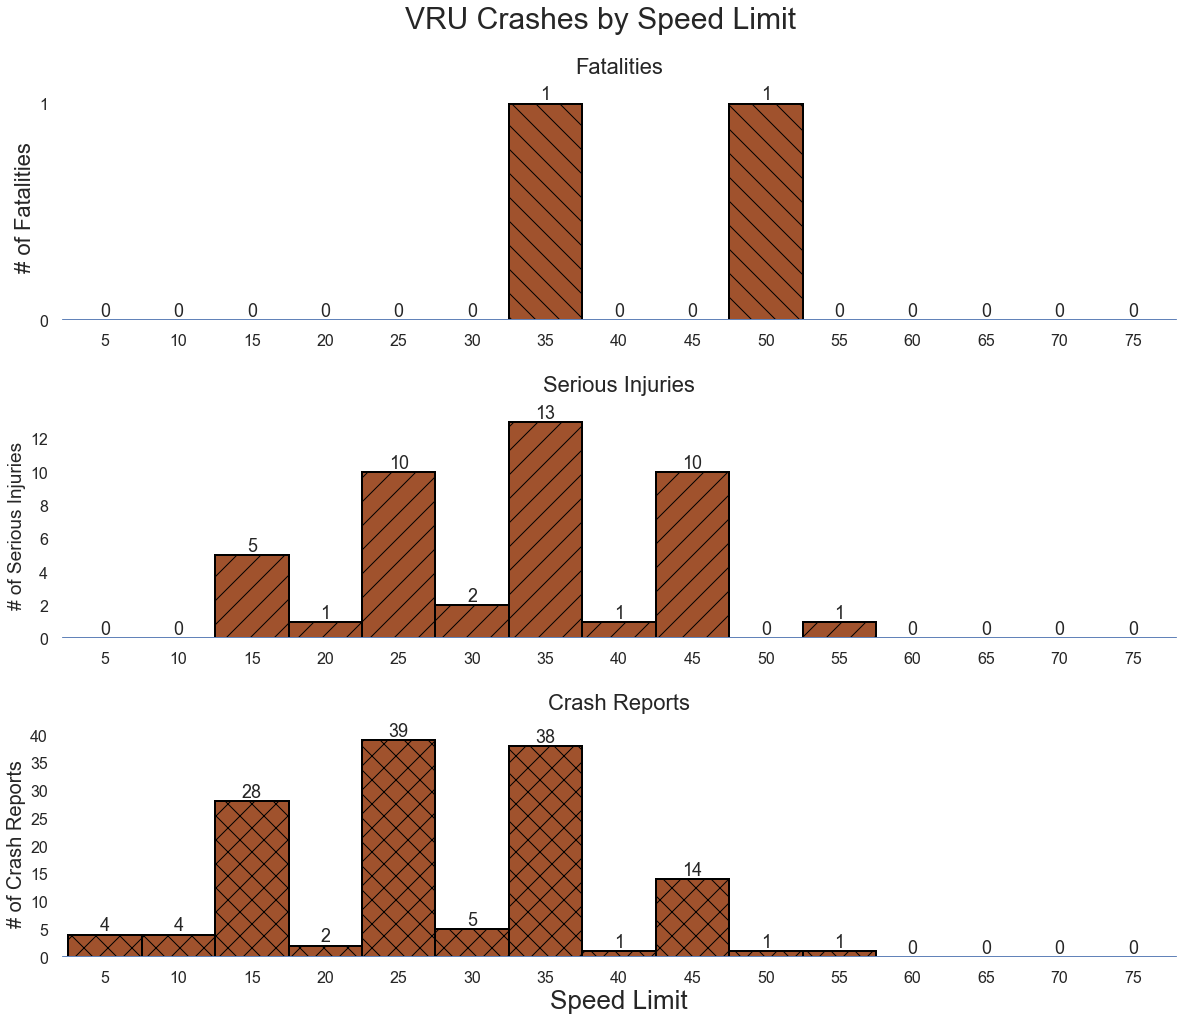

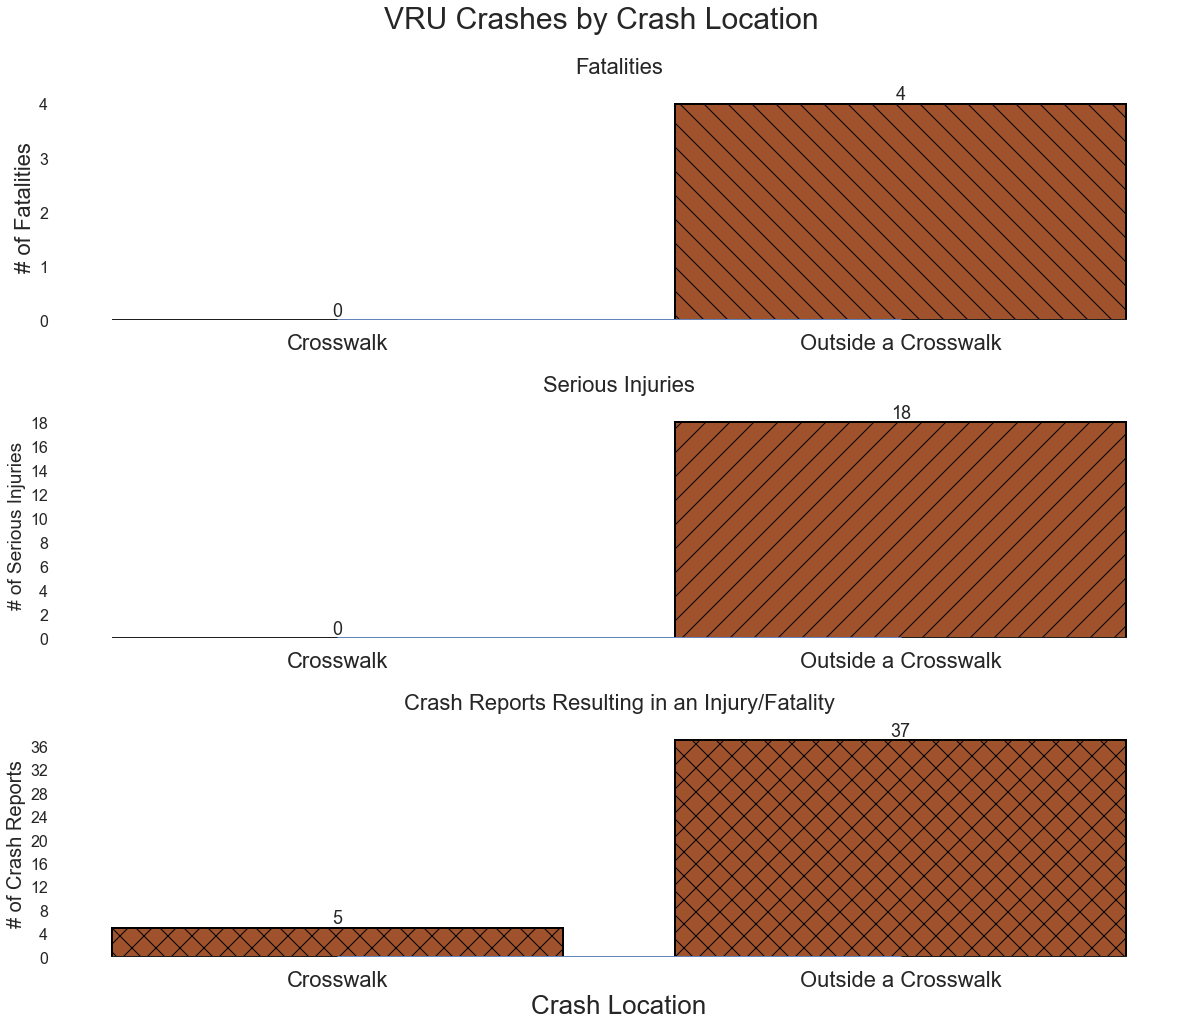

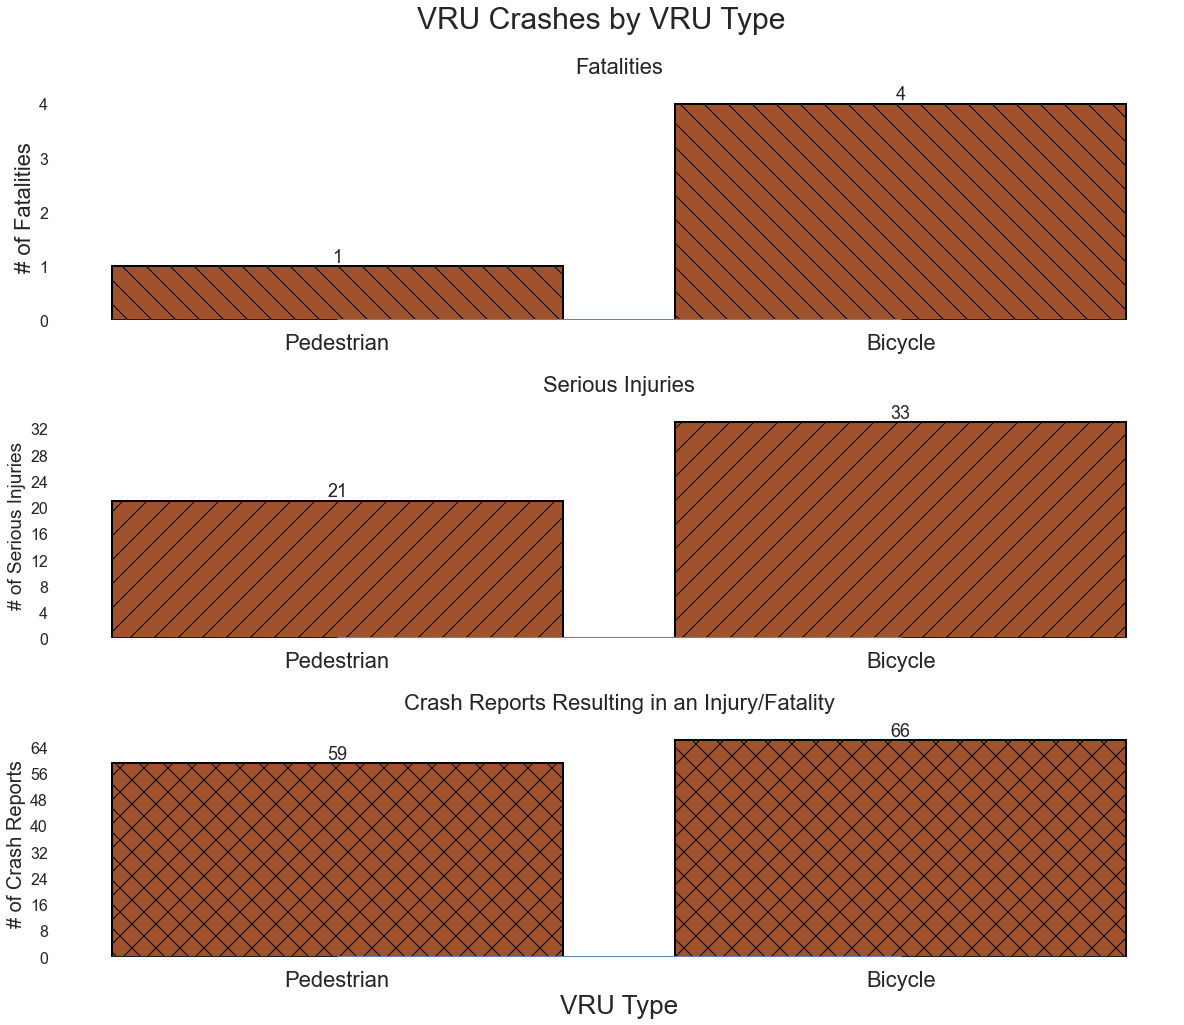

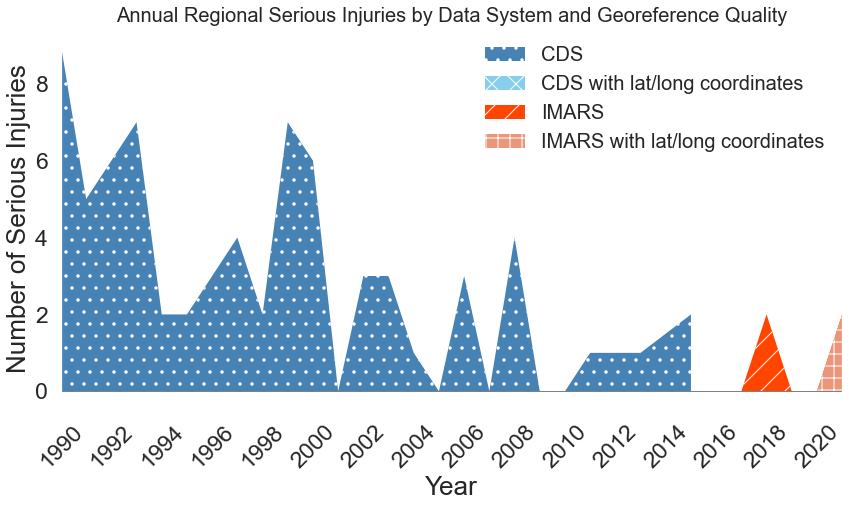

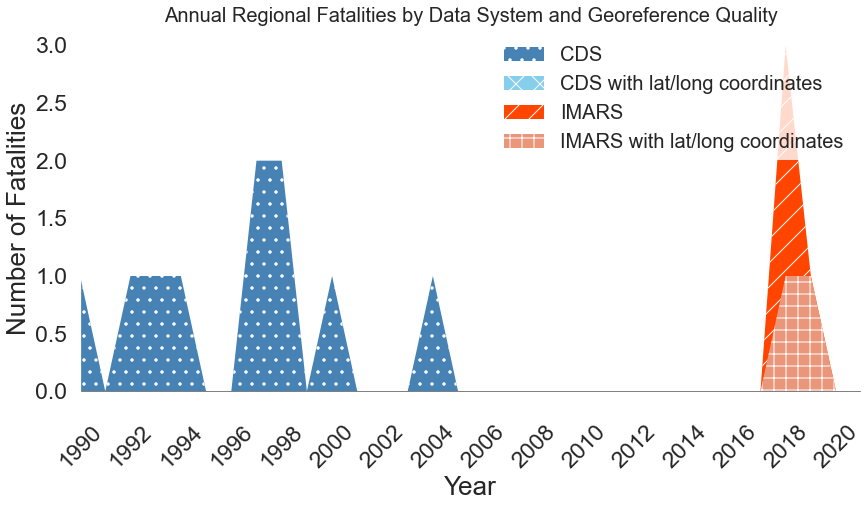

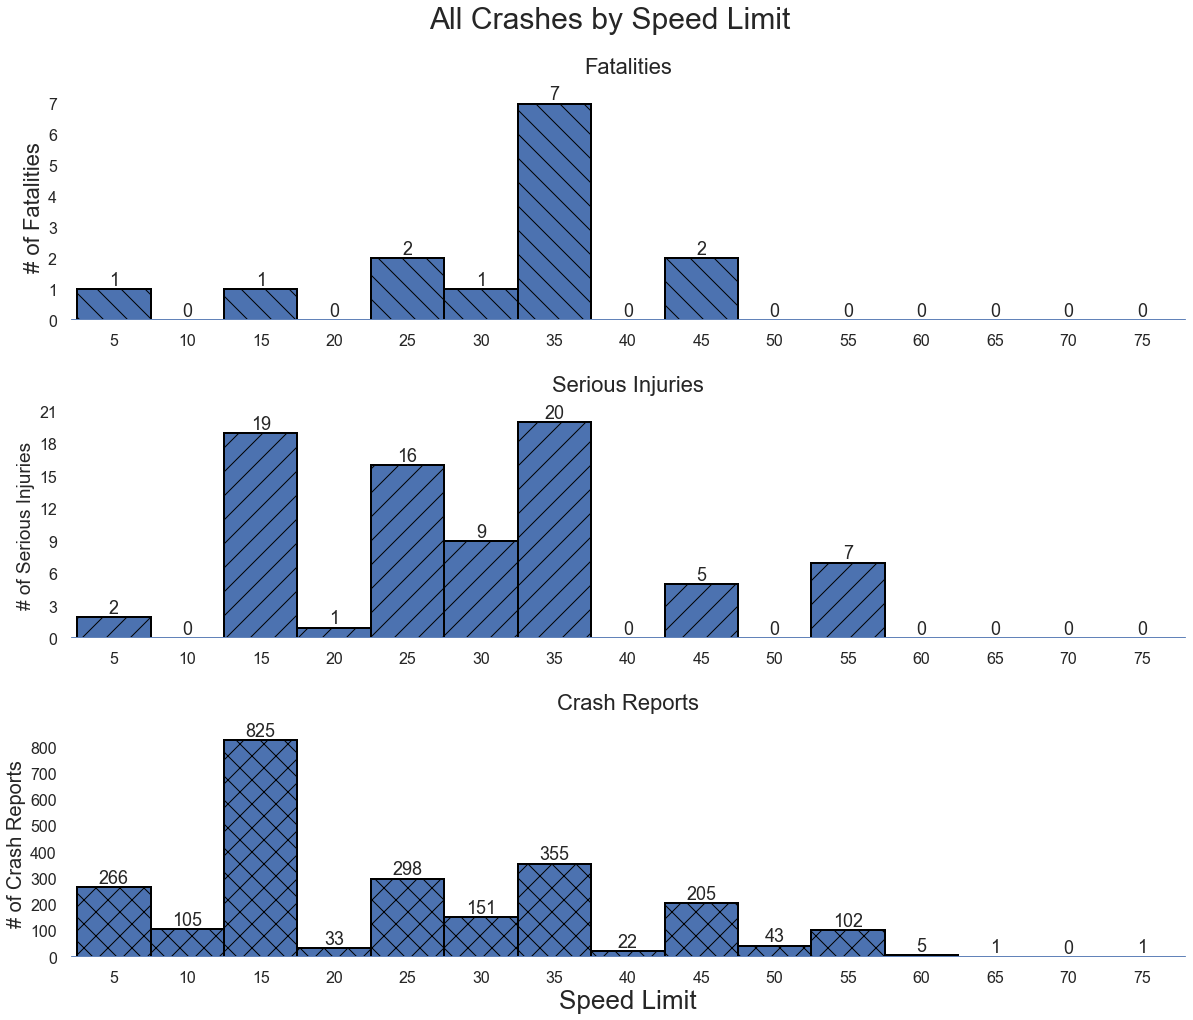

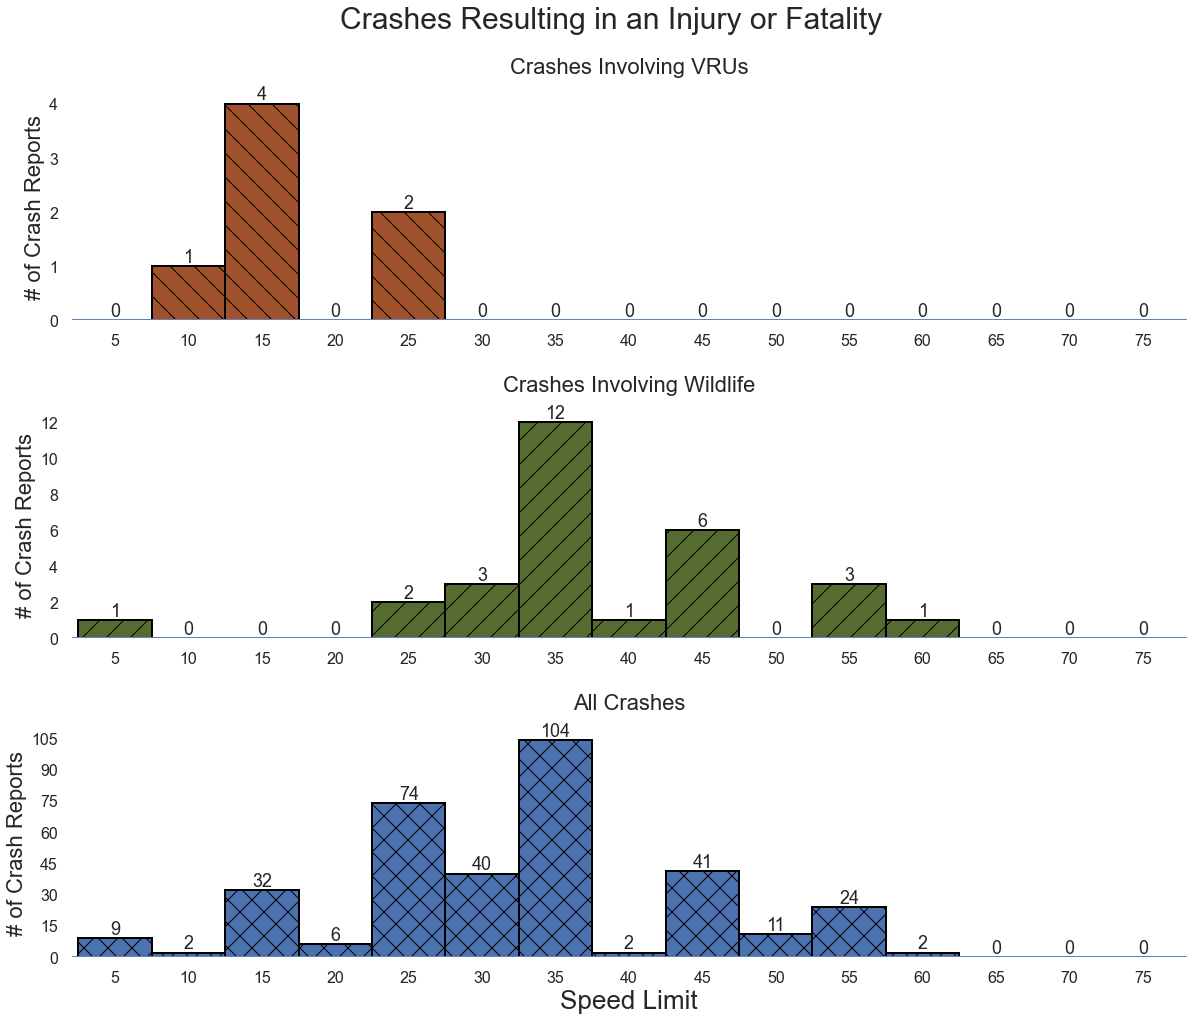

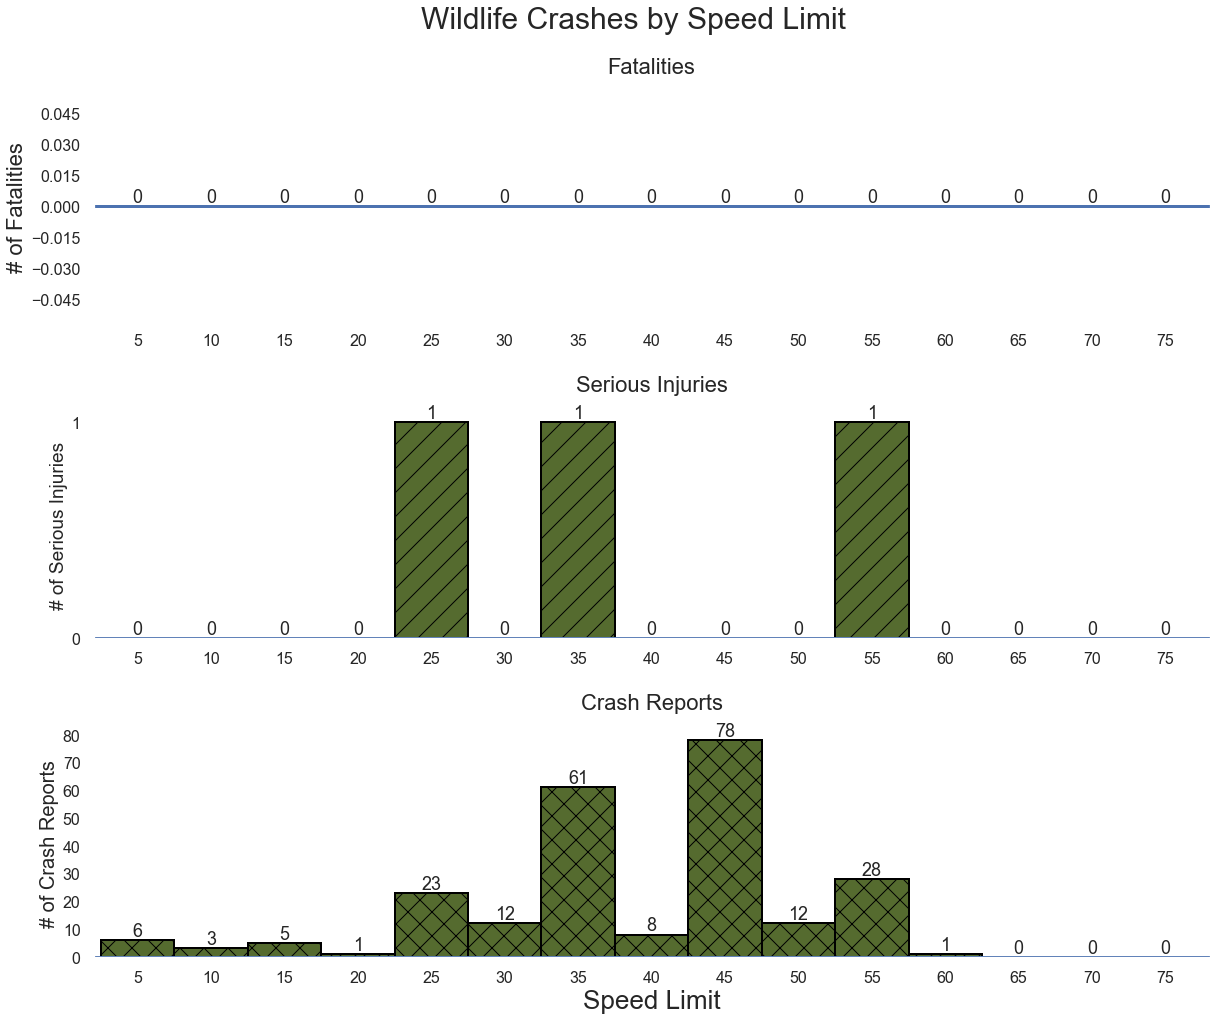

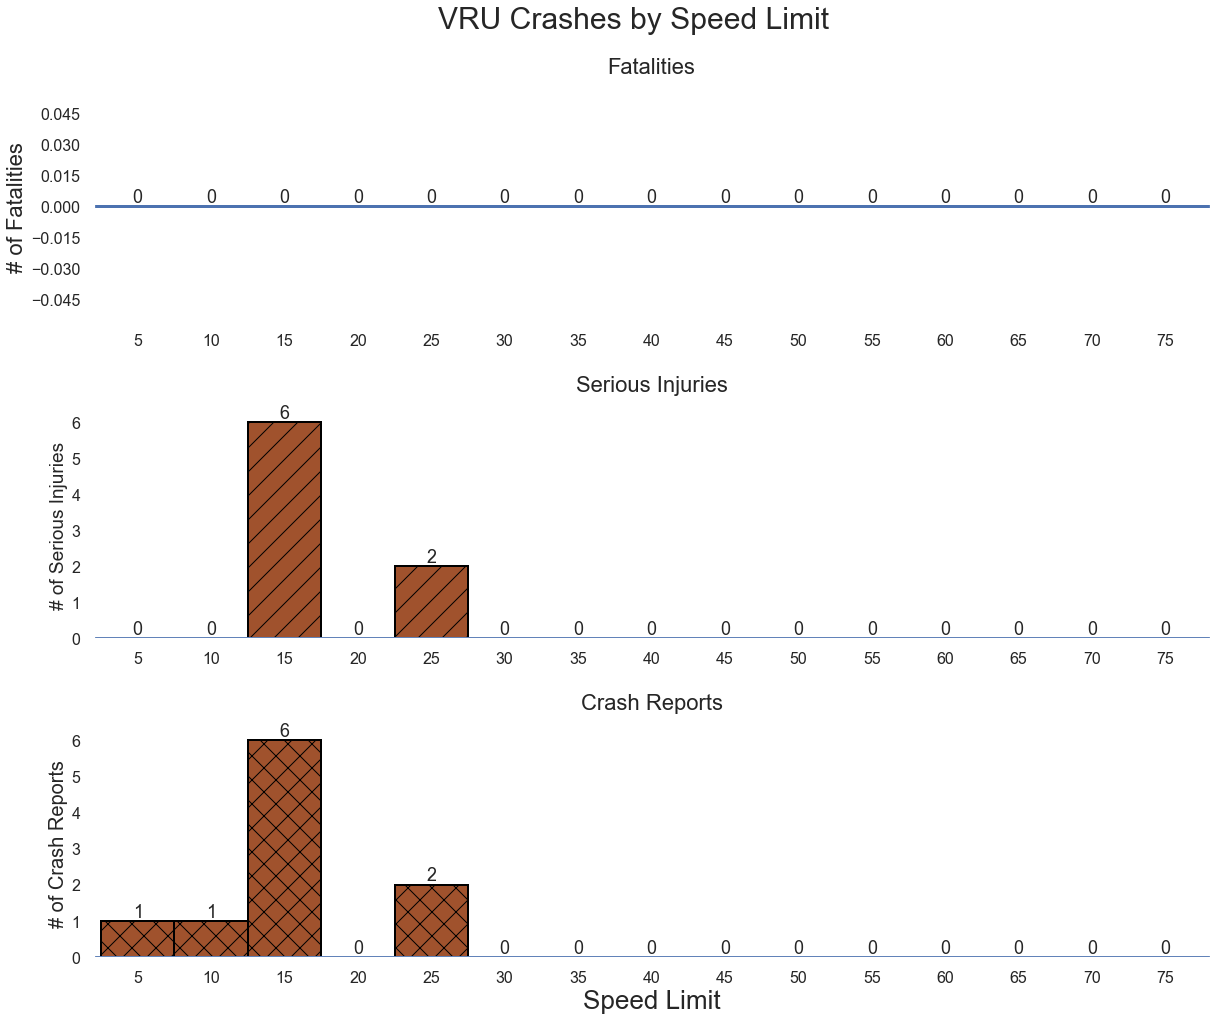

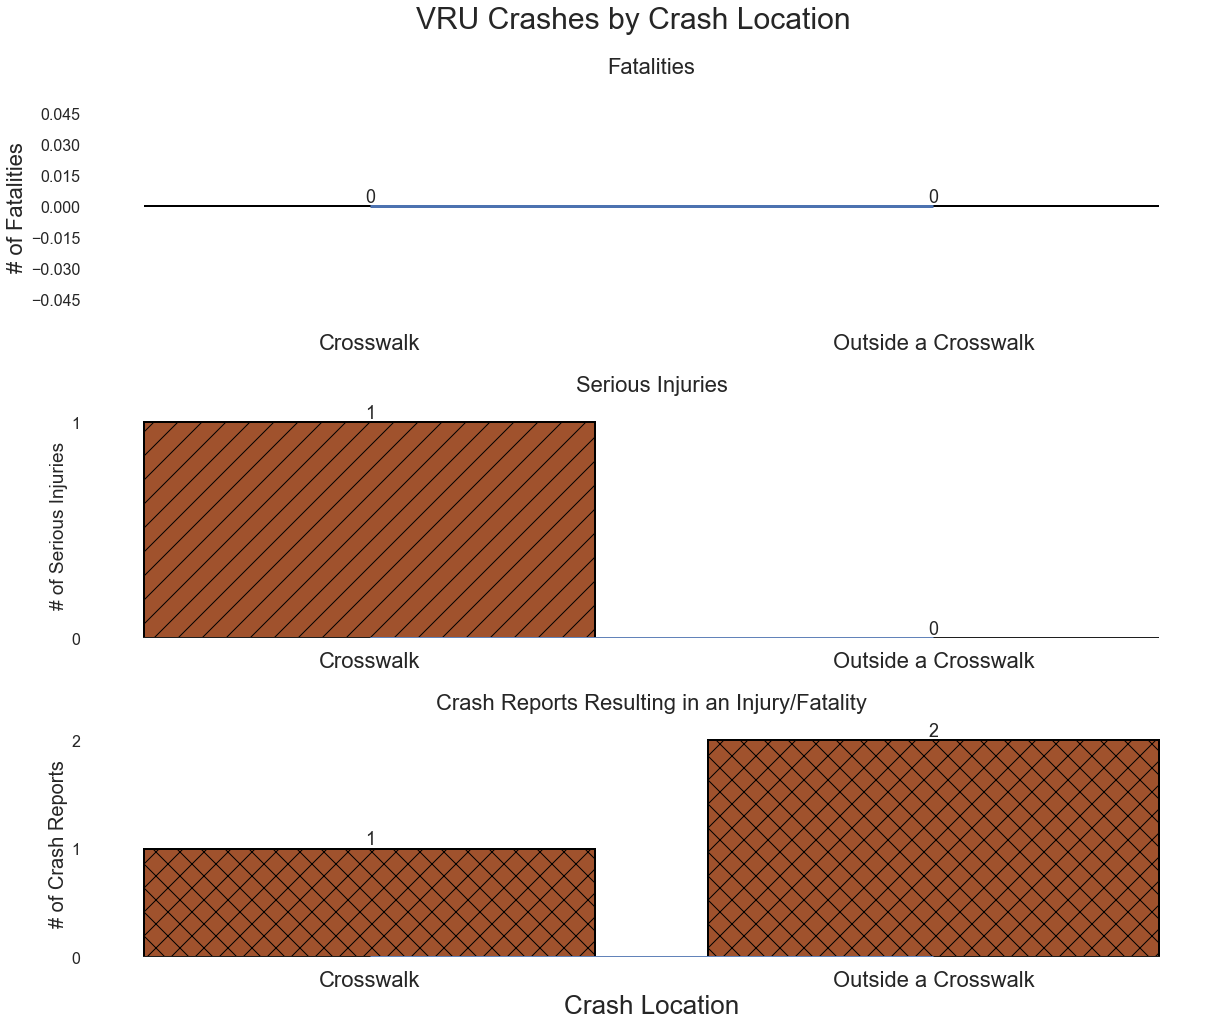

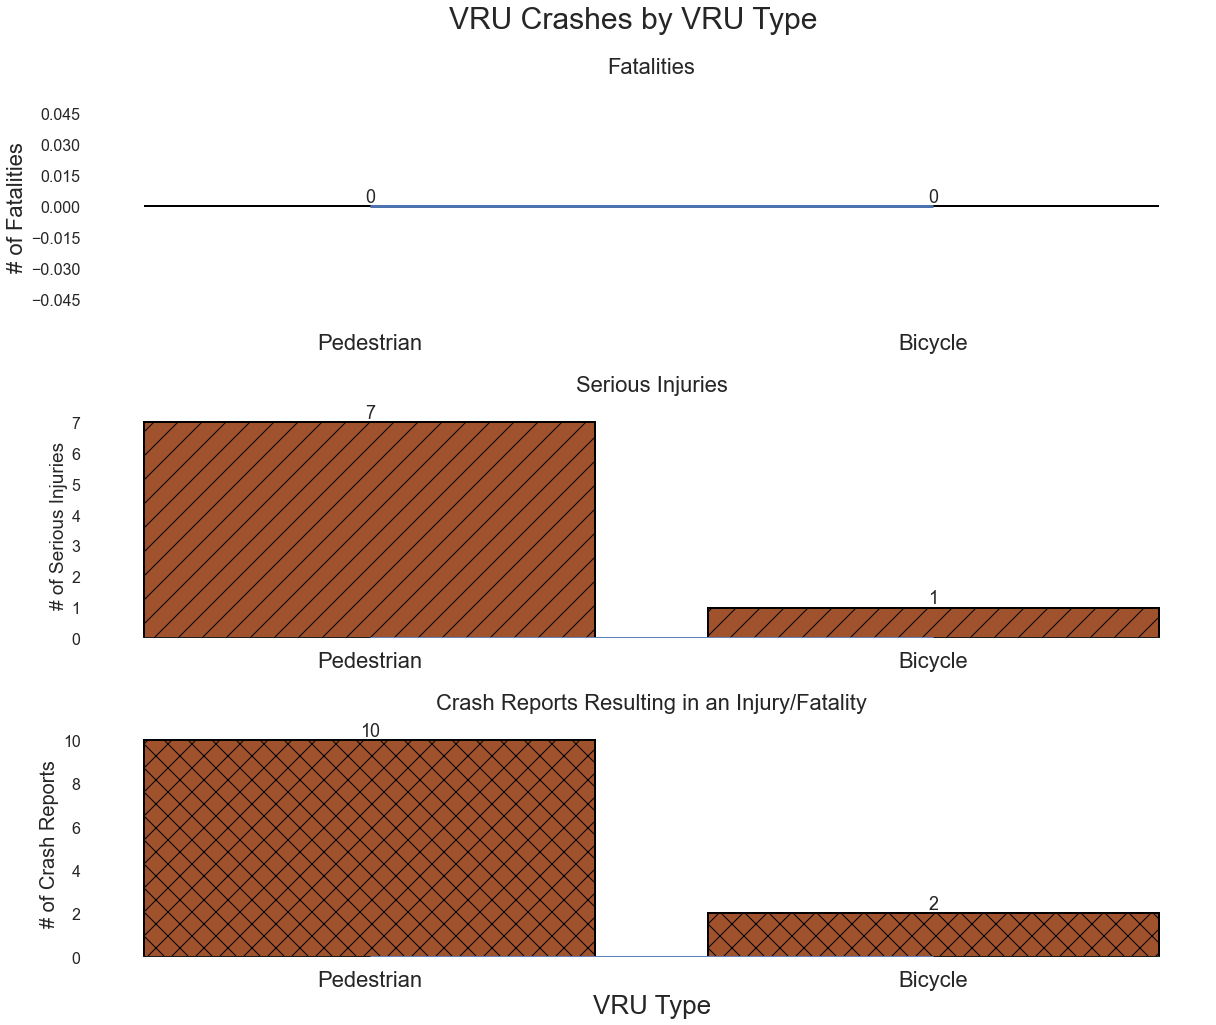

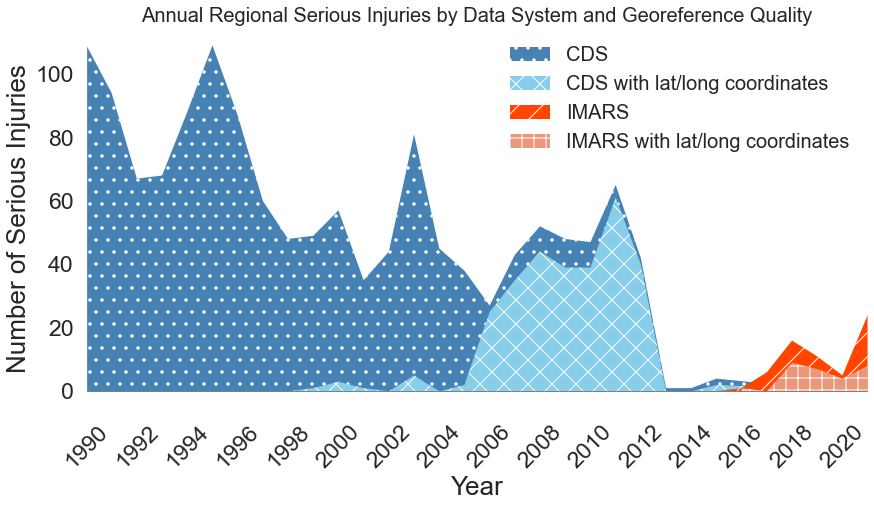

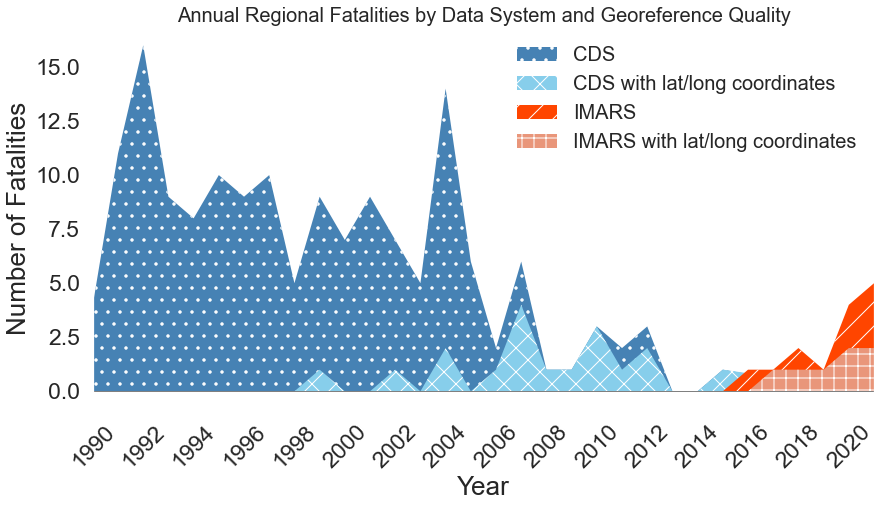

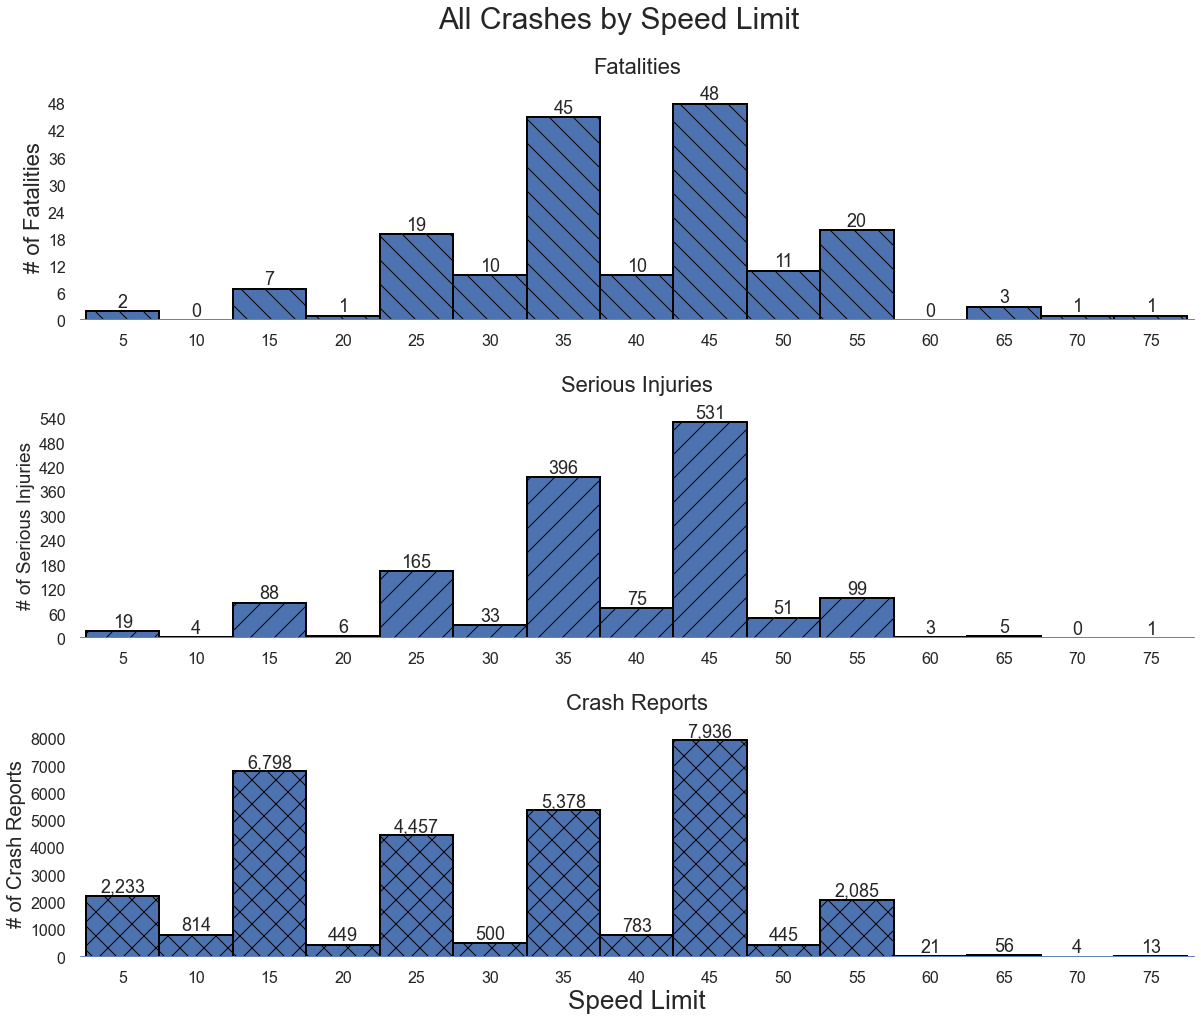

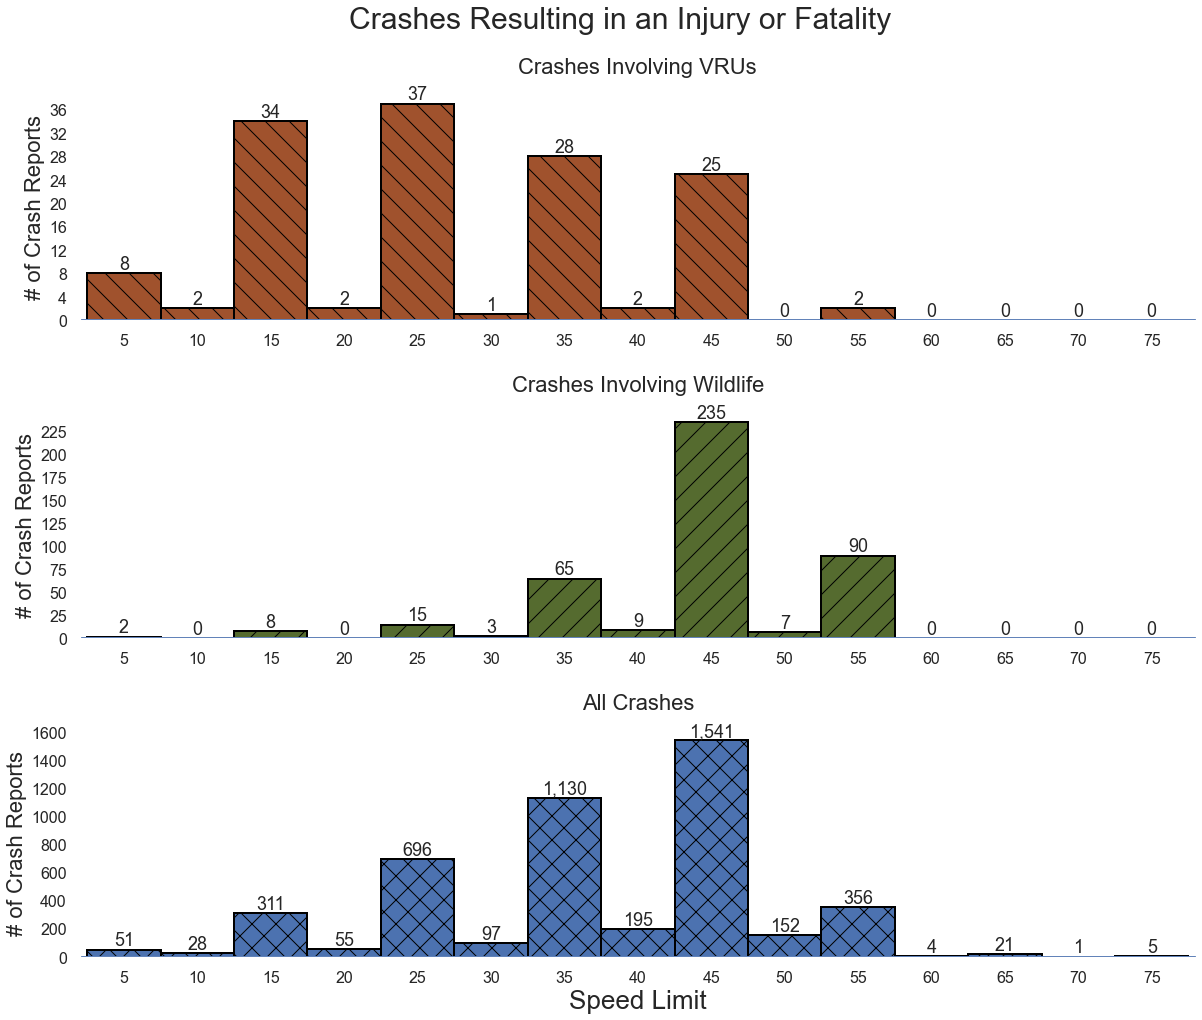

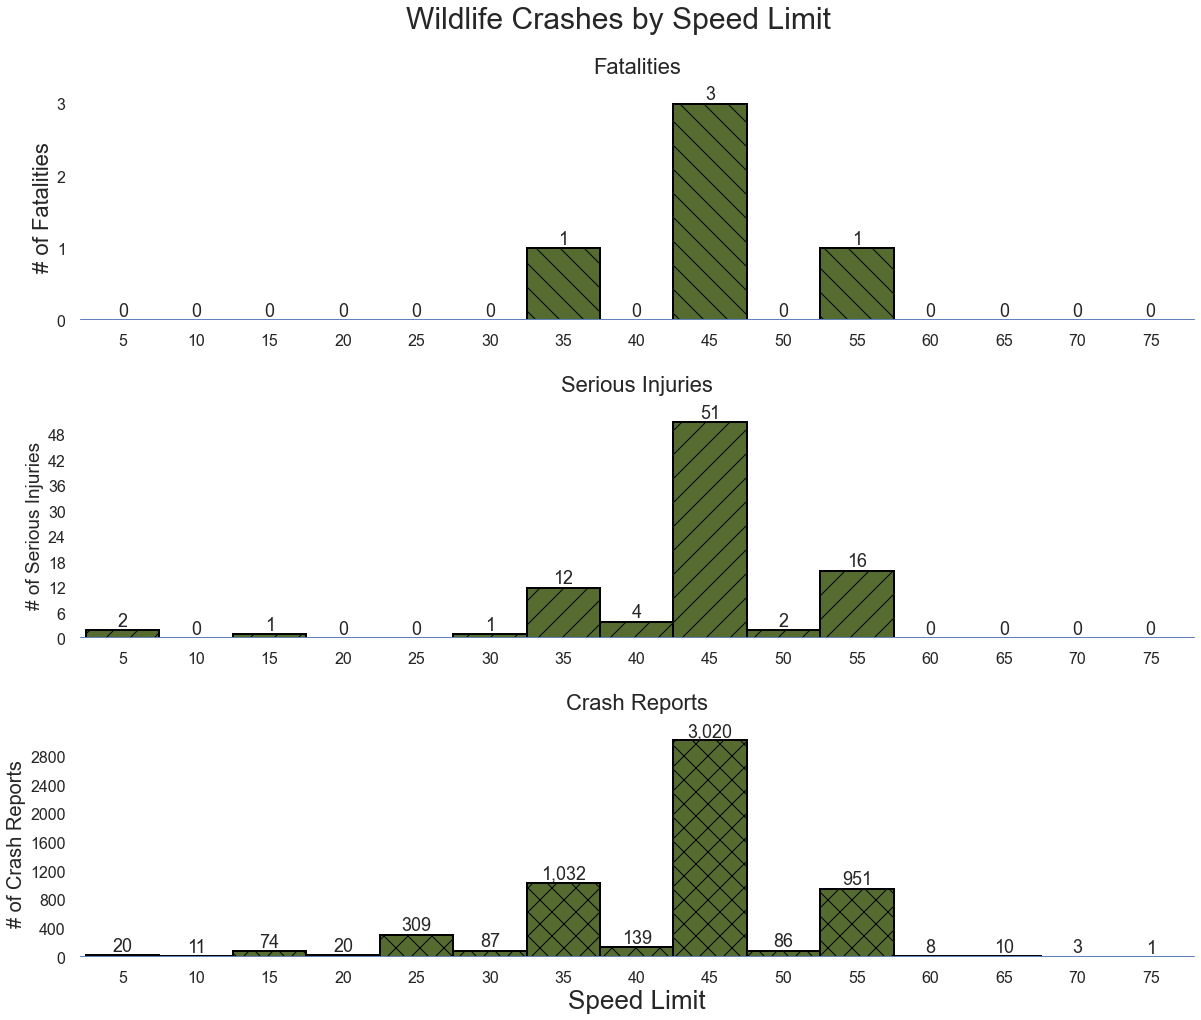

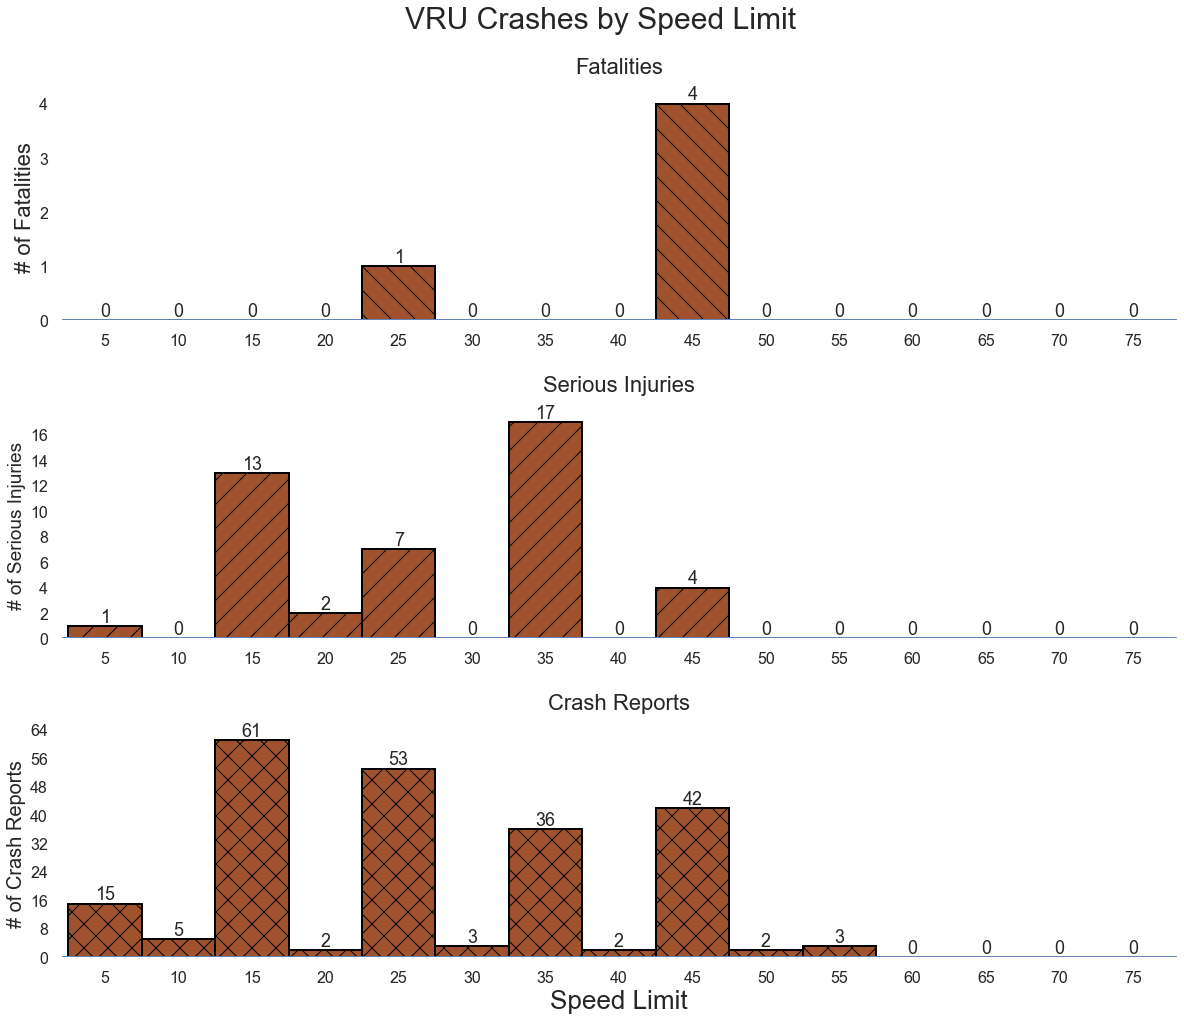

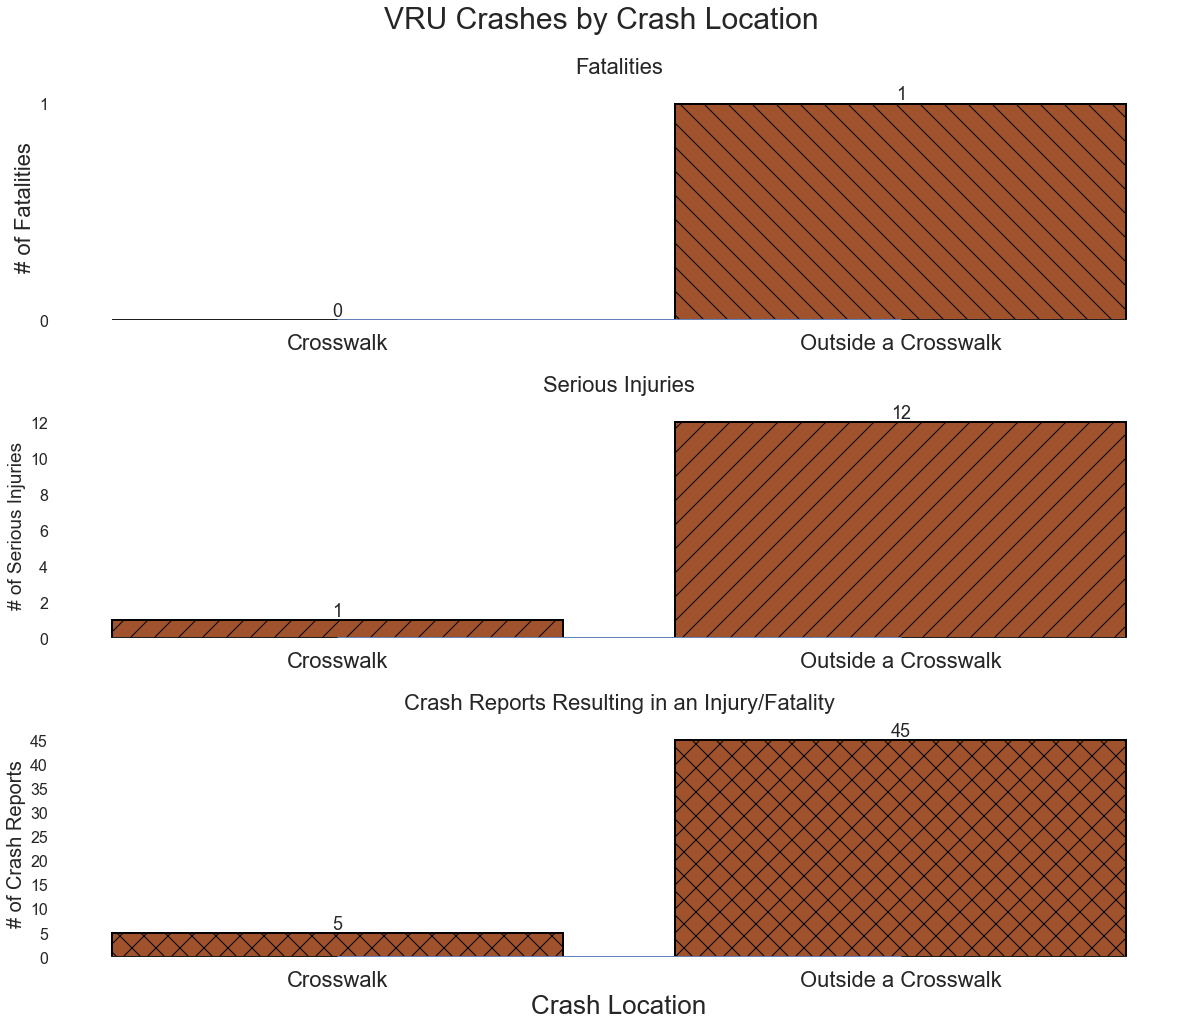

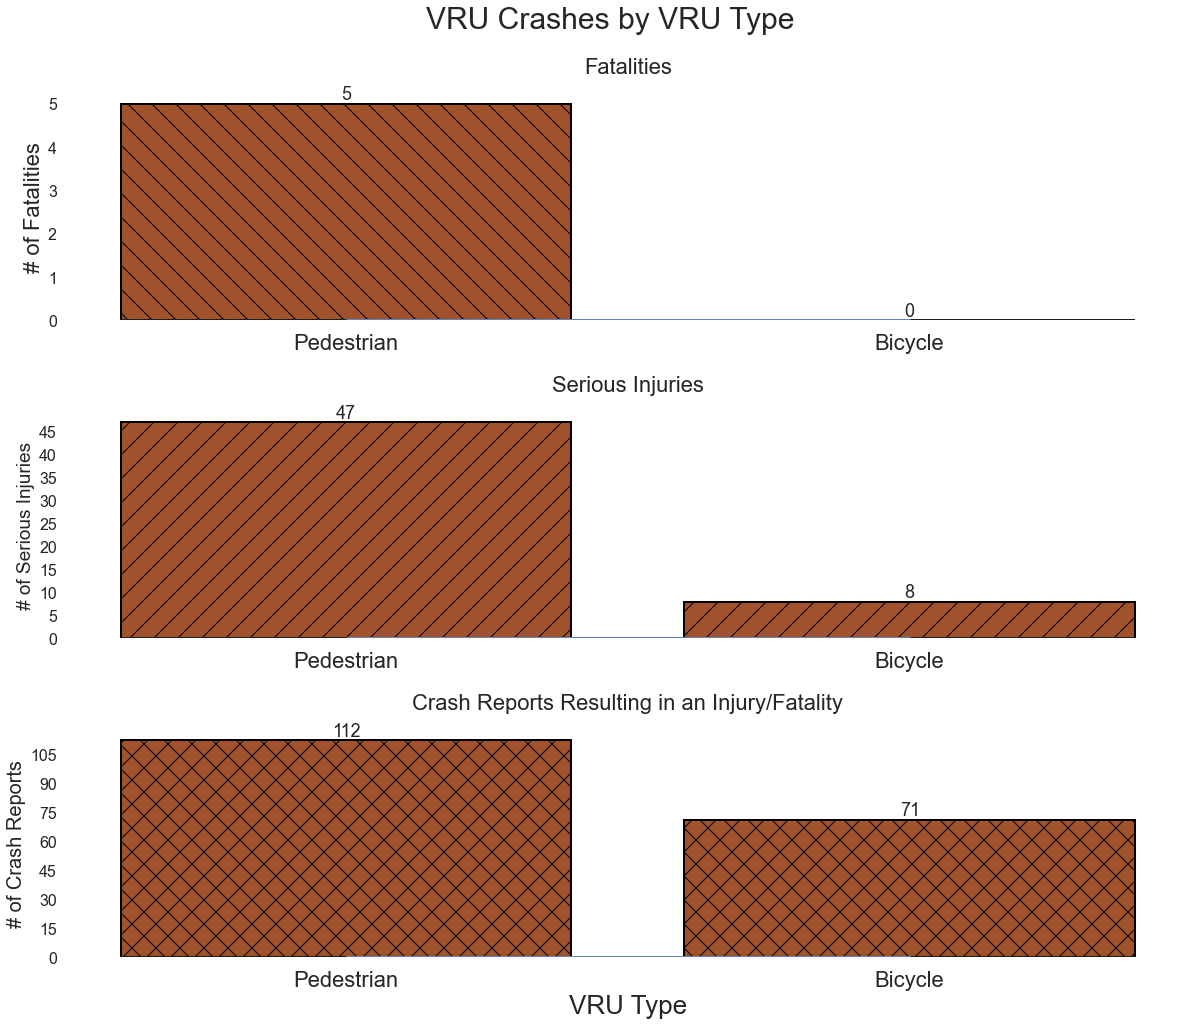

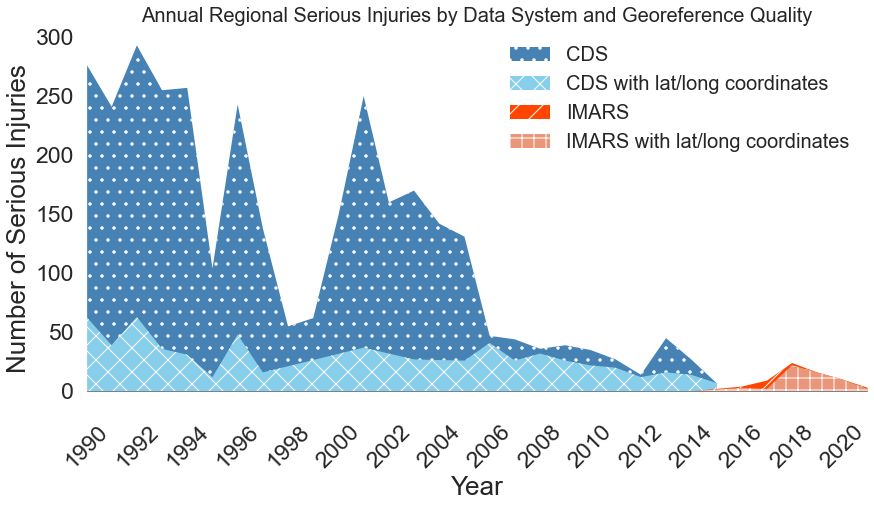

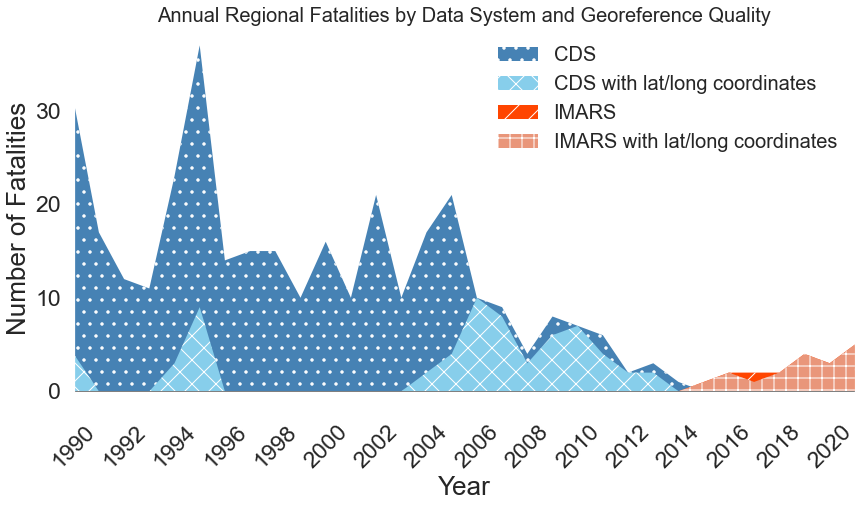

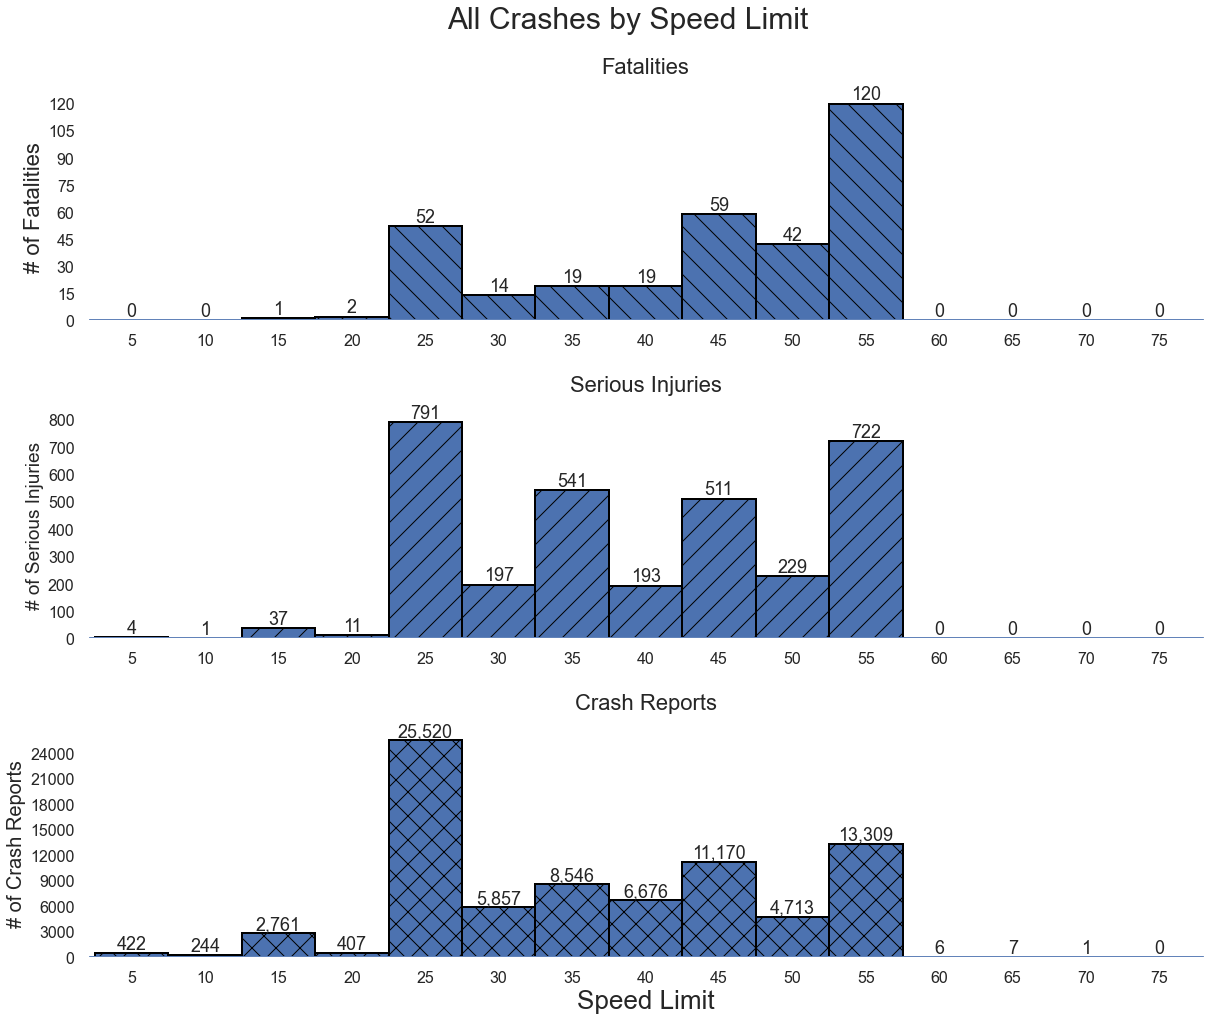

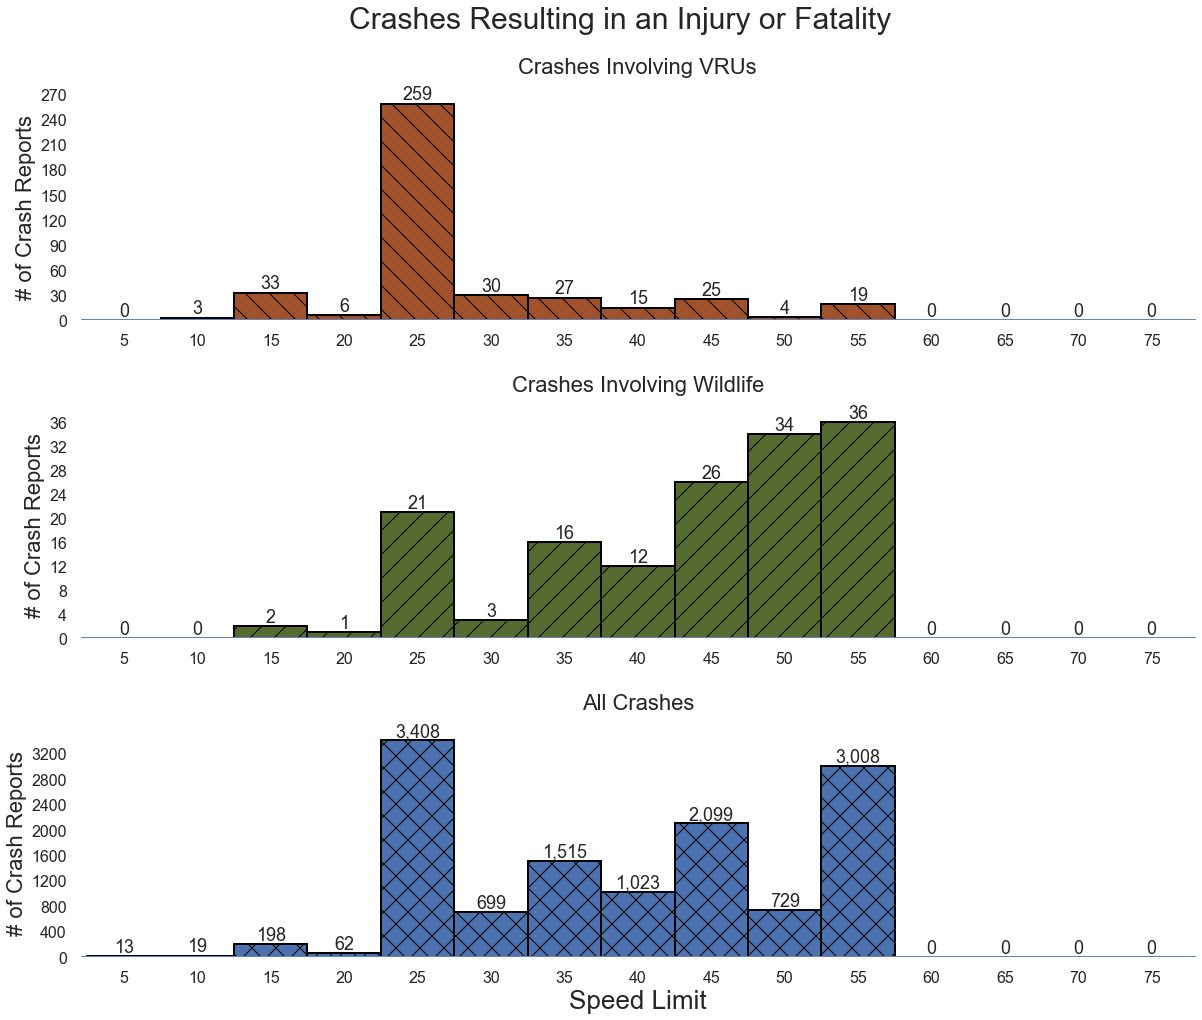

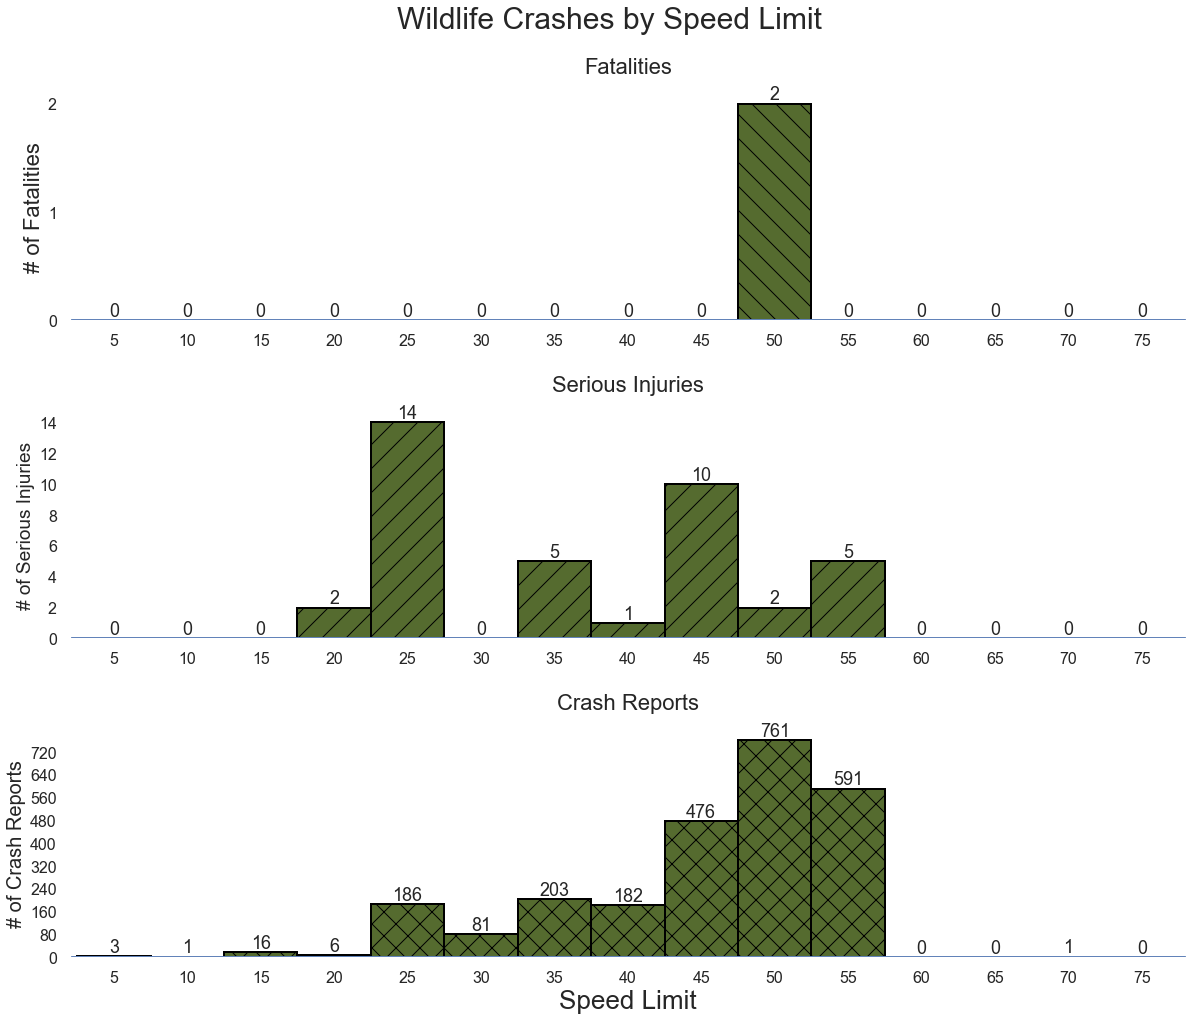

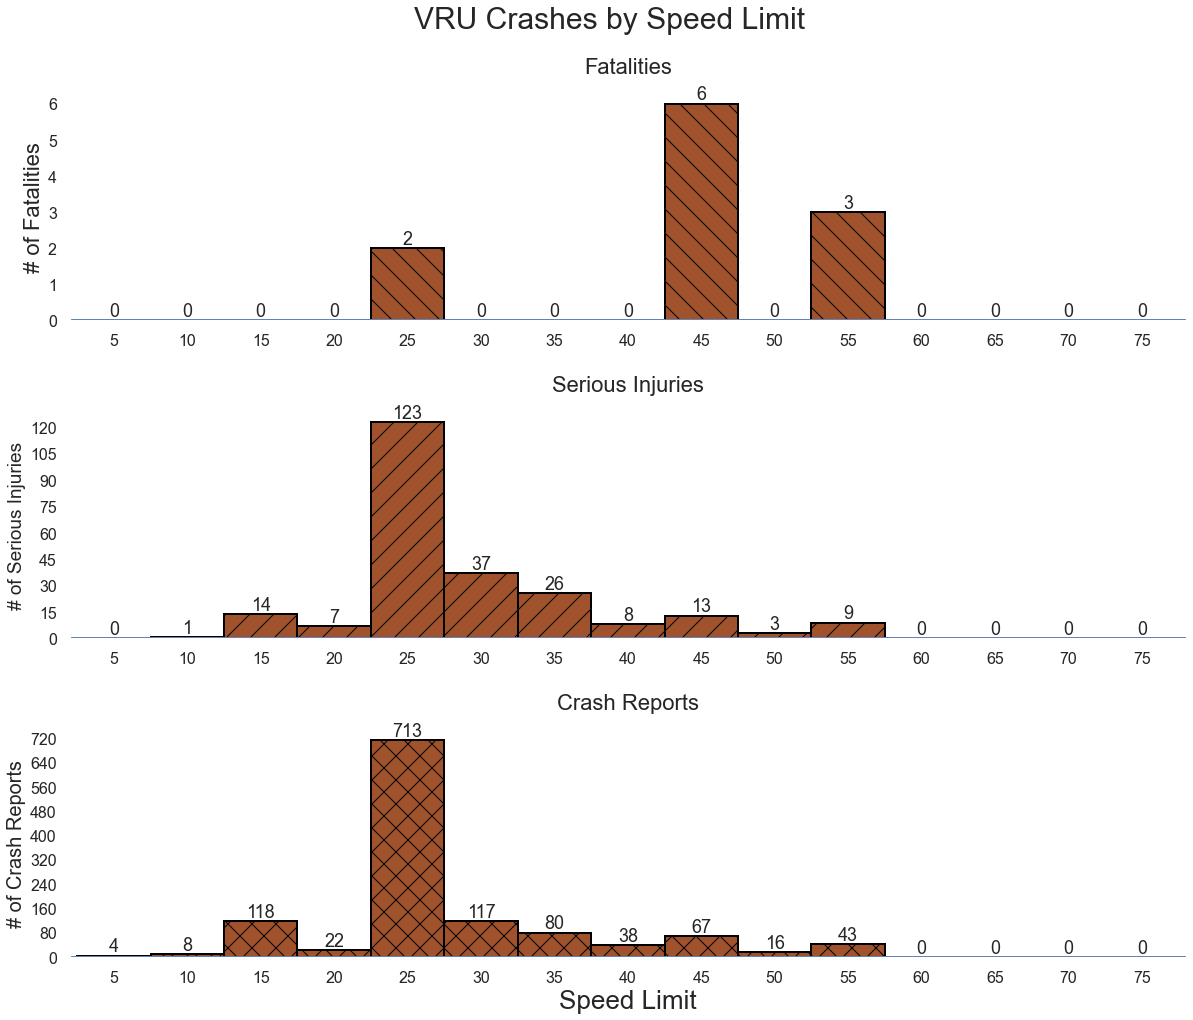

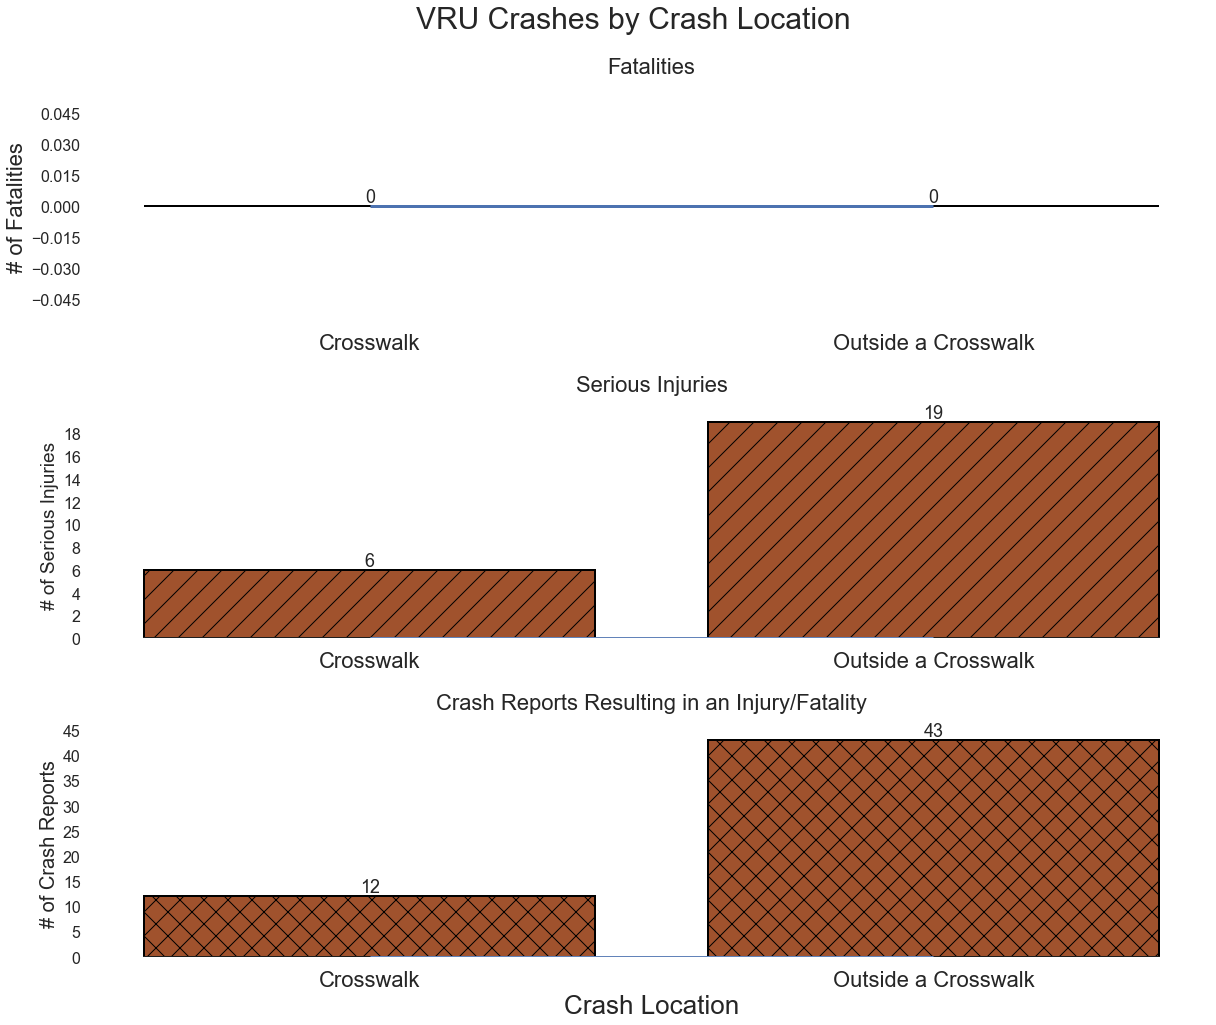

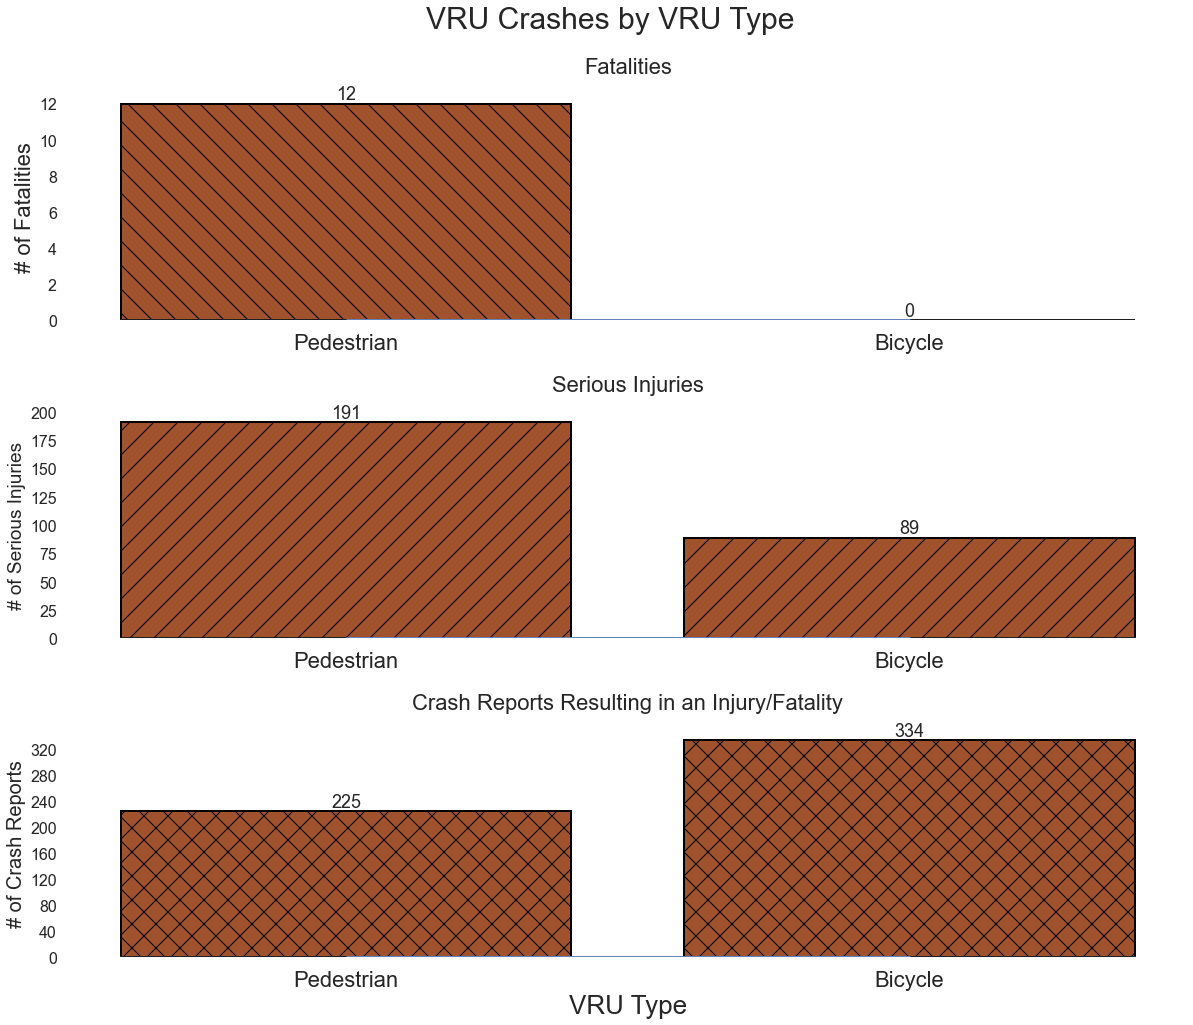

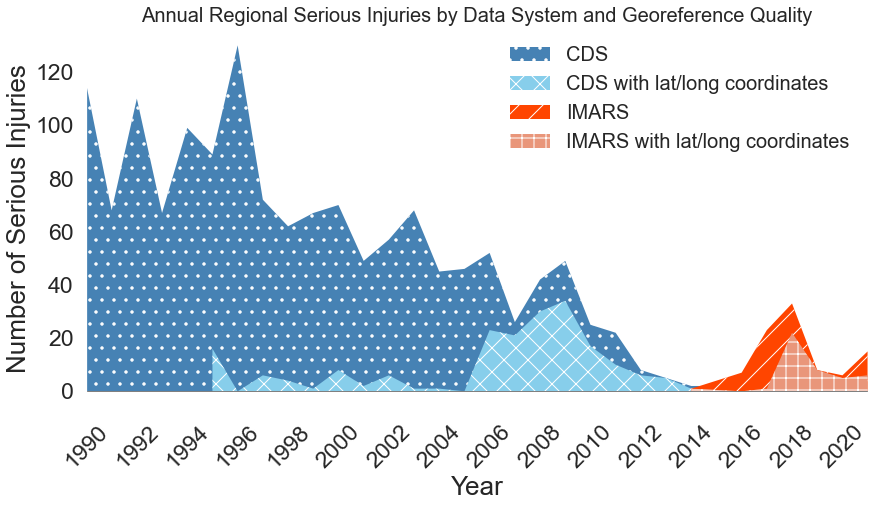

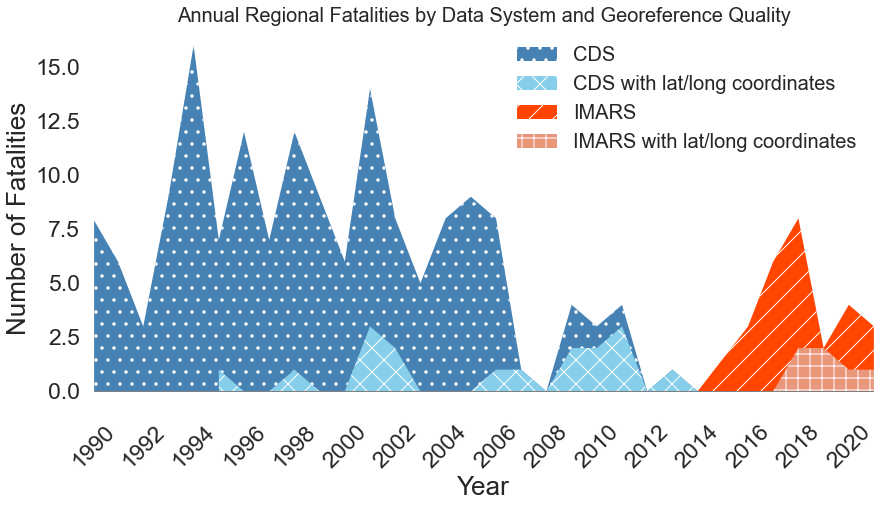

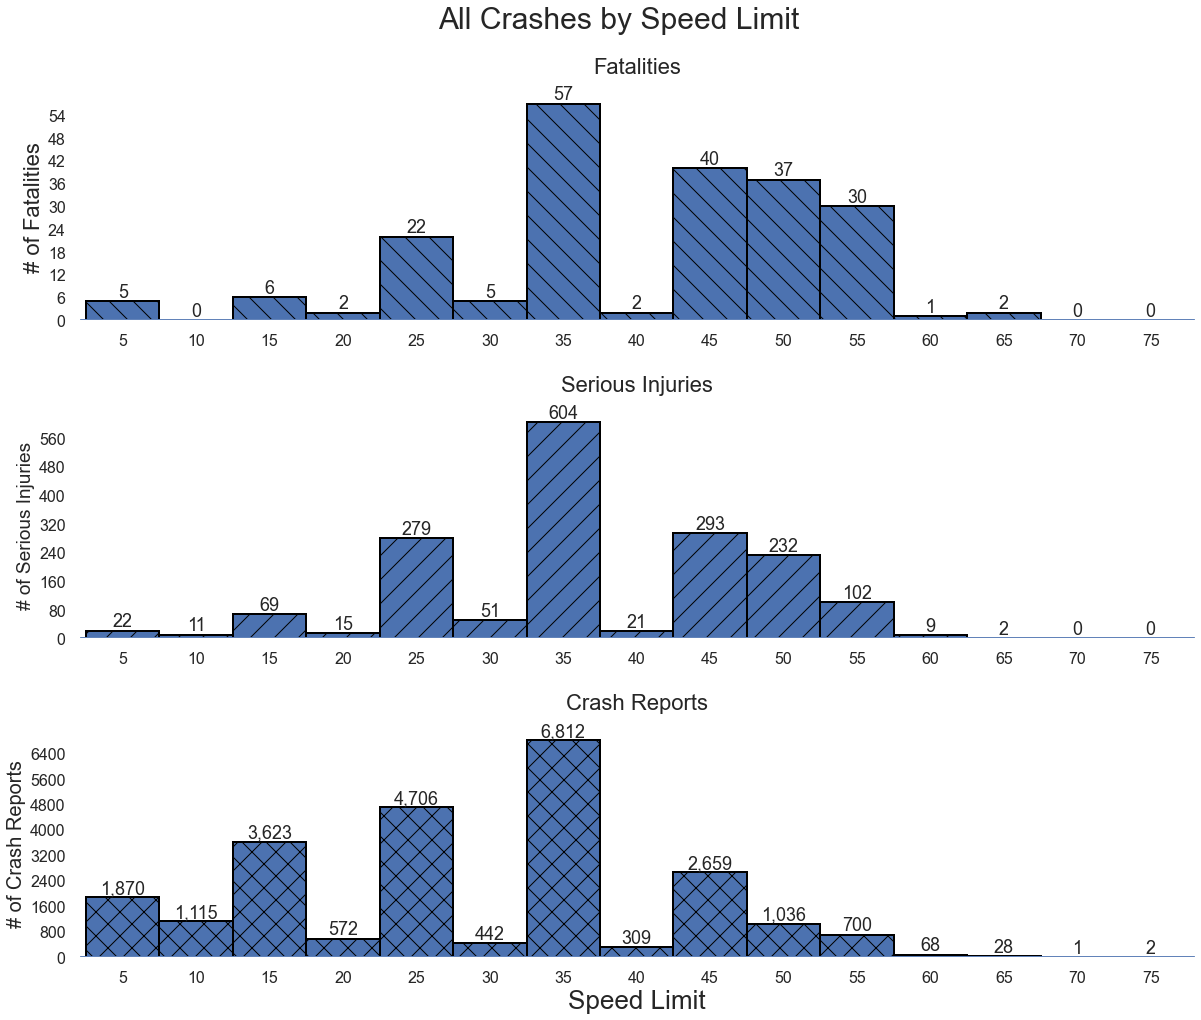

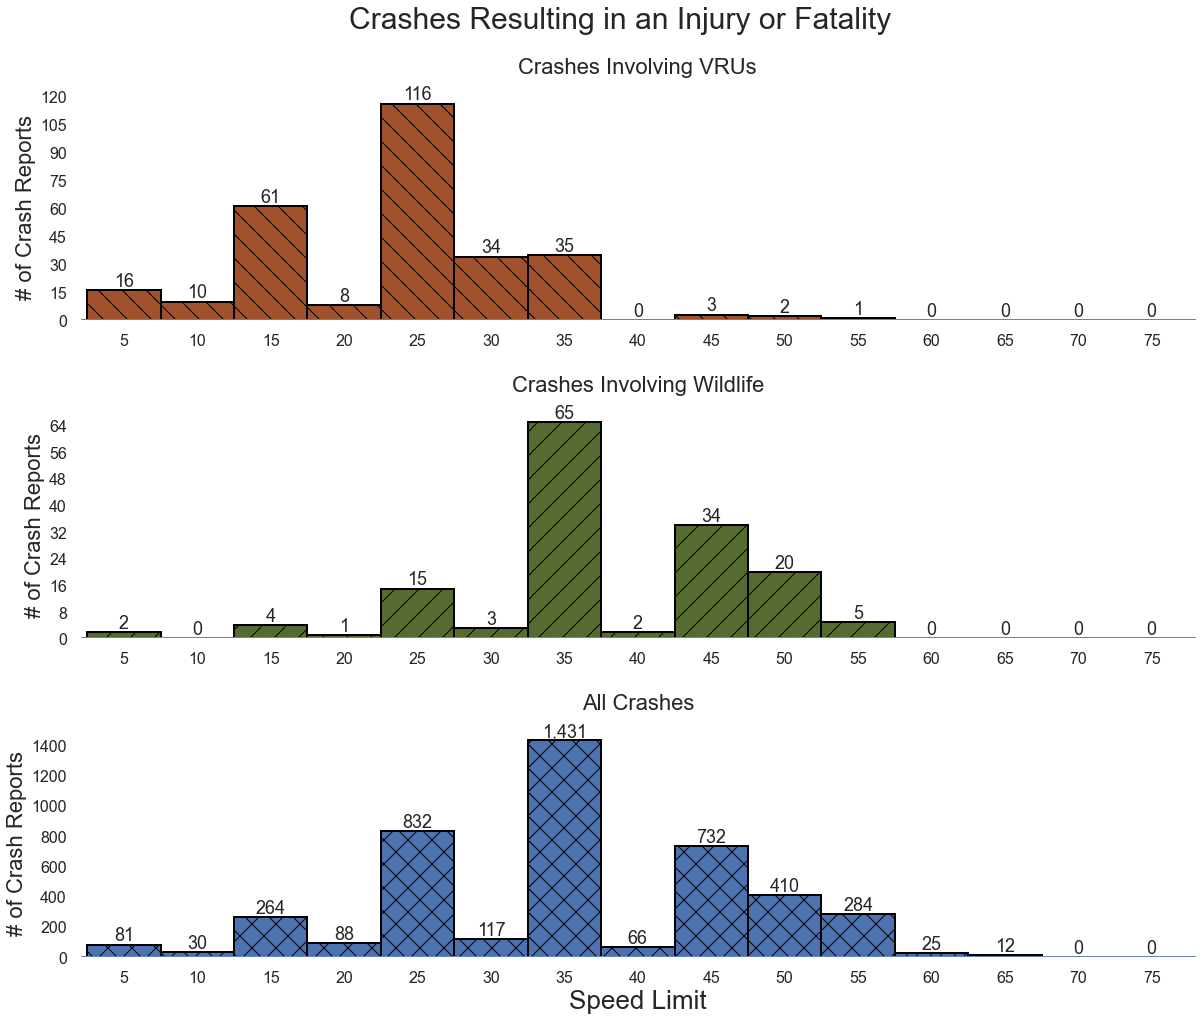

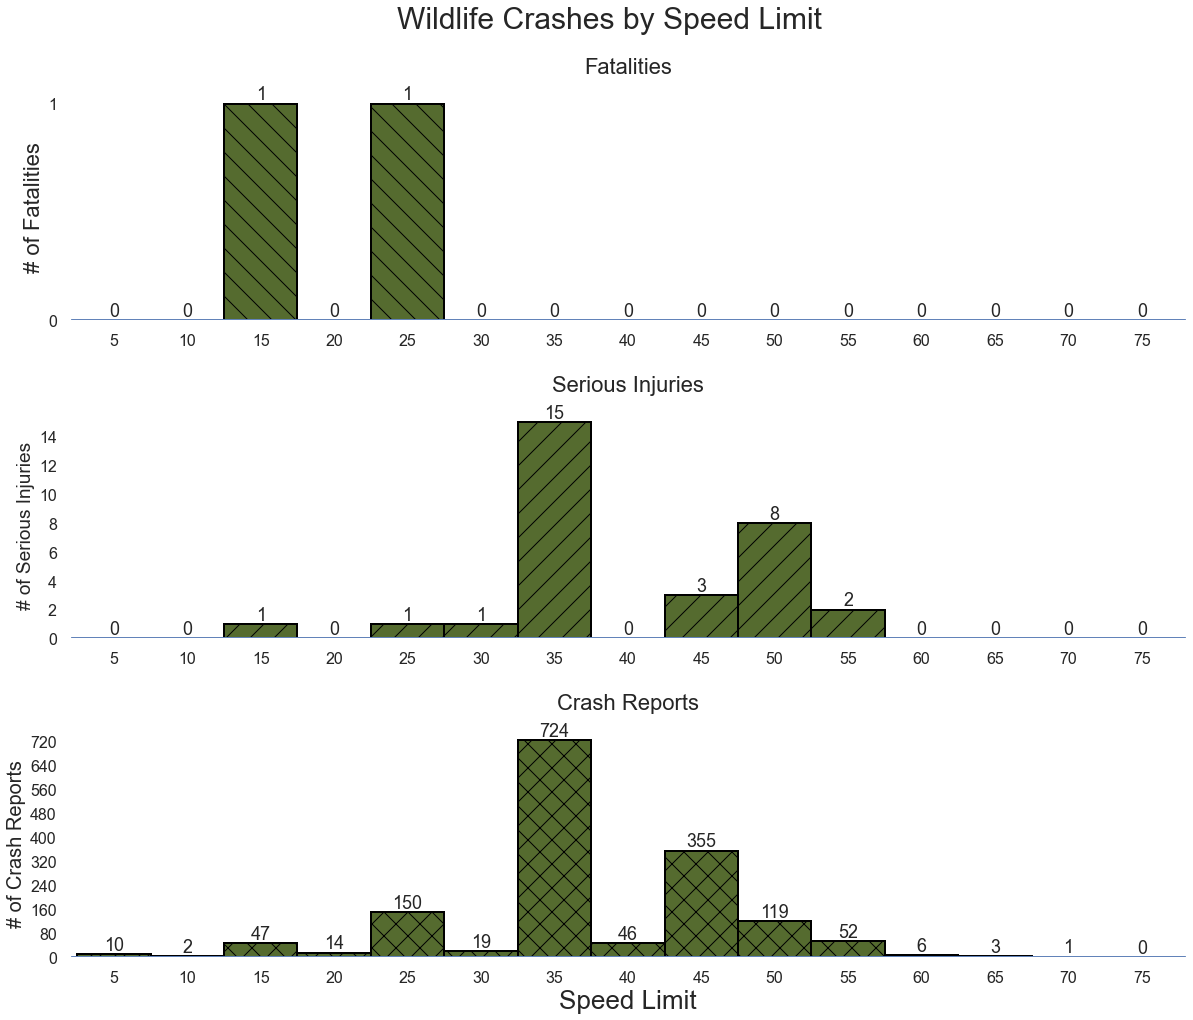

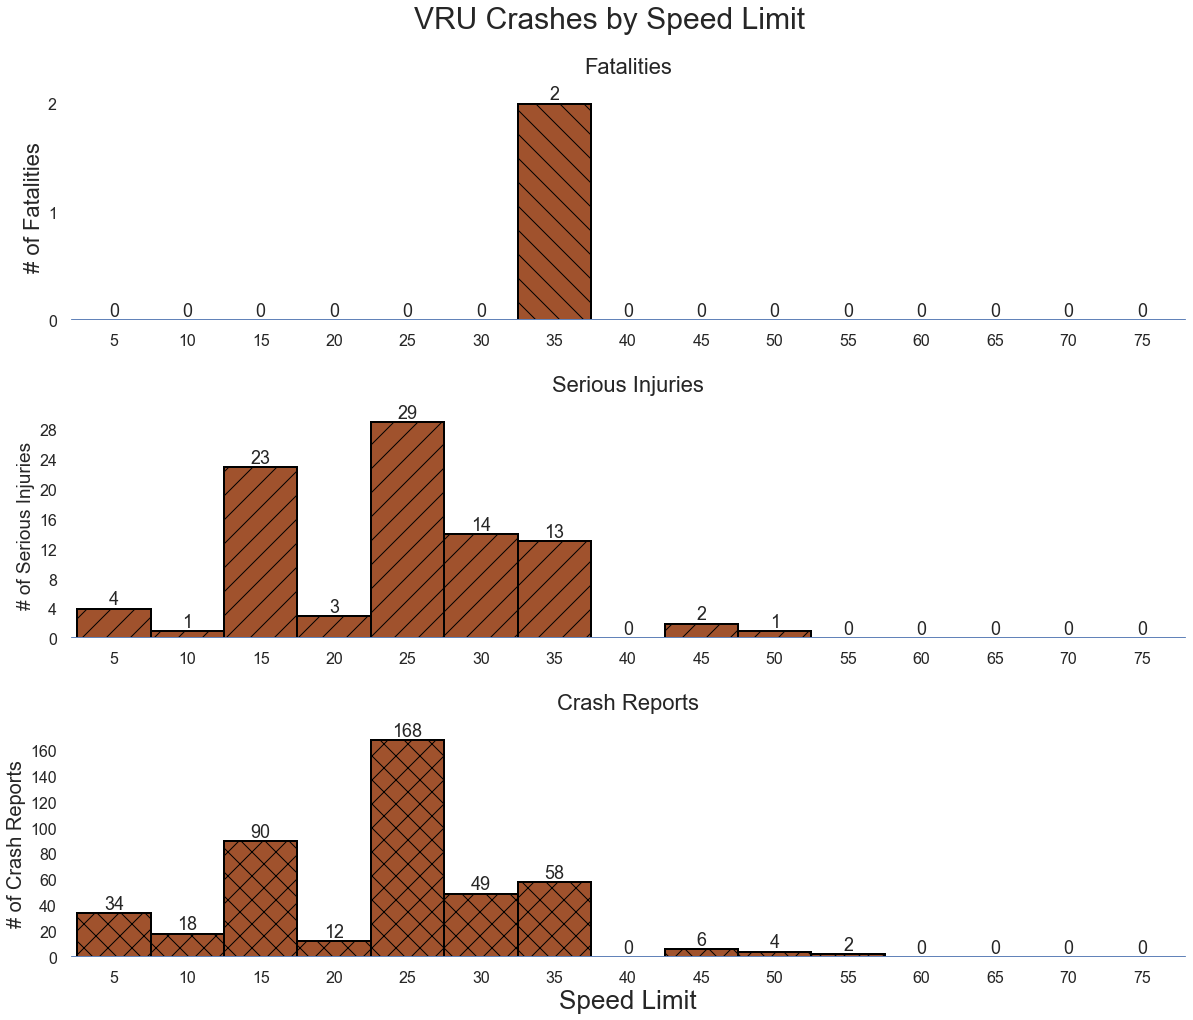

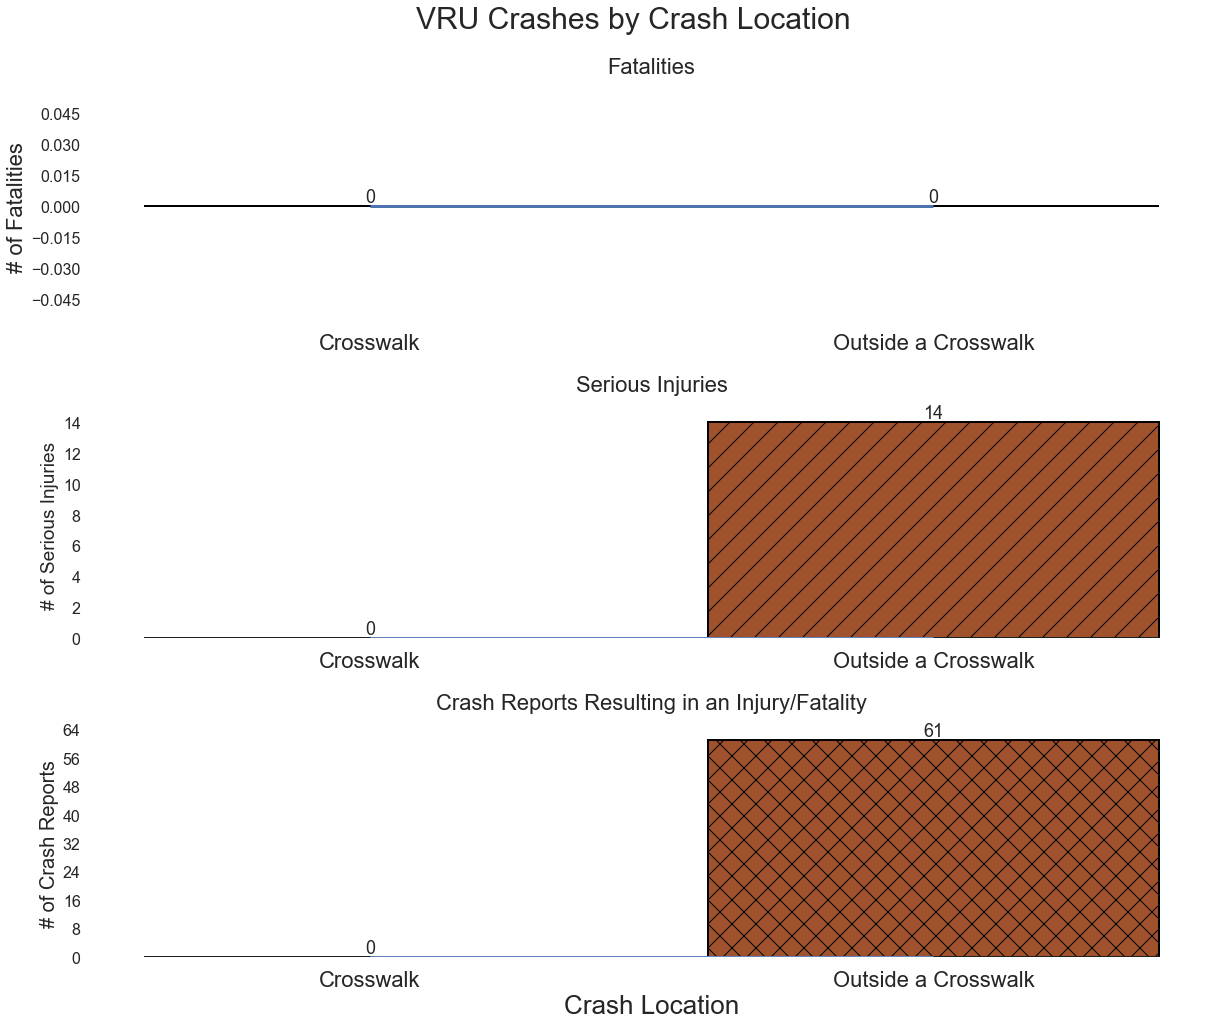

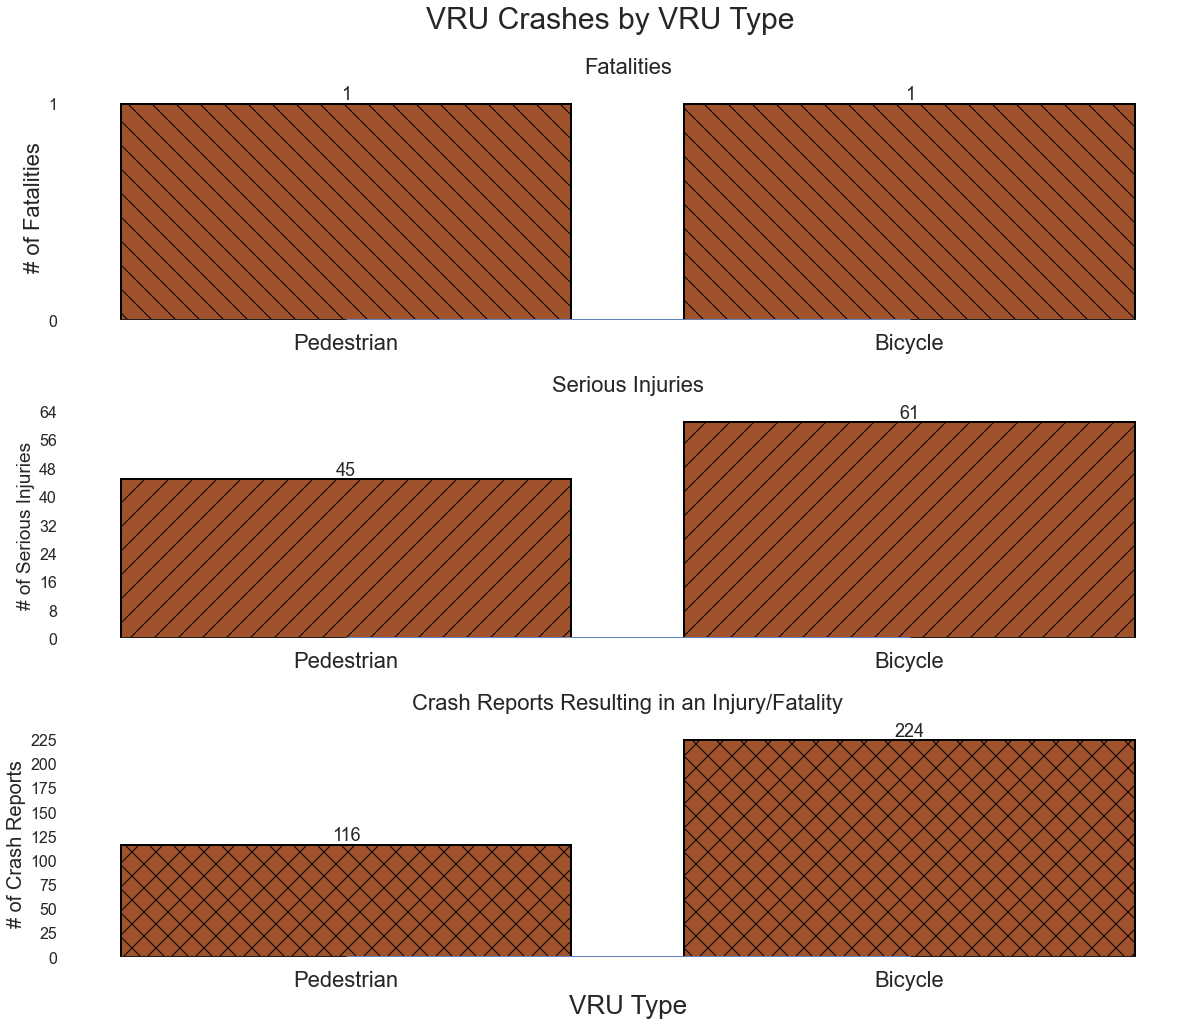

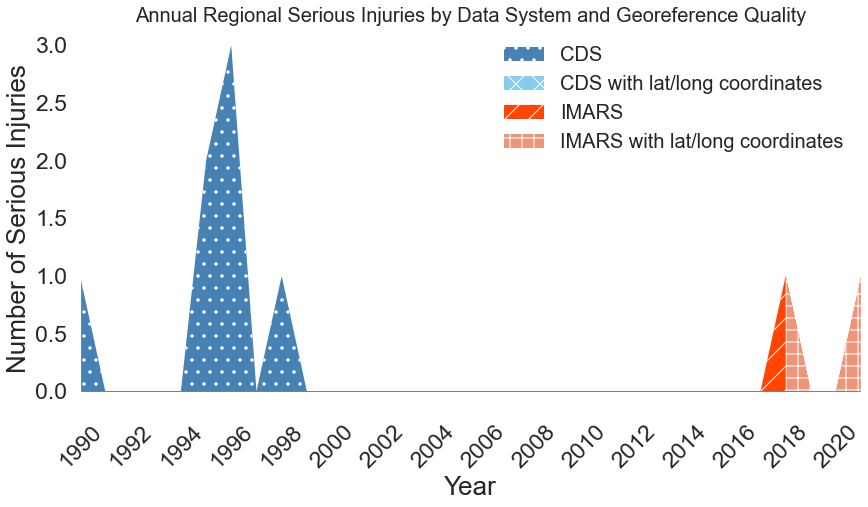

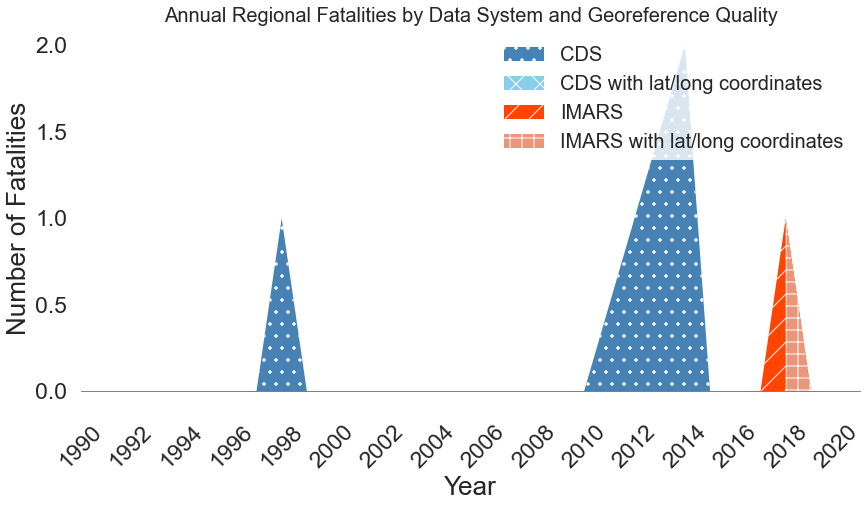

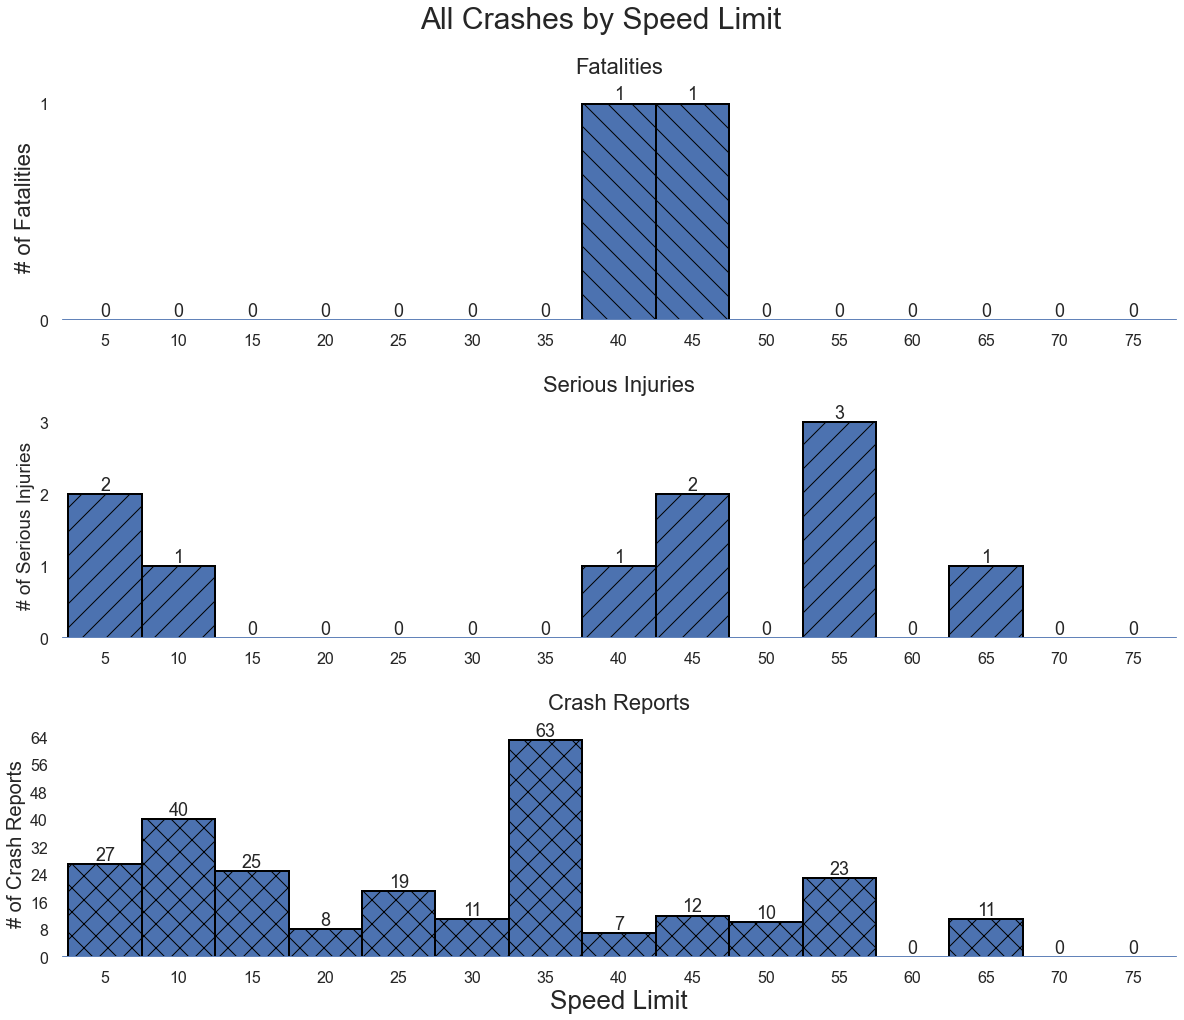

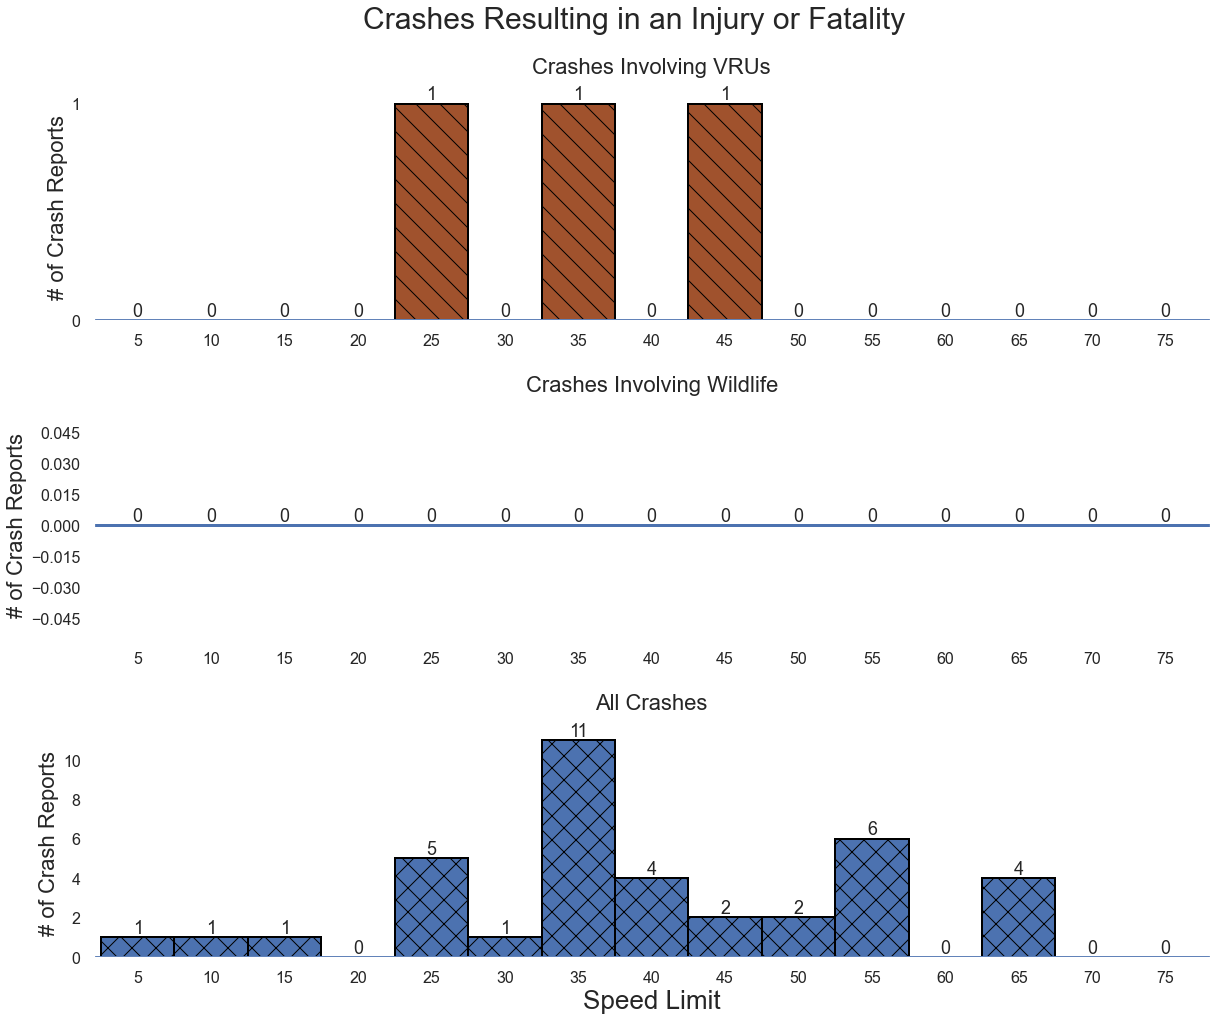

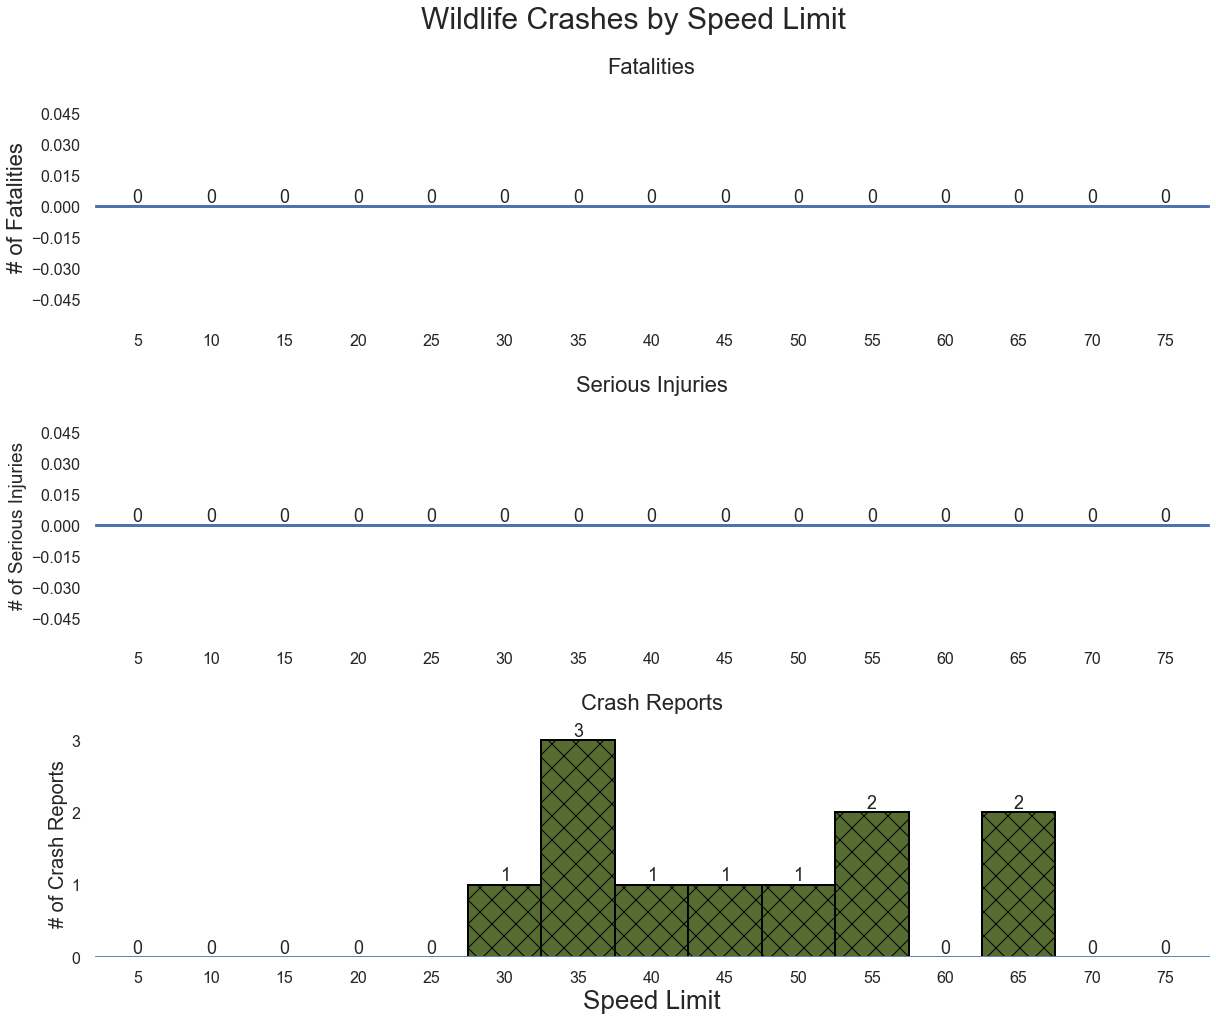

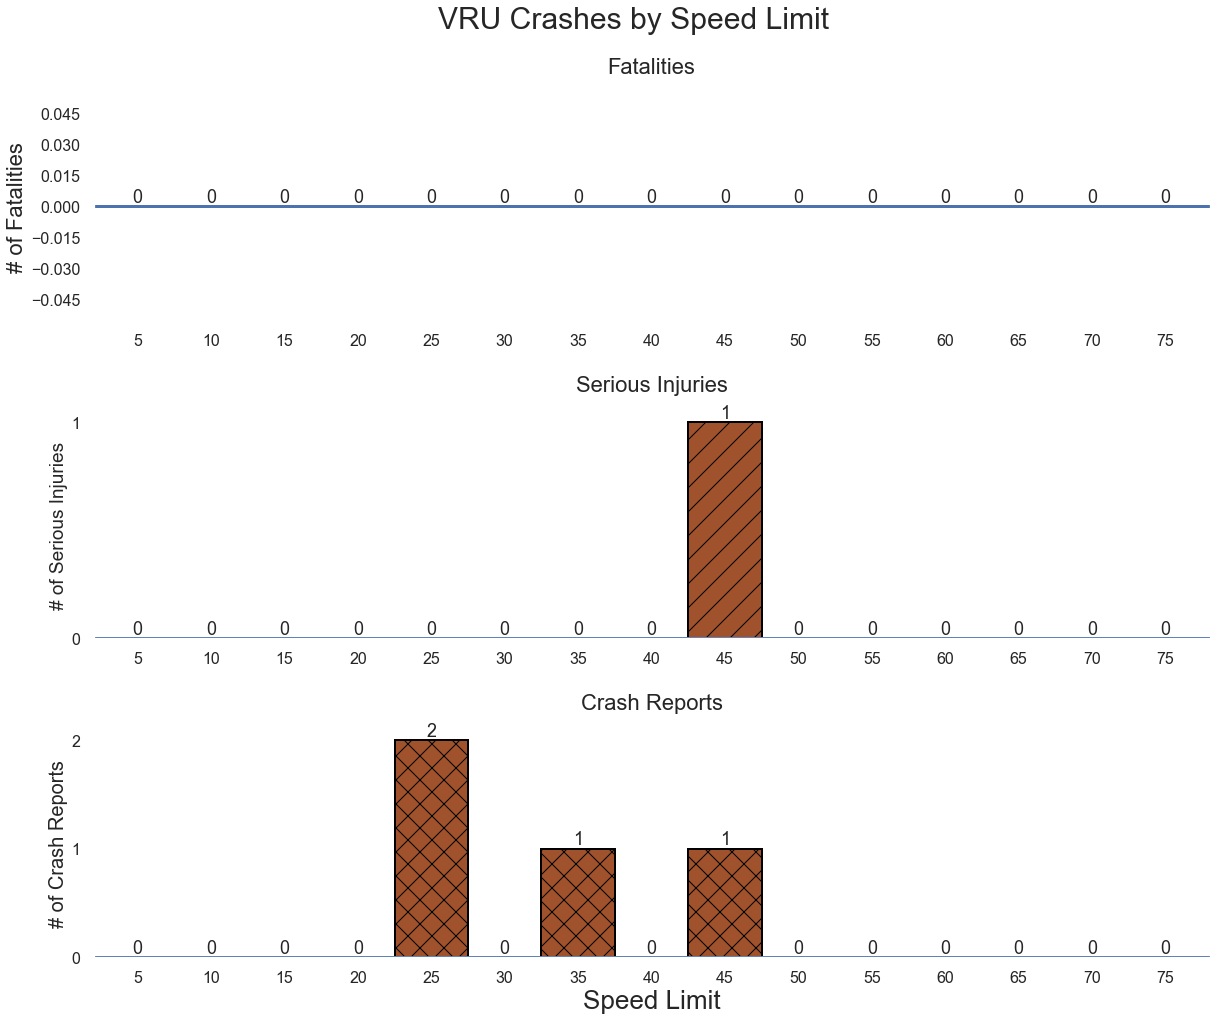

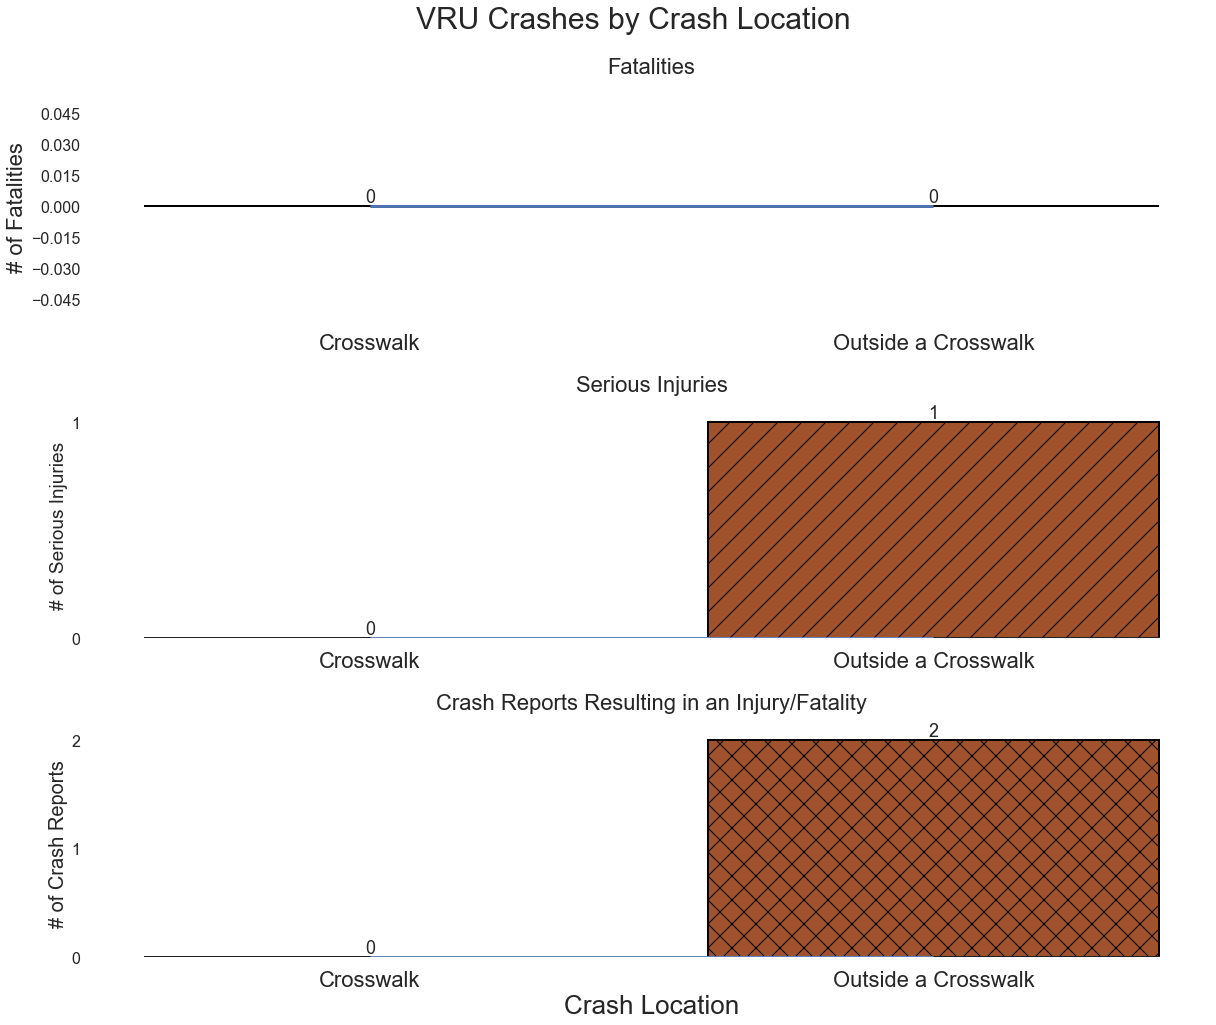

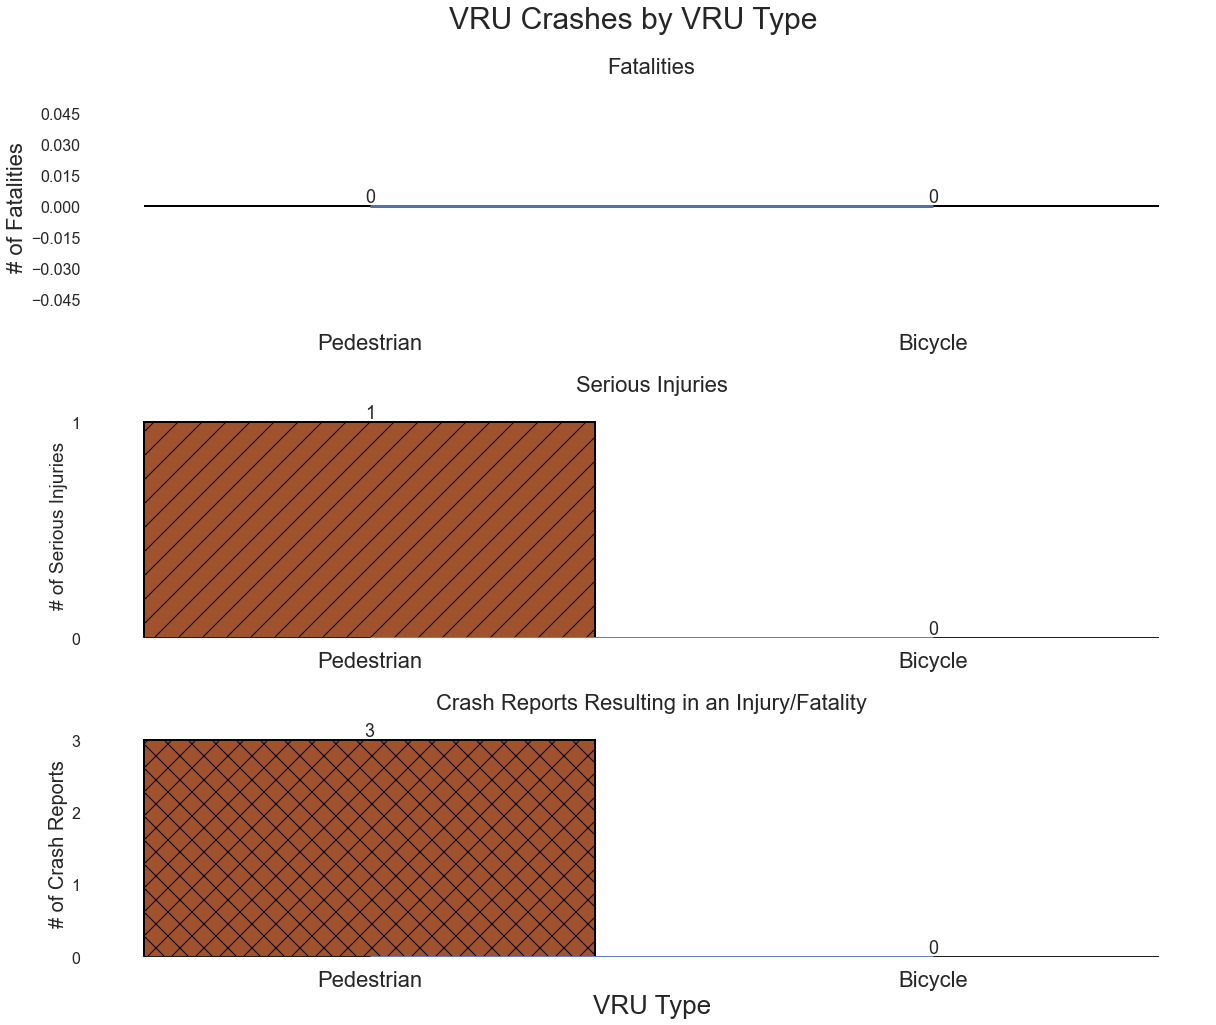

In [104]:
for x in analysis_2022.RGN.unique():
    print(x)
    add_regional_information(x)

In [120]:
for x in analysis_2022.RGN.unique():
    print(x)

SER
NER
MWR
IMR
NCR
PWR
AKR
